# Setting up env

In [1]:
# !pip install google-api-python-client
# !pip install google-auth-httplib2
# !pip install google-auth
# !pip install httplib2
# !pip install google

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn import preprocessing
import numpy as np
import ga_connect

In [3]:
s = ga_connect.Service()

In [4]:
# define scope
scope = ['https://www.googleapis.com/auth/analytics.readonly']

# Authenticate and construct service.
service = s.get_service('analytics', 'v3', scope, 'client_secret_file')
profile = s.get_first_profile_id(service)

## Replace with your view_id

view_id = enter_your_view_id_starting_w_ga_in_quotes

## Custom functions:

In [5]:
def to_float(s):
    return float(s)

In [6]:
## Modified function to get results from Core Reporting API that splits pulls by months to avoid 10k row restriction

def get_results(service, profile_id,start_dates,end_dates,metrics,dimensions,view_id):
  
    #------ Service object, Profile ID, Start Date List, End Date List, metrics, dimension
    
    #------ Use the Analytics Service Object to query the Core Reporting API
    
    # Initiating main df to be returned
    df_main = pd.DataFrame()  
    
    # Running month-wise pulls to ensure <10k row limit per pull
    # may need to be extended to week level based on future traffic - can be manipulated via changes to input lists of start and end days
    for start_date, end_date in zip(start_dates, end_dates):
        print (start_date, end_date)
        
        # Pulling month results
        df = s.get_df(service.data().ga().get(
              ids=view_id,
              start_date=start_date,
              end_date= end_date,
              metrics=metrics,
              dimensions=dimensions,
              max_results=100000).execute(), metrics, dimensions)
        
        # Appending to main DF
        df_main = df_main.append(df)
    
    # Returning main DF
    return df_main

In [7]:
## Define function thast creates flags for day level numbers

def flagger(row):
    if row == 0:
        val = '0'
    elif ((row>0)&(row<=10)):
        val = '0_to_10'
    elif ((row>10)&(row<=50)):
        val = '10_to_50'
    elif ((row>50)&(row<=100)):
        val = '50_to_100'
    else:
        val = '100+'
    return val

In [8]:
## Defining function for day level metrics transformer for different dimensional levels

def df_transform(df, agg_column):
    
    ## Creating column for good-sessions
    df['goodSessions'] = df['sessions']*(1 - df['bounceRate']/100)
    
    ## Creating pivot for each dimension value as a columns
    df_pivot = df.groupby(['Date',agg_column])['goodSessions'].sum().unstack().fillna(0)
    
    ## Creating flags based on mentioned ranges
    for column in df_pivot.columns:
        df_pivot[str(column)+'_flag'] = df_pivot[column].map(flagger)
        
    return df_pivot

In [9]:
## Defining function to add day level conversion numbers to day level pivot df

def df_conversion_join(df, df_conversion):
    
    ## Creating column for good-sessions
    df = df.merge(df_conversion, how = 'left', on = 'Date')

    return df

# Data pulls

## Define date lists to be used for conversions

In [10]:
start_dates=['2019-06-08','2019-07-01','2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01']
end_dates=['2019-06-30','2019-07-31','2019-08-31','2019-09-30','2019-10-31','2019-11-30','2019-12-12']

## Creating data for day level conversions - sign ups, confirm enrollments, pass_through_rate

In [11]:
## Defining metrics
metrics='ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent'
## Defining dimensions
dimensions='ga:Date,ga:eventLabel'

# ---------get results
day_event_level = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)

2019-06-08 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


In [12]:
# filtering for 'sign up' event

day_level_sign_ups_base = day_event_level[day_event_level['eventLabel']=='Sign Up']
aggregation = {'uniqueEvents':sum}       

# Getting day level unique sign-up events
day_level_sign_ups = day_level_sign_ups_base.groupby('Date').agg(aggregation).rename(columns = {'uniqueEvents': 'sign_ups'}).reset_index()
day_level_sign_ups.head()

Date  sign_ups
0 2019-06-08     271.0
1 2019-06-09     330.0
2 2019-06-10     279.0
3 2019-06-11     186.0
4 2019-06-12     321.0

In [13]:
# filtering for 'confirm enrollment' event

day_level_confirm_enrollments_base = day_event_level[day_event_level['eventLabel']=='Confirm Enrollment']
aggregation = {'uniqueEvents':sum}       

# Getting day level unique confirm enrollment events

day_level_confirm_enrollments = day_level_confirm_enrollments_base.groupby('Date').agg(aggregation).rename(columns = {'uniqueEvents': 'confirm_enrollments'}).reset_index()
day_level_confirm_enrollments.head()

Date  confirm_enrollments
0 2019-06-08                  3.0
1 2019-06-09                  5.0
2 2019-06-10                  7.0
3 2019-06-11                  5.0
4 2019-06-12                  8.0

### Creating day level sign-ups, confirm enrollments and pass_through_rate 

In [14]:
## Joining day level sign ups and confirm enrollments
day_level_conversions = day_level_sign_ups.merge(day_level_confirm_enrollments, on = 'Date', how = 'left').fillna(0)

## Creating pass through rate
day_level_conversions['pass_through_rate'] = (day_level_conversions['confirm_enrollments']*100)/day_level_conversions['sign_ups']

## Preview
day_level_conversions.head()

Date  sign_ups  confirm_enrollments  pass_through_rate
0 2019-06-08     271.0                  3.0           1.107011
1 2019-06-09     330.0                  5.0           1.515152
2 2019-06-10     279.0                  7.0           2.508961
3 2019-06-11     186.0                  5.0           2.688172
4 2019-06-12     321.0                  8.0           2.492212

### Adding lag variables

In [15]:
day_level_conversions_w_lag = day_level_conversions.copy()

number_lags = 3
for lag in range(1, number_lags + 1):
    day_level_conversions_w_lag['lag_' + str(lag)] = day_level_conversions_w_lag.pass_through_rate.shift(lag)

In [16]:
day_level_conversions_w_lag = day_level_conversions_w_lag.dropna()

## Defining dates for all further pulls

In [17]:
start_dates=['2019-06-11','2019-07-01','2019-08-01','2019-09-01','2019-10-01','2019-11-01','2019-12-01']
end_dates=['2019-06-30','2019-07-31','2019-08-31','2019-09-30','2019-10-31','2019-11-30','2019-12-12']

## Pulling and transforming data for campaign:

### Data pull

In [18]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:dateHour,ga:campaign'

In [19]:
df_campaign_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_campaign_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date    dateHour   campaign  sessions  users  uniqueEvents  \
0 2019-06-11  2019061100  (not set)       4.0    4.0           3.0   
1 2019-06-11  2019061100    digchzl       8.0    7.0           0.0   
2 2019-06-11  2019061100  diggoogpd       3.0    3.0           0.0   
3 2019-06-11  2019061100   digsocfb       1.0    1.0           0.0   
4 2019-06-11  2019061101  (not set)       1.0    1.0           2.0   

   totalEvents  sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0          8.0                2.0                        4.0        50.0   
1          0.0                0.0                        0.0        37.5   
2          0.0                0.0                        0.0       100.0   
3          0.0                0.0                        0.0       100.0   
4          2.0                1.0                        2.0         0.0   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0                 3.00             231.000           50.000000  
1                 1.75               9.375           87.500000  
2                 1.00               0.000           66.666667  
3                 1.00               0.000          100.000000  
4                 3.00             166.000          100.000000

### EDA

In [20]:
print('Total number of campaings:', df_campaign_main.campaign.nunique())

Total number of campaings: 44


In [21]:
## Top 10 campaigns:

df_campaign_main.groupby(['campaign'])['sessions'].sum().sort_values(ascending=False).head(20)

campaign
(not set)                                                 135278.0
diggoogpd                                                  49436.0
digchzl                                                    27128.0
digsocfb                                                   20571.0
brandawareness                                             11904.0
remarketing                                                 5017.0
dignxtdr                                                    3614.0
cheap-houston-electricity                                   3509.0
cheap-dallas-electricity                                    3332.0
chzlgreen-cp                                                2549.0
chzlgreen-oncor                                             2417.0
chzlgreen                                                   1462.0
digremktg                                                   1124.0
branded-middle                                               886.0
digrltr                                              

We decide to take all campaigns for which total sessions > 1000

In [22]:
## Filtering for all campaigns > 1000 sessions

df_campaign_top = pd.DataFrame(df_campaign_main.groupby(['campaign'])['sessions'].sum().sort_values(ascending=False).reset_index())
df_campaign_top = df_campaign_top[df_campaign_top['sessions']>1000]
df_campaign_top.head()

campaign  sessions
0       (not set)  135278.0
1       diggoogpd   49436.0
2         digchzl   27128.0
3        digsocfb   20571.0
4  brandawareness   11904.0

In [23]:
## Removing campaign not set row

df_campaign_top = df_campaign_top[df_campaign_top['campaign']!='(not set)']
df_campaign_top.head()

campaign  sessions
1       diggoogpd   49436.0
2         digchzl   27128.0
3        digsocfb   20571.0
4  brandawareness   11904.0
5     remarketing    5017.0

### DF Transformation

In [24]:
## Filtering main df for these top few campaigns based on EDA

df_campaign_main = df_campaign_main.merge(df_campaign_top['campaign'], how = 'inner', left_on = 'campaign', right_on = 'campaign')

In [25]:
## Getting pivot for campaign data

df_campaign_pivot = df_transform(df_campaign_main, 'campaign')
df_campaign_pivot.head()

campaign    brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

campaign    cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

campaign    chzlgreen-oncor  digchzl  diggoogpd  dignxtdr  digremktg  ...  \
Date                                                                  ...   
2019-06-11              0.0      5.0       72.0       7.0        0.0  ...   
2019-06-12              0.0     51.0      101.0      78.0        0.0  ...   
2019-06-13              0.0     19.0      121.0     111.0        0.0  ...   
2019-06-14              0.0      3.0       86.0      41.0        0.0  ...   
2019-06-15              0.0      6.0       55.0      34.0        0.0  ...   

campaign    cheap-houston-electricity_flag  chzlgreen_flag chzlgreen-cp_flag  \
Date                                                                           
2019-06-11                               0               0                 0   
2019-06-12                               0               0                 0   
2019-06-13                               0               0                 0   
2019-06-14                               0               0                 0   
2019-06-15                               0               0                 0   

campaign   chzlgreen-oncor_flag digchzl_flag diggoogpd_flag dignxtdr_flag  \
Date                                                                        
2019-06-11                    0      0_to_10      50_to_100       0_to_10   
2019-06-12                    0    50_to_100           100+     50_to_100   
2019-06-13                    0     10_to_50           100+          100+   
2019-06-14                    0      0_to_10      50_to_100      10_to_50   
2019-06-15                    0      0_to_10      50_to_100      10_to_50   

campaign   digremktg_flag digsocfb_flag remarketing_flag  
Date                                                      
2019-06-11              0       0_to_10                0  
2019-06-12              0       0_to_10                0  
2019-06-13              0       0_to_10                0  
2019-06-14              0       0_to_10                0  
2019-06-15              0       0_to_10                0  

[5 rows x 24 columns]

In [26]:
df_campaign_pivot_w_conversion = df_campaign_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_campaign_pivot_w_conversion.head()

brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

            cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

            chzlgreen-oncor  digchzl  diggoogpd  dignxtdr  digremktg  ...  \
Date                                                                  ...   
2019-06-11              0.0      5.0       72.0       7.0        0.0  ...   
2019-06-12              0.0     51.0      101.0      78.0        0.0  ...   
2019-06-13              0.0     19.0      121.0     111.0        0.0  ...   
2019-06-14              0.0      3.0       86.0      41.0        0.0  ...   
2019-06-15              0.0      6.0       55.0      34.0        0.0  ...   

            chzlgreen-oncor_flag  digchzl_flag diggoogpd_flag dignxtdr_flag  \
Date                                                                          
2019-06-11                     0       0_to_10      50_to_100       0_to_10   
2019-06-12                     0     50_to_100           100+     50_to_100   
2019-06-13                     0      10_to_50           100+          100+   
2019-06-14                     0       0_to_10      50_to_100      10_to_50   
2019-06-15                     0       0_to_10      50_to_100      10_to_50   

           digremktg_flag digsocfb_flag remarketing_flag sign_ups  \
Date                                                                
2019-06-11              0       0_to_10                0    186.0   
2019-06-12              0       0_to_10                0    321.0   
2019-06-13              0       0_to_10                0    295.0   
2019-06-14              0       0_to_10                0    200.0   
2019-06-15              0       0_to_10                0    118.0   

           confirm_enrollments pass_through_rate  
Date                                              
2019-06-11                 5.0          2.688172  
2019-06-12                 8.0          2.492212  
2019-06-13                11.0          3.728814  
2019-06-14                 7.0          3.500000  
2019-06-15                 0.0          0.000000  

[5 rows x 27 columns]

### Creating data without "diggoogpd"

In [27]:
## Removing campaign not set row

df_campaign_top_wo_google = df_campaign_top[(df_campaign_top['campaign']!='(not set)') & (df_campaign_top['campaign']!='diggoogpd')]
df_campaign_top_wo_google

campaign  sessions
2                     digchzl   27128.0
3                    digsocfb   20571.0
4              brandawareness   11904.0
5                 remarketing    5017.0
6                    dignxtdr    3614.0
7   cheap-houston-electricity    3509.0
8    cheap-dallas-electricity    3332.0
9                chzlgreen-cp    2549.0
10            chzlgreen-oncor    2417.0
11                  chzlgreen    1462.0
12                  digremktg    1124.0

### DF Transformation

In [28]:
## Filtering main df for these top few campaigns based on EDA

df_campaign_main_wo_google = df_campaign_main.merge(df_campaign_top_wo_google['campaign'], how = 'inner', left_on = 'campaign', right_on = 'campaign')

In [29]:
## Getting pivot for campaign data

df_campaign_pivot_wo_google = df_transform(df_campaign_main_wo_google, 'campaign')
df_campaign_pivot_wo_google.head()

campaign    brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

campaign    cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

campaign    chzlgreen-oncor  digchzl  dignxtdr  digremktg  digsocfb  ...  \
Date                                                                 ...   
2019-06-11              0.0      5.0       7.0        0.0       1.0  ...   
2019-06-12              0.0     51.0      78.0        0.0       1.0  ...   
2019-06-13              0.0     19.0     111.0        0.0       1.0  ...   
2019-06-14              0.0      3.0      41.0        0.0       6.0  ...   
2019-06-15              0.0      6.0      34.0        0.0       7.0  ...   

campaign    cheap-dallas-electricity_flag cheap-houston-electricity_flag  \
Date                                                                       
2019-06-11                              0                              0   
2019-06-12                              0                              0   
2019-06-13                              0                              0   
2019-06-14                              0                              0   
2019-06-15                              0                              0   

campaign   chzlgreen_flag chzlgreen-cp_flag chzlgreen-oncor_flag digchzl_flag  \
Date                                                                            
2019-06-11              0                 0                    0      0_to_10   
2019-06-12              0                 0                    0    50_to_100   
2019-06-13              0                 0                    0     10_to_50   
2019-06-14              0                 0                    0      0_to_10   
2019-06-15              0                 0                    0      0_to_10   

campaign   dignxtdr_flag digremktg_flag digsocfb_flag remarketing_flag  
Date                                                                    
2019-06-11       0_to_10              0       0_to_10                0  
2019-06-12     50_to_100              0       0_to_10                0  
2019-06-13          100+              0       0_to_10                0  
2019-06-14      10_to_50              0       0_to_10                0  
2019-06-15      10_to_50              0       0_to_10                0  

[5 rows x 22 columns]

In [30]:
df_campaign_pivot_w_conversion_wo_google = df_campaign_pivot_wo_google.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_campaign_pivot_w_conversion_wo_google.head()

brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

            cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

            chzlgreen-oncor  digchzl  dignxtdr  digremktg  digsocfb  ...  \
Date                                                                 ...   
2019-06-11              0.0      5.0       7.0        0.0       1.0  ...   
2019-06-12              0.0     51.0      78.0        0.0       1.0  ...   
2019-06-13              0.0     19.0     111.0        0.0       1.0  ...   
2019-06-14              0.0      3.0      41.0        0.0       6.0  ...   
2019-06-15              0.0      6.0      34.0        0.0       7.0  ...   

            chzlgreen-cp_flag chzlgreen-oncor_flag digchzl_flag dignxtdr_flag  \
Date                                                                            
2019-06-11                  0                    0      0_to_10       0_to_10   
2019-06-12                  0                    0    50_to_100     50_to_100   
2019-06-13                  0                    0     10_to_50          100+   
2019-06-14                  0                    0      0_to_10      10_to_50   
2019-06-15                  0                    0      0_to_10      10_to_50   

           digremktg_flag digsocfb_flag remarketing_flag sign_ups  \
Date                                                                
2019-06-11              0       0_to_10                0    186.0   
2019-06-12              0       0_to_10                0    321.0   
2019-06-13              0       0_to_10                0    295.0   
2019-06-14              0       0_to_10                0    200.0   
2019-06-15              0       0_to_10                0    118.0   

           confirm_enrollments pass_through_rate  
Date                                              
2019-06-11                 5.0          2.688172  
2019-06-12                 8.0          2.492212  
2019-06-13                11.0          3.728814  
2019-06-14                 7.0          3.500000  
2019-06-15                 0.0          0.000000  

[5 rows x 25 columns]

# Pulling and transforming data for gender:

### Data pull

In [31]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:dateHour,ga:userGender'

In [32]:
df_gender_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_gender_main = df_gender_main.rename(columns = {'userGender':'gender'})
df_gender_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date    dateHour gender  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  2019061108   male      13.0   11.0           3.0          3.0   
1 2019-06-11  2019061110   male      11.0   11.0          11.0         22.0   
2 2019-06-11  2019061114   male      17.0   13.0           8.0         18.0   
3 2019-06-11  2019061115   male      13.0   13.0           7.0         23.0   
4 2019-06-11  2019061116   male      19.0   17.0          23.0         75.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                3.0                   1.000000   38.461538   
1                6.0                   3.666667   36.363636   
2                4.0                   4.500000   64.705882   
3                3.0                   7.666667   46.153846   
4               14.0                   5.357143   15.789474   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             1.923077          224.000000           61.538462  
1             3.909091          333.727273           72.727273  
2             2.764706          412.000000           41.176471  
3             3.692308          190.538462           69.230769  
4             4.473684          370.631579           47.368421

### EDA

In [33]:
print('Total number of campaings:', df_gender_main.gender.nunique())

Total number of campaings: 2


### DF Transformation

In [34]:
## Getting pivot for gender data

df_gender_pivot = df_transform(df_gender_main, 'gender')
df_gender_pivot.head()

gender      female   male female_flag  male_flag
Date                                            
2019-06-11     0.0   58.0           0  50_to_100
2019-06-12    75.0  137.0   50_to_100       100+
2019-06-13    66.0  103.0   50_to_100       100+
2019-06-14    43.0   46.0    10_to_50   10_to_50
2019-06-15     6.0    6.0     0_to_10    0_to_10

In [35]:
df_gender_pivot_w_conversion = df_gender_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_gender_pivot_w_conversion.head()

female   male female_flag  male_flag  sign_ups  \
Date                                                         
2019-06-11     0.0   58.0           0  50_to_100     186.0   
2019-06-12    75.0  137.0   50_to_100       100+     321.0   
2019-06-13    66.0  103.0   50_to_100       100+     295.0   
2019-06-14    43.0   46.0    10_to_50   10_to_50     200.0   
2019-06-15     6.0    6.0     0_to_10    0_to_10     118.0   

            confirm_enrollments  pass_through_rate  
Date                                                
2019-06-11                  5.0           2.688172  
2019-06-12                  8.0           2.492212  
2019-06-13                 11.0           3.728814  
2019-06-14                  7.0           3.500000  
2019-06-15                  0.0           0.000000

## Pulling and transforming data for age:

### Data pull

In [36]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:dateHour,ga:userAgeBracket'

In [37]:
df_age_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_age_main = df_age_main.rename(columns = {'userAgeBracket':'age'})
df_age_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date    dateHour    age  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  2019061114  25-34      14.0   10.0           6.0         16.0   
1 2019-06-12  2019061209  25-34      13.0   14.0          17.0         42.0   
2 2019-06-12  2019061209  35-44      20.0   18.0          19.0         48.0   
3 2019-06-12  2019061209  45-54      13.0   13.0           4.0         15.0   
4 2019-06-12  2019061210  25-34      12.0   12.0          14.0         29.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                3.0                   5.333333   71.428571   
1               10.0                   4.200000   23.076923   
2               13.0                   3.692308   25.000000   
3                3.0                   5.000000   76.923077   
4                7.0                   4.142857   25.000000   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             2.142857          415.642857           28.571429  
1             4.153846          314.307692           76.923077  
2             4.550000         1110.700000           65.000000  
3             1.307692           29.000000           84.615385  
4             5.000000          914.000000           41.666667

### DF Transformation

In [38]:
## Getting pivot for age data

df_age_pivot = df_transform(df_age_main, 'age')
df_age_pivot.head()

age         18-24  25-34  35-44  45-54  55-64  65+ 18-24_flag 25-34_flag  \
Date                                                                       
2019-06-11    0.0    4.0    0.0    0.0    0.0  0.0          0    0_to_10   
2019-06-12    0.0   51.0   37.0    3.0    0.0  0.0          0  50_to_100   
2019-06-13    0.0   26.0    3.0    2.0    0.0  0.0          0   10_to_50   
2019-06-14    0.0    7.0    0.0    0.0    0.0  0.0          0    0_to_10   
2019-06-17    0.0   23.0    0.0    0.0    0.0  0.0          0   10_to_50   

age        35-44_flag 45-54_flag 55-64_flag 65+_flag  
Date                                                  
2019-06-11          0          0          0        0  
2019-06-12   10_to_50    0_to_10          0        0  
2019-06-13    0_to_10    0_to_10          0        0  
2019-06-14          0          0          0        0  
2019-06-17          0          0          0        0

In [39]:
df_age_pivot_w_conversion = df_age_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_age_pivot_w_conversion.head()

18-24  25-34  35-44  45-54  55-64  65+ 18-24_flag 25-34_flag  \
Date                                                                       
2019-06-11    0.0    4.0    0.0    0.0    0.0  0.0          0    0_to_10   
2019-06-12    0.0   51.0   37.0    3.0    0.0  0.0          0  50_to_100   
2019-06-13    0.0   26.0    3.0    2.0    0.0  0.0          0   10_to_50   
2019-06-14    0.0    7.0    0.0    0.0    0.0  0.0          0    0_to_10   
2019-06-17    0.0   23.0    0.0    0.0    0.0  0.0          0   10_to_50   

           35-44_flag 45-54_flag 55-64_flag 65+_flag  sign_ups  \
Date                                                             
2019-06-11          0          0          0        0     186.0   
2019-06-12   10_to_50    0_to_10          0        0     321.0   
2019-06-13    0_to_10    0_to_10          0        0     295.0   
2019-06-14          0          0          0        0     200.0   
2019-06-17          0          0          0        0     220.0   

            confirm_enrollments  pass_through_rate  
Date                                                
2019-06-11                  5.0           2.688172  
2019-06-12                  8.0           2.492212  
2019-06-13                 11.0           3.728814  
2019-06-14                  7.0           3.500000  
2019-06-17                  1.0           0.454545

## Pulling and transforming data for affinity:

### Data pull

In [40]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:interestAffinityCategory'

In [41]:
df_affinity_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_affinity_main = df_affinity_main.rename(columns = {'interestAffinityCategory':'affinity'})
df_affinity_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date                                    affinity  sessions  users  \
0 2019-06-11            Banking & Finance/Avid Investors     134.0  105.0   
1 2019-06-11             Beauty & Wellness/Beauty Mavens      58.0   50.0   
2 2019-06-11  Beauty & Wellness/Frequently Visits Salons     133.0  103.0   
3 2019-06-11          Food & Dining/Coffee Shop Regulars      74.0   58.0   
4 2019-06-11           Food & Dining/Cooking Enthusiasts      33.0   28.0   

   uniqueEvents  totalEvents  sessionsWithEvent  eventsPerSessionWithEvent  \
0         104.0        236.0               68.0                   3.470588   
1          45.0         87.0               29.0                   3.000000   
2          96.0        265.0               62.0                   4.274194   
3          64.0        192.0               38.0                   5.052632   
4          31.0         61.0               17.0                   3.588235   

   bounceRate  pageviewsPerSession  avgSessionDuration  percentNewSessions  
0   29.104478             3.574627          325.708955           61.940299  
1   36.206897             3.103448          249.775862           65.517241  
2   31.578947             3.503759          330.706767           62.406015  
3   31.081081             4.297297          484.378378           59.459459  
4   33.333333             3.878788          392.666667           72.727273

### EDA

In [42]:
print('Total number of affinity buckets:', df_affinity_main.affinity.nunique())

Total number of affinity buckets: 108


In [43]:
## % session contribution

pd.DataFrame(df_affinity_main.groupby(['affinity'])['sessions'].sum().sort_values(ascending=False)*100/df_affinity_main.sessions.sum())

sessions
affinity                                                    
Food & Dining/Fast Food Cravers                     3.290907
Shoppers/Value Shoppers                             3.241870
Lifestyles & Hobbies/Pet Lovers                     3.083960
Lifestyles & Hobbies/Business Professionals         2.760955
Technology/Technophiles                             2.597860
Food & Dining/Cooking Enthusiasts/30 Minute Chefs   2.516366
Media & Entertainment/Movie Lovers                  2.446376
Sports & Fitness/Sports Fans                        2.307097
Beauty & Wellness/Frequently Visits Salons          2.306016
Home & Garden/Do-It-Yourselfers                     2.274478
Vehicles & Transportation/Auto Enthusiasts          2.185693
Shoppers/Luxury Shoppers                            2.155828
Media & Entertainment/TV Lovers                     2.147350
News & Politics/Avid News Readers                   2.098367
Lifestyles & Hobbies/Family-Focused                 2.037503
Shoppers/Bargain Hunters                            2.023030
Banking & Finance/Avid Investors                    2.007368
Technology/Mobile Enthusiasts                       1.990897
Media & Entertainment/Music Lovers                  1.986793
Lifestyles & Hobbies/Shutterbugs                    1.936514
Lifestyles & Hobbies/Outdoor Enthusiasts            1.917828
Travel/Travel Buffs                                 1.902545
Food & Dining/Foodies                               1.869494
Shoppers/Shopaholics                                1.869061
Sports & Fitness/Health & Fitness Buffs             1.726920
Shoppers/Shoppers by Store Type/Convenience Sto...  1.704724
Shoppers/Shoppers by Store Type/Department Stor...  1.614914
Food & Dining/Frequently Dines Out/Diners by Me...  1.439073
Lifestyles & Hobbies/Fashionistas                   1.385014
Media & Entertainment/Gamers                        1.362818
...                                                      ...
Media & Entertainment/Gamers/Roleplaying Game Fans  0.188640
Media & Entertainment/Music Lovers/Indie & Alte...  0.171682
Media & Entertainment/Movie Lovers/Comedy Movie...  0.168820
Vehicles & Transportation/Auto Enthusiasts/Moto...  0.166120
Media & Entertainment/Gamers/Shooter Game Fans      0.161097
Lifestyles & Hobbies/Pet Lovers/Cat Lovers          0.154292
Sports & Fitness/Sports Fans/Racquetball Enthus...  0.151322
Media & Entertainment/Gamers/Adventure & Strate...  0.149054
Sports & Fitness/Sports Fans/Tennis Enthusiasts     0.138091
Media & Entertainment/Movie Lovers/Romance & Dr...  0.137605
Media & Entertainment/Movie Lovers/Horror Movie...  0.100233
Media & Entertainment/Movie Lovers/South Asian ...  0.099855
Media & Entertainment/Music Lovers/Spanish-Lang...  0.087326
Sports & Fitness/Sports Fans/Cricket Enthusiasts    0.081440
Media & Entertainment/Music Lovers/Electronic D...  0.076795
Sports & Fitness/Sports Fans/Running Enthusiasts    0.071341
Sports & Fitness/Sports Fans/Boating & Sailing ...  0.070423
Sports & Fitness/Sports Fans/Motor Sports Enthu...  0.062754
Sports & Fitness/Sports Fans/Hockey Fans            0.055571
Media & Entertainment/Music Lovers/Metalheads       0.054599
Media & Entertainment/TV Lovers/Family Televisi...  0.047794
Sports & Fitness/Sports Fans/Cycling Enthusiasts    0.028893
Travel/Travel Buffs/Snowbound Travelers             0.026138
Sports & Fitness/Sports Fans/Water Sports Enthu...  0.012691
Media & Entertainment/Gamers/Driving & Racing G...  0.004266
Media & Entertainment/Music Lovers/Classical Mu...  0.003186
Sports & Fitness/Sports Fans/Winter Sports Enth...  0.001944
Media & Entertainment/Gamers/Sports Game Fans       0.001728
Media & Entertainment/Music Lovers/Jazz Enthusi...  0.001188
Sports & Fitness/Sports Fans/Rugby Enthusiasts      0.000702

[108 rows x 1 columns]

Let us take all affinities contributing to > 2% of all transactions

In [44]:
## Filtering for all affinitys > 1000 sessions

df_affinity_top = pd.DataFrame(df_affinity_main.groupby(['affinity'])['sessions'].sum().sort_values(ascending=False)*100/df_affinity_main.sessions.sum())
df_affinity_top = df_affinity_top[df_affinity_top['sessions']>2]
df_affinity_top.reset_index(inplace = True)
df_affinity_top

affinity  sessions
0                     Food & Dining/Fast Food Cravers  3.290907
1                             Shoppers/Value Shoppers  3.241870
2                     Lifestyles & Hobbies/Pet Lovers  3.083960
3         Lifestyles & Hobbies/Business Professionals  2.760955
4                             Technology/Technophiles  2.597860
5   Food & Dining/Cooking Enthusiasts/30 Minute Chefs  2.516366
6                  Media & Entertainment/Movie Lovers  2.446376
7                        Sports & Fitness/Sports Fans  2.307097
8          Beauty & Wellness/Frequently Visits Salons  2.306016
9                     Home & Garden/Do-It-Yourselfers  2.274478
10         Vehicles & Transportation/Auto Enthusiasts  2.185693
11                           Shoppers/Luxury Shoppers  2.155828
12                    Media & Entertainment/TV Lovers  2.147350
13                  News & Politics/Avid News Readers  2.098367
14                Lifestyles & Hobbies/Family-Focused  2.037503
15                           Shoppers/Bargain Hunters  2.023030
16                   Banking & Finance/Avid Investors  2.007368

### DF Transformation

In [45]:
## Filtering main df for these top few affinitys based on EDA

df_affinity_main = df_affinity_main.merge(df_affinity_top['affinity'], how = 'inner', left_on = 'affinity', right_on = 'affinity')

In [46]:
## Getting pivot for affinity data

df_affinity_pivot = df_transform(df_affinity_main, 'affinity')
df_affinity_pivot.head()

affinity    Banking & Finance/Avid Investors  \
Date                                           
2019-06-11                              95.0   
2019-06-12                             145.0   
2019-06-13                             109.0   
2019-06-14                              72.0   
2019-06-15                              28.0   

affinity    Beauty & Wellness/Frequently Visits Salons  \
Date                                                     
2019-06-11                                        91.0   
2019-06-12                                       124.0   
2019-06-13                                       111.0   
2019-06-14                                        66.0   
2019-06-15                                        28.0   

affinity    Food & Dining/Cooking Enthusiasts/30 Minute Chefs  \
Date                                                            
2019-06-11                                               53.0   
2019-06-12                                               80.0   
2019-06-13                                               76.0   
2019-06-14                                               60.0   
2019-06-15                                               31.0   

affinity    Food & Dining/Fast Food Cravers  Home & Garden/Do-It-Yourselfers  \
Date                                                                           
2019-06-11                             74.0                             84.0   
2019-06-12                            136.0                            127.0   
2019-06-13                            104.0                             90.0   
2019-06-14                             67.0                             54.0   
2019-06-15                             41.0                             34.0   

affinity    Lifestyles & Hobbies/Business Professionals  \
Date                                                      
2019-06-11                                        108.0   
2019-06-12                                        177.0   
2019-06-13                                        129.0   
2019-06-14                                         82.0   
2019-06-15                                         35.0   

affinity    Lifestyles & Hobbies/Family-Focused  \
Date                                              
2019-06-11                                 54.0   
2019-06-12                                 79.0   
2019-06-13                                 67.0   
2019-06-14                                 46.0   
2019-06-15                                 25.0   

affinity    Lifestyles & Hobbies/Pet Lovers  \
Date                                          
2019-06-11                             69.0   
2019-06-12                            109.0   
2019-06-13                             76.0   
2019-06-14                             57.0   
2019-06-15                             35.0   

affinity    Media & Entertainment/Movie Lovers  \
Date                                             
2019-06-11                                88.0   
2019-06-12                               149.0   
2019-06-13                               102.0   
2019-06-14                                76.0   
2019-06-15                                32.0   

affinity    Media & Entertainment/TV Lovers  ...  \
Date                                         ...   
2019-06-11                             31.0  ...   
2019-06-12                             74.0  ...   
2019-06-13                             45.0  ...   
2019-06-14                             33.0  ...   
2019-06-15                             24.0  ...   

affinity    Lifestyles & Hobbies/Pet Lovers_flag  \
Date                                               
2019-06-11                             50_to_100   
2019-06-12                                  100+   
2019-06-13                             50_to_100   
2019-06-14                             50_to_100   
2019-06-15                              10_to_50   

affinity    Media & Entertainment/Movie Lovers_flag  \
D

In [47]:
df_affinity_pivot_w_conversion = df_affinity_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_affinity_pivot_w_conversion.head()

Banking & Finance/Avid Investors  \
Date                                           
2019-06-11                              95.0   
2019-06-12                             145.0   
2019-06-13                             109.0   
2019-06-14                              72.0   
2019-06-15                              28.0   

            Beauty & Wellness/Frequently Visits Salons  \
Date                                                     
2019-06-11                                        91.0   
2019-06-12                                       124.0   
2019-06-13                                       111.0   
2019-06-14                                        66.0   
2019-06-15                                        28.0   

            Food & Dining/Cooking Enthusiasts/30 Minute Chefs  \
Date                                                            
2019-06-11                                               53.0   
2019-06-12                                               80.0   
2019-06-13                                               76.0   
2019-06-14                                               60.0   
2019-06-15                                               31.0   

            Food & Dining/Fast Food Cravers  Home & Garden/Do-It-Yourselfers  \
Date                                                                           
2019-06-11                             74.0                             84.0   
2019-06-12                            136.0                            127.0   
2019-06-13                            104.0                             90.0   
2019-06-14                             67.0                             54.0   
2019-06-15                             41.0                             34.0   

            Lifestyles & Hobbies/Business Professionals  \
Date                                                      
2019-06-11                                        108.0   
2019-06-12                                        177.0   
2019-06-13                                        129.0   
2019-06-14                                         82.0   
2019-06-15                                         35.0   

            Lifestyles & Hobbies/Family-Focused  \
Date                                              
2019-06-11                                 54.0   
2019-06-12                                 79.0   
2019-06-13                                 67.0   
2019-06-14                                 46.0   
2019-06-15                                 25.0   

            Lifestyles & Hobbies/Pet Lovers  \
Date                                          
2019-06-11                             69.0   
2019-06-12                            109.0   
2019-06-13                             76.0   
2019-06-14                             57.0   
2019-06-15                             35.0   

            Media & Entertainment/Movie Lovers  \
Date                                             
2019-06-11                                88.0   
2019-06-12                               149.0   
2019-06-13                               102.0   
2019-06-14                                76.0   
2019-06-15                                32.0   

            Media & Entertainment/TV Lovers  ...  \
Date                                         ...   
2019-06-11                             31.0  ...   
2019-06-12                             74.0  ...   
2019-06-13                             45.0  ...   
2019-06-14                             33.0  ...   
2019-06-15                             24.0  ...   

            News & Politics/Avid News Readers_flag  \
Date                                                 
2019-06-11                               50_to_100   
2019-06-12                                    100+   
2019-06-13                               50_to_100   
2019-06-14                               50_to_100   
2019-06-15                                10_to_50   

            Shoppers/Bargain Hunters_flag  Shoppers/Lu

## Pulling and transforming data for language:

### Data pull

In [48]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:language'

In [49]:
df_language_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_language_main = df_language_main.rename(columns = {'interestlanguageCategory':'language'})
df_language_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date   language  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  (not set)       2.0    2.0           2.0          4.0   
1 2019-06-11      en-gb       5.0    3.0           1.0          1.0   
2 2019-06-11      en-us     643.0  510.0         451.0       1011.0   
3 2019-06-11     es-419       3.0    3.0           1.0          1.0   
4 2019-06-11      es-es       1.0    1.0           1.0          1.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                2.0                   2.000000    0.000000   
1                1.0                   1.000000   40.000000   
2              280.0                   3.610714   43.701400   
3                1.0                   1.000000   66.666667   
4                1.0                   1.000000    0.000000   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             0.000000          184.500000           50.000000  
1             2.000000           38.800000           40.000000  
2             3.158631          279.539658           67.807154  
3             1.666667           10.000000          100.000000  
4             2.000000           14.000000          100.000000

### EDA

In [50]:
print('Total number of language buckets:', df_language_main.language.nunique())

Total number of language buckets: 131


In [51]:
## % session contribution

pd.DataFrame(df_language_main.groupby(['language'])['sessions'].sum().sort_values(ascending=False)*100/df_language_main.sessions.sum())

sessions
language             
en-us       93.132415
es-us        2.342700
es-xl        1.185675
en           0.847383
es-419       0.533333
en-gb        0.434894
es-es        0.232140
c            0.208264
zh-cn        0.152801
ko-kr        0.130395
es-mx        0.105785
en-ca        0.095133
(not set)    0.080441
en-in        0.058035
es           0.051791
vi-vn        0.035629
zh-tw        0.033792
fr-fr        0.029017
pt-br        0.022406
en-au        0.020937
ru-ru        0.020202
"en-us"      0.016162
ja           0.011387
ja-jp        0.011387
ar           0.010652
ko           0.010285
es-la        0.008815
it-it        0.007713
vi           0.007346
es-hn        0.007346
...               ...
az-latn-az   0.000367
ar-sy        0.000367
ar-ar        0.000367
id           0.000367
lo           0.000367
es-pr        0.000367
jv           0.000367
gu-in        0.000367
hi-in        0.000367
ar-qa        0.000367
es-ni        0.000367
vi-us        0.000367
es-it        0.000367
en-se        0.000367
en-pr        0.000367
es-ca        0.000367
es-gq        0.000367
en-nl        0.000367
en-ng        0.000367
en-jm        0.000367
en-hk        0.000367
en-zg        0.000367
en-es        0.000367
en-en        0.000367
en-dk        0.000367
en-de        0.000367
tr           0.000367
uk-ua        0.000367
vi-tw        0.000367
it-us        0.000367

[131 rows x 1 columns]

Let us take all affinities contributing to > 1% of all transactions

In [52]:
## Filtering for all languages > 1000 sessions

df_language_top = pd.DataFrame(df_language_main.groupby(['language'])['sessions'].sum().sort_values(ascending=False)*100/df_language_main.sessions.sum())
df_language_top = df_language_top[df_language_top['sessions']>1]
df_language_top.reset_index(inplace = True)
df_language_top

language   sessions
0    en-us  93.132415
1    es-us   2.342700
2    es-xl   1.185675

### DF Transformation

In [53]:
## Filtering main df for these top few languages based on EDA

df_language_main = df_language_main.merge(df_language_top['language'], how = 'inner', left_on = 'language', right_on = 'language')

In [54]:
## Getting pivot for language data

df_language_pivot = df_transform(df_language_main, 'language')
df_language_pivot.head()

language    en-us  es-us  es-xl en-us_flag es-us_flag es-xl_flag
Date                                                            
2019-06-11  362.0    1.0    0.0       100+    0_to_10          0
2019-06-12  603.0    0.0    1.0       100+          0    0_to_10
2019-06-13  506.0    4.0    1.0       100+    0_to_10    0_to_10
2019-06-14  333.0    3.0    1.0       100+    0_to_10    0_to_10
2019-06-15  180.0    2.0    0.0       100+    0_to_10          0

In [55]:
df_language_pivot_w_conversion = df_language_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_language_pivot_w_conversion.head()

en-us  es-us  es-xl en-us_flag es-us_flag es-xl_flag  sign_ups  \
Date                                                                         
2019-06-11  362.0    1.0    0.0       100+    0_to_10          0     186.0   
2019-06-12  603.0    0.0    1.0       100+          0    0_to_10     321.0   
2019-06-13  506.0    4.0    1.0       100+    0_to_10    0_to_10     295.0   
2019-06-14  333.0    3.0    1.0       100+    0_to_10    0_to_10     200.0   
2019-06-15  180.0    2.0    0.0       100+    0_to_10          0     118.0   

            confirm_enrollments  pass_through_rate  
Date                                                
2019-06-11                  5.0           2.688172  
2019-06-12                  8.0           2.492212  
2019-06-13                 11.0           3.728814  
2019-06-14                  7.0           3.500000  
2019-06-15                  0.0           0.000000

## Pulling and transforming data for city:

### Data pull

In [56]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:city'

In [57]:
df_city_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_city_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date       city  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  (not set)      26.0   25.0           7.0          9.0   
1 2019-06-11    Abilene       2.0    2.0           4.0          8.0   
2 2019-06-11      Abuja       1.0    1.0           0.0          0.0   
3 2019-06-11  Ahmedabad       1.0    1.0           0.0          0.0   
4 2019-06-11      Allen       3.0    2.0           1.0          1.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                5.0                        1.8   73.076923   
1                2.0                        4.0    0.000000   
2                0.0                        0.0  100.000000   
3                0.0                        0.0  100.000000   
4                1.0                        1.0   33.333333   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             1.538462           32.230769           92.307692  
1             3.000000         1016.000000          100.000000  
2             1.000000            0.000000            0.000000  
3             1.000000            0.000000            0.000000  
4             3.333333          174.666667           66.666667

### EDA

In [58]:
print('Total number of city buckets:', df_city_main.city.nunique())

Total number of city buckets: 2538


In [59]:
## % session contribution by city

pd.DataFrame(df_city_main.groupby(['city'])['sessions'].sum().sort_values(ascending=False)*100/df_city_main.sessions.sum())

sessions
city                           
Houston               22.160147
Dallas                20.755556
Austin                 3.744353
Fort Worth             3.400551
(not set)              2.490725
Coffeyville            2.003306
Arlington              1.815243
Plano                  1.599265
Irving                 1.307622
San Antonio            1.249954
Cypress                1.146740
New York               1.066299
Washington             0.957208
Nashville              0.792287
Richmond               0.685032
Sugar Land             0.647934
League City            0.613039
Richardson             0.572268
Garland                0.531129
Grand Prairie          0.525620
The Woodlands          0.515702
Frisco                 0.510560
McKinney               0.498072
Pearland               0.495500
Carrollton             0.471258
Saint Joseph           0.443710
North Richland Hills   0.432691
Pasadena               0.421671
Round Rock             0.421304
Missouri City          0.411019
...                         ...
Hawthorn Woods         0.000367
Hawthorne              0.000367
Hays                   0.000367
SeaTac                 0.000367
Heidelberg             0.000367
Schuylkill Haven       0.000367
Helena-West Helena     0.000367
Helotes                0.000367
Hemet                  0.000367
Hemsdal Municipality   0.000367
Schaumburg             0.000367
Harrold                0.000367
Seaside                0.000367
Harrisburg             0.000367
Sedalia                0.000367
Haines                 0.000367
Haines City            0.000367
Hallandale Beach       0.000367
Hallsville             0.000367
Halton Hills           0.000367
Sedona                 0.000367
Hangzhou               0.000367
Harris Hill            0.000367
Security-Widefield     0.000367
Hapeville              0.000367
Harare                 0.000367
Hardin                 0.000367
Harlan                 0.000367
Sebastian              0.000367
Gettysburg             0.000367

[2538 rows x 1 columns]

Let us take all affinities contributing to > 1% of all sessions

In [60]:
## Filtering for all citys > 1% sessions

df_city_top = pd.DataFrame(df_city_main.groupby(['city'])['sessions'].sum().sort_values(ascending=False)*100/df_city_main.sessions.sum())
df_city_top = df_city_top[df_city_top['sessions']>1]
df_city_top.reset_index(inplace = True)
df_city_top

city   sessions
0       Houston  22.160147
1        Dallas  20.755556
2        Austin   3.744353
3    Fort Worth   3.400551
4     (not set)   2.490725
5   Coffeyville   2.003306
6     Arlington   1.815243
7         Plano   1.599265
8        Irving   1.307622
9   San Antonio   1.249954
10      Cypress   1.146740
11     New York   1.066299

In [61]:
## removing not set

df_city_top = df_city_top[df_city_top['city']!='(not set)']

### DF Transformation

In [62]:
## Filtering main df for these top few citys based on EDA

df_city_main = df_city_main.merge(df_city_top['city'], how = 'inner', left_on = 'city', right_on = 'city')

In [63]:
## Getting pivot for city data

df_city_pivot = df_transform(df_city_main, 'city')
df_city_pivot.head()

city        Arlington  Austin  Coffeyville  Cypress  Dallas  Fort Worth  \
Date                                                                      
2019-06-11        7.0    13.0          0.0      3.0    40.0        10.0   
2019-06-12       13.0    17.0          4.0      2.0    78.0        16.0   
2019-06-13       11.0    10.0          2.0     12.0    82.0        22.0   
2019-06-14        4.0    11.0          2.0      2.0    35.0        10.0   
2019-06-15        5.0     6.0          0.0      3.0    26.0        12.0   

city        Houston  Irving  New York  Plano  ...  Austin_flag  \
Date                                          ...                
2019-06-11    128.0     9.0       6.0    9.0  ...     10_to_50   
2019-06-12    133.0     4.0       8.0   27.0  ...     10_to_50   
2019-06-13    157.0     4.0       0.0    7.0  ...     10_to_50   
2019-06-14    121.0     4.0       2.0    3.0  ...     10_to_50   
2019-06-15     50.0     5.0       0.0    4.0  ...      0_to_10   

city       Coffeyville_flag Cypress_flag Dallas_flag Fort Worth_flag  \
Date                                                                   
2019-06-11                0      0_to_10    10_to_50        10_to_50   
2019-06-12          0_to_10      0_to_10   50_to_100        10_to_50   
2019-06-13          0_to_10     10_to_50   50_to_100        10_to_50   
2019-06-14          0_to_10      0_to_10    10_to_50         0_to_10   
2019-06-15                0      0_to_10    10_to_50        10_to_50   

city       Houston_flag Irving_flag New York_flag Plano_flag San Antonio_flag  
Date                                                                           
2019-06-11         100+     0_to_10       0_to_10    0_to_10          0_to_10  
2019-06-12         100+     0_to_10       0_to_10   10_to_50          0_to_10  
2019-06-13         100+     0_to_10             0    0_to_10          0_to_10  
2019-06-14         100+     0_to_10       0_to_10    0_to_10          0_to_10  
2019-06-15     10_to_50     0_to_10             0    0_to_10          0_to_10  

[5 rows x 22 columns]

In [64]:
df_city_pivot_w_conversion = df_city_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_city_pivot_w_conversion.head()

Arlington  Austin  Coffeyville  Cypress  Dallas  Fort Worth  \
Date                                                                      
2019-06-11        7.0    13.0          0.0      3.0    40.0        10.0   
2019-06-12       13.0    17.0          4.0      2.0    78.0        16.0   
2019-06-13       11.0    10.0          2.0     12.0    82.0        22.0   
2019-06-14        4.0    11.0          2.0      2.0    35.0        10.0   
2019-06-15        5.0     6.0          0.0      3.0    26.0        12.0   

            Houston  Irving  New York  Plano  ...  Dallas_flag  \
Date                                          ...                
2019-06-11    128.0     9.0       6.0    9.0  ...     10_to_50   
2019-06-12    133.0     4.0       8.0   27.0  ...    50_to_100   
2019-06-13    157.0     4.0       0.0    7.0  ...    50_to_100   
2019-06-14    121.0     4.0       2.0    3.0  ...     10_to_50   
2019-06-15     50.0     5.0       0.0    4.0  ...     10_to_50   

           Fort Worth_flag Houston_flag Irving_flag New York_flag Plano_flag  \
Date                                                                           
2019-06-11        10_to_50         100+     0_to_10       0_to_10    0_to_10   
2019-06-12        10_to_50         100+     0_to_10       0_to_10   10_to_50   
2019-06-13        10_to_50         100+     0_to_10             0    0_to_10   
2019-06-14         0_to_10         100+     0_to_10       0_to_10    0_to_10   
2019-06-15        10_to_50     10_to_50     0_to_10             0    0_to_10   

           San Antonio_flag sign_ups confirm_enrollments pass_through_rate  
Date                                                                        
2019-06-11          0_to_10    186.0                 5.0          2.688172  
2019-06-12          0_to_10    321.0                 8.0          2.492212  
2019-06-13          0_to_10    295.0                11.0          3.728814  
2019-06-14          0_to_10    200.0                 7.0          3.500000  
2019-06-15          0_to_10    118.0                 0.0          0.000000  

[5 rows x 25 columns]

## Pulling and transforming data for network:

### Data pull

In [65]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:networkLocation'

In [66]:
df_network_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_network_main = df_network_main.rename(columns = {'networkLocation':'network'})
df_network_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date                        network  sessions  users  uniqueEvents  \
0 2019-06-11  acc-174 power global retail t      27.0   15.0          19.0   
1 2019-06-11           acc-clear canopy llc       1.0    1.0           0.0   
2 2019-06-11      airtel office saha ambala       1.0    1.0           0.0   
3 2019-06-11          allegiance healthcare       1.0    1.0           2.0   
4 2019-06-11   alpheus data services l.l.c.       1.0    1.0           1.0   

   totalEvents  sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0         45.0               15.0                        3.0   22.222222   
1          0.0                0.0                        0.0  100.000000   
2          0.0                0.0                        0.0  100.000000   
3          6.0                1.0                        6.0    0.000000   
4          1.0                1.0                        1.0    0.000000   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             9.037037          989.185185           22.222222  
1             1.000000            0.000000          100.000000  
2             1.000000            0.000000            0.000000  
3             6.000000          730.000000          100.000000  
4             3.000000           38.000000          100.000000

### EDA

In [67]:
print('Total number of network buckets:', df_network_main.network.nunique())

Total number of network buckets: 5780


In [68]:
## % session contribution

pd.DataFrame(df_network_main.groupby(['network'])['sessions'].sum().sort_values(ascending=False)*100/df_network_main.sessions.sum())

sessions
network                                                
t-mobile usa inc.                             10.661157
charter communications inc                     8.978512
at&amp;t corp.                                 8.899174
comcast cable communications llc               7.256198
at&amp;t mobility llc                          7.160331
at&t corp.                                     5.126905
level 3 communications inc.                    4.240220
comcast                                        3.859320
cellco partnership dba verizon wireless        3.440955
charter communications                         2.742332
at&t mobility llc                              2.737925
frontier communications                        2.404775
suddenlink communications                      2.007346
sprint houston pop                             1.965840
psinet inc.                                    1.660606
sprint fort worth pop                          1.533884
verizon                                        1.076217
xspedius communications co.                    1.068136
oath holdings inc.                             1.065565
facebook ireland ltd                           0.797796
microsoft corporation                          0.753352
acc-174 power global retail t                  0.739394
sprint                                         0.660422
t-mobile                                       0.615611
centurylink communications llc                 0.483379
pubmatic inc.                                  0.354086
consolidated communications inc.               0.337190
windstream communications                      0.336088
zscaler inc.                                   0.313315
the media trust                                0.283563
...                                                 ...
london broadband services                      0.000367
m247 ltd oslo infrastructure                   0.000367
m247 ltd paris                                 0.000367
m247 ltd prague infrastructure                 0.000367
marathon oil corporation                       0.000367
mark sinclair                                  0.000367
mark simoes-130305144323                       0.000367
mark s geller dds msd p                        0.000367
mark decker                                    0.000367
maritz inc.                                    0.000367
mario s italian seafood                        0.000367
mariner finance inc                            0.000367
marilou martinez stevens cpa                   0.000367
marco company                                  0.000367
marc whitehead                                 0.000367
marbac llc                                     0.000367
manir properties iv llc dba hawthorne suites   0.000367
m24seven miami infrastructure                  0.000367
mangan inc                                     0.000367
management ip subnet                           0.000367
managedway                                     0.000367
main stay sleep inn lancaster                  0.000367
mailmax direct                                 0.000367
mahanagar telephone nigam limited              0.000367
magyar telekom customers using dynamic ip      0.000367
magnolia independent school district           0.000367
madix inc.                                     0.000367
maasai mara university                         0.000367
m24seven phoenix infrastructure                0.000367
#406 a road no-18 jubilee hills                0.000367

[5780 rows x 1 columns]

Let us take all affinities contributing to > 1% of all sessions

In [69]:
## Filtering for all networks > 1% sessions

df_network_top = pd.DataFrame(df_network_main.groupby(['network'])['sessions'].sum().sort_values(ascending=False)*100/df_network_main.sessions.sum())
df_network_top = df_network_top[df_network_top['sessions']>1]
df_network_top.reset_index(inplace = True)
df_network_top

network   sessions
0                         t-mobile usa inc.  10.661157
1                charter communications inc   8.978512
2                            at&amp;t corp.   8.899174
3          comcast cable communications llc   7.256198
4                     at&amp;t mobility llc   7.160331
5                                at&t corp.   5.126905
6               level 3 communications inc.   4.240220
7                                   comcast   3.859320
8   cellco partnership dba verizon wireless   3.440955
9                    charter communications   2.742332
10                        at&t mobility llc   2.737925
11                  frontier communications   2.404775
12                suddenlink communications   2.007346
13                       sprint houston pop   1.965840
14                              psinet inc.   1.660606
15                    sprint fort worth pop   1.533884
16                                  verizon   1.076217
17              xspedius communications co.   1.068136
18                       oath holdings inc.   1.065565

### DF Transformation

In [70]:
## Filtering main df for these top few networks based on EDA

df_network_main = df_network_main.merge(df_network_top['network'], how = 'inner', left_on = 'network', right_on = 'network')

In [71]:
## Getting pivot for network data

df_network_pivot = df_transform(df_network_main, 'network')
df_network_pivot.head()

network     at&amp;t corp.  at&amp;t mobility llc  at&t corp.  \
Date                                                            
2019-06-11            28.0                    9.0        20.0   
2019-06-12            48.0                   22.0        34.0   
2019-06-13            48.0                   24.0        27.0   
2019-06-14            36.0                   13.0         9.0   
2019-06-15            24.0                    5.0        10.0   

network     at&t mobility llc  cellco partnership dba verizon wireless  \
Date                                                                     
2019-06-11                6.0                                     11.0   
2019-06-12                8.0                                     18.0   
2019-06-13                3.0                                     18.0   
2019-06-14               11.0                                      7.0   
2019-06-15                3.0                                      9.0   

network     charter communications  charter communications inc  comcast  \
Date                                                                      
2019-06-11                     9.0                        28.0     30.0   
2019-06-12                    20.0                        49.0     32.0   
2019-06-13                    20.0                        39.0     53.0   
2019-06-14                    14.0                        25.0     26.0   
2019-06-15                     7.0                        27.0     21.0   

network     comcast cable communications llc  frontier communications  ...  \
Date                                                                   ...   
2019-06-11                              30.0                     15.0  ...   
2019-06-12                              21.0                     15.0  ...   
2019-06-13                              36.0                     10.0  ...   
2019-06-14                              29.0                      9.0  ...   
2019-06-15                              31.0                      5.0  ...   

network     frontier communications_flag  level 3 communications inc._flag  \
Date                                                                         
2019-06-11                      10_to_50                                 0   
2019-06-12                      10_to_50                          10_to_50   
2019-06-13                       0_to_10                          10_to_50   
2019-06-14                       0_to_10                           0_to_10   
2019-06-15                       0_to_10                           0_to_10   

network     oath holdings inc._flag  psinet inc._flag  \
Date                                                    
2019-06-11                        0           0_to_10   
2019-06-12                        0           0_to_10   
2019-06-13                        0           0_to_10   
2019-06-14                        0           0_to_10   
2019-06-15                        0                 0   

network     sprint fort worth pop_flag  sprint houston pop_flag  \
Date                                                              
2019-06-11                     0_to_10                  0_to_10   
2019-06-12                     0_to_10                  0_to_10   
2019-06-13                     0_to_10                  0_to_10   
2019-06-14                           0                  0_to_10   
2019-06-15                     0_to_10                  0_to_10   

network     suddenlink communications_flag  t-mobile usa inc._flag  \
Date                                                                 
2019-06-11                         0_to_10                10_to_50   
2019-06-12                        10_to_50                10_to_50   
2019-06-13                         0_to_10                10_to_50   
2019-06-14                         0_to_10                10_to_50   
2019-06-15                         0_to_10                10_to_50   

network     verizon_flag xspedius communicat

In [72]:
df_network_pivot_w_conversion = df_network_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_network_pivot_w_conversion.head()

at&amp;t corp.  at&amp;t mobility llc  at&t corp.  \
Date                                                            
2019-06-11            28.0                    9.0        20.0   
2019-06-12            48.0                   22.0        34.0   
2019-06-13            48.0                   24.0        27.0   
2019-06-14            36.0                   13.0         9.0   
2019-06-15            24.0                    5.0        10.0   

            at&t mobility llc  cellco partnership dba verizon wireless  \
Date                                                                     
2019-06-11                6.0                                     11.0   
2019-06-12                8.0                                     18.0   
2019-06-13                3.0                                     18.0   
2019-06-14               11.0                                      7.0   
2019-06-15                3.0                                      9.0   

            charter communications  charter communications inc  comcast  \
Date                                                                      
2019-06-11                     9.0                        28.0     30.0   
2019-06-12                    20.0                        49.0     32.0   
2019-06-13                    20.0                        39.0     53.0   
2019-06-14                    14.0                        25.0     26.0   
2019-06-15                     7.0                        27.0     21.0   

            comcast cable communications llc  frontier communications  ...  \
Date                                                                   ...   
2019-06-11                              30.0                     15.0  ...   
2019-06-12                              21.0                     15.0  ...   
2019-06-13                              36.0                     10.0  ...   
2019-06-14                              29.0                      9.0  ...   
2019-06-15                              31.0                      5.0  ...   

            psinet inc._flag  sprint fort worth pop_flag  \
Date                                                       
2019-06-11           0_to_10                     0_to_10   
2019-06-12           0_to_10                     0_to_10   
2019-06-13           0_to_10                     0_to_10   
2019-06-14           0_to_10                           0   
2019-06-15                 0                     0_to_10   

            sprint houston pop_flag  suddenlink communications_flag  \
Date                                                                  
2019-06-11                  0_to_10                         0_to_10   
2019-06-12                  0_to_10                        10_to_50   
2019-06-13                  0_to_10                         0_to_10   
2019-06-14                  0_to_10                         0_to_10   
2019-06-15                  0_to_10                         0_to_10   

            t-mobile usa inc._flag  verizon_flag  \
Date                                               
2019-06-11                10_to_50       0_to_10   
2019-06-12                10_to_50       0_to_10   
2019-06-13                10_to_50       0_to_10   
2019-06-14                10_to_50       0_to_10   
2019-06-15                10_to_50             0   

            xspedius communications co._flag  sign_ups  confirm_enrollments  \
Date                                                                          
2019-06-11                          10_to_50     186.0                  5.0   
2019-06-12                          10_to_50     321.0                  8.0   
2019-06-13                          10_to_50     295.0                 11.0   
2019-06-14                          10_to_50     200.0                  7.0   
2019-06-15                           0_to_10     118.0                  0.0   

           pass_through_rate  
Date                          
2019-06-11          2.688172  
2019-06-12          2.492212  
20

### Treated data with combined names for ikes of at&t, charter communications

In [73]:
df_network_main.head()

Date         network  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  at&amp;t corp.      54.0   43.0          32.0         60.0   
1 2019-06-12  at&amp;t corp.     114.0   97.0          57.0        107.0   
2 2019-06-13  at&amp;t corp.     177.0  153.0          44.0         60.0   
3 2019-06-14  at&amp;t corp.     102.0   95.0          25.0         30.0   
4 2019-06-15  at&amp;t corp.      83.0   76.0          20.0         23.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0               22.0                   2.727273   48.148148   
1               41.0                   2.609756   57.894737   
2               38.0                   1.578947   72.881356   
3               25.0                   1.200000   64.705882   
4               19.0                   1.210526   71.084337   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  goodSessions  
0             2.907407          135.444444           72.222222          28.0  
1             2.385965          133.815789           78.947368          48.0  
2             1.785311           63.000000           79.661017          48.0  
3             1.735294           57.245098           80.392157          36.0  
4             1.554217           42.939759           83.132530          24.0

In [74]:
df_network_main['network'].unique()

array(['at&amp;t corp.', 'at&amp;t mobility llc', 'at&t corp.',
       'at&t mobility llc', 'cellco partnership dba verizon wireless',
       'charter communications', 'charter communications inc', 'comcast',
       'comcast cable communications llc', 'frontier communications',
       'psinet inc.', 'sprint fort worth pop', 'sprint houston pop',
       'suddenlink communications', 't-mobile usa inc.', 'verizon',
       'xspedius communications co.', 'level 3 communications inc.',
       'oath holdings inc.'], dtype=object)

In [75]:
## Replacing at&t values

df_network_main_treated = df_network_main
df_network_main_treated.network[(df_network_main_treated.network=='at&amp;t corp.')] = 'at&t corp.'
df_network_main_treated.network[(df_network_main_treated.network=='at&amp;t mobility llc')] = 'at&t mobility llc'
df_network_main_treated.network[(df_network_main_treated.network=='charter communications inc')] = 'charter communications'

In [76]:
df_network_main.head()

Date     network  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  at&t corp.      54.0   43.0          32.0         60.0   
1 2019-06-12  at&t corp.     114.0   97.0          57.0        107.0   
2 2019-06-13  at&t corp.     177.0  153.0          44.0         60.0   
3 2019-06-14  at&t corp.     102.0   95.0          25.0         30.0   
4 2019-06-15  at&t corp.      83.0   76.0          20.0         23.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0               22.0                   2.727273   48.148148   
1               41.0                   2.609756   57.894737   
2               38.0                   1.578947   72.881356   
3               25.0                   1.200000   64.705882   
4               19.0                   1.210526   71.084337   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  goodSessions  
0             2.907407          135.444444           72.222222          28.0  
1             2.385965          133.815789           78.947368          48.0  
2             1.785311           63.000000           79.661017          48.0  
3             1.735294           57.245098           80.392157          36.0  
4             1.554217           42.939759           83.132530          24.0

In [77]:
## Getting pivot for network data

df_network_treated_pivot = df_transform(df_network_main_treated, 'network')
df_network_treated_pivot.head()

network     at&t corp.  at&t mobility llc  \
Date                                        
2019-06-11        48.0               15.0   
2019-06-12        82.0               30.0   
2019-06-13        75.0               27.0   
2019-06-14        45.0               24.0   
2019-06-15        34.0                8.0   

network     cellco partnership dba verizon wireless  charter communications  \
Date                                                                          
2019-06-11                                     11.0                    37.0   
2019-06-12                                     18.0                    69.0   
2019-06-13                                     18.0                    59.0   
2019-06-14                                      7.0                    39.0   
2019-06-15                                      9.0                    34.0   

network     comcast  comcast cable communications llc  \
Date                                                    
2019-06-11     30.0                              30.0   
2019-06-12     32.0                              21.0   
2019-06-13     53.0                              36.0   
2019-06-14     26.0                              29.0   
2019-06-15     21.0                              31.0   

network     frontier communications  level 3 communications inc.  \
Date                                                               
2019-06-11                     15.0                          0.0   
2019-06-12                     15.0                         39.0   
2019-06-13                     10.0                         16.0   
2019-06-14                      9.0                          3.0   
2019-06-15                      5.0                          6.0   

network     oath holdings inc.  psinet inc.  ...  \
Date                                         ...   
2019-06-11                 0.0          4.0  ...   
2019-06-12                 0.0          4.0  ...   
2019-06-13                 0.0          7.0  ...   
2019-06-14                 0.0          6.0  ...   
2019-06-15                 0.0          0.0  ...   

network     frontier communications_flag  level 3 communications inc._flag  \
Date                                                                         
2019-06-11                      10_to_50                                 0   
2019-06-12                      10_to_50                          10_to_50   
2019-06-13                       0_to_10                          10_to_50   
2019-06-14                       0_to_10                           0_to_10   
2019-06-15                       0_to_10                           0_to_10   

network     oath holdings inc._flag  psinet inc._flag  \
Date                                                    
2019-06-11                        0           0_to_10   
2019-06-12                        0           0_to_10   
2019-06-13                        0           0_to_10   
2019-06-14                        0           0_to_10   
2019-06-15                        0                 0   

network     sprint fort worth pop_flag  sprint houston pop_flag  \
Date                                                              
2019-06-11                     0_to_10                  0_to_10   
2019-06-12                     0_to_10                  0_to_10   
2019-06-13                     0_to_10                  0_to_10   
2019-06-14                           0                  0_to_10   
2019-06-15                     0_to_10                  0_to_10   

network    suddenlink communications_flag t-mobile usa inc._flag verizon_flag  \
Date                                                                            
2019-06-11                        0_to_10               10_to_50      0_to_10   
2019-06-12                       10_to_50               10_to_50      0_to_10   
2019-06-13                        0_to_10               10_to_50      0_to_10   
2019-06-14                        0_to_10               10_to_50  

In [78]:
df_network_treated_pivot_w_conversion = df_network_treated_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_network_treated_pivot_w_conversion.head()

at&t corp.  at&t mobility llc  \
Date                                        
2019-06-11        48.0               15.0   
2019-06-12        82.0               30.0   
2019-06-13        75.0               27.0   
2019-06-14        45.0               24.0   
2019-06-15        34.0                8.0   

            cellco partnership dba verizon wireless  charter communications  \
Date                                                                          
2019-06-11                                     11.0                    37.0   
2019-06-12                                     18.0                    69.0   
2019-06-13                                     18.0                    59.0   
2019-06-14                                      7.0                    39.0   
2019-06-15                                      9.0                    34.0   

            comcast  comcast cable communications llc  \
Date                                                    
2019-06-11     30.0                              30.0   
2019-06-12     32.0                              21.0   
2019-06-13     53.0                              36.0   
2019-06-14     26.0                              29.0   
2019-06-15     21.0                              31.0   

            frontier communications  level 3 communications inc.  \
Date                                                               
2019-06-11                     15.0                          0.0   
2019-06-12                     15.0                         39.0   
2019-06-13                     10.0                         16.0   
2019-06-14                      9.0                          3.0   
2019-06-15                      5.0                          6.0   

            oath holdings inc.  psinet inc.  ...  psinet inc._flag  \
Date                                         ...                     
2019-06-11                 0.0          4.0  ...           0_to_10   
2019-06-12                 0.0          4.0  ...           0_to_10   
2019-06-13                 0.0          7.0  ...           0_to_10   
2019-06-14                 0.0          6.0  ...           0_to_10   
2019-06-15                 0.0          0.0  ...                 0   

            sprint fort worth pop_flag  sprint houston pop_flag  \
Date                                                              
2019-06-11                     0_to_10                  0_to_10   
2019-06-12                     0_to_10                  0_to_10   
2019-06-13                     0_to_10                  0_to_10   
2019-06-14                           0                  0_to_10   
2019-06-15                     0_to_10                  0_to_10   

            suddenlink communications_flag  t-mobile usa inc._flag  \
Date                                                                 
2019-06-11                         0_to_10                10_to_50   
2019-06-12                        10_to_50                10_to_50   
2019-06-13                         0_to_10                10_to_50   
2019-06-14                         0_to_10                10_to_50   
2019-06-15                         0_to_10                10_to_50   

            verizon_flag xspedius communications co._flag sign_ups  \
Date                                                                 
2019-06-11       0_to_10                         10_to_50    186.0   
2019-06-12       0_to_10                         10_to_50    321.0   
2019-06-13       0_to_10                         10_to_50    295.0   
2019-06-14       0_to_10                         10_to_50    200.0   
2019-06-15             0                          0_to_10    118.0   

           confirm_enrollments pass_through_rate  
Date                                              
2019-06-11                 5.0          2.688172  
2019-06-12                 8.0          2.492212  
2019-06-13                11.0          3.728814  
2019-06-14                 7.0          3.500000  
2019-06-15      

## Pulling and transforming data for device brand:

### Data pull

In [79]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:mobileDeviceBranding'

In [80]:
df_device_brand_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_device_brand_main = df_device_brand_main.rename(columns = {'mobileDeviceBranding':'device_brand'})
df_device_brand_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date device_brand  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11    (not set)       2.0    2.0           1.0          1.0   
1 2019-06-11        Apple     182.0  150.0          90.0        164.0   
2 2019-06-11       Google       1.0    1.0           0.0          0.0   
3 2019-06-11       Huawei       1.0    1.0           0.0          0.0   
4 2019-06-11           LG       6.0    5.0           3.0         11.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                1.0                   1.000000    0.000000   
1               57.0                   2.877193   58.791209   
2                0.0                   0.000000  100.000000   
3                0.0                   0.000000  100.000000   
4                2.0                   5.500000   50.000000   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             2.500000          158.500000          100.000000  
1             1.945055          115.725275           74.725275  
2             1.000000            0.000000          100.000000  
3             1.000000            0.000000            0.000000  
4             1.666667          331.500000           83.333333

### EDA

In [81]:
print('Total number of device_brand buckets:', df_device_brand_main.device_brand.nunique())

Total number of device_brand buckets: 98


In [82]:
## % session contribution

pd.DataFrame(df_device_brand_main.groupby(['device_brand'])['sessions'].sum().sort_values(ascending=False)*100/df_device_brand_main.sessions.sum())

sessions
device_brand            
Apple          47.956933
Samsung        27.657546
LG              9.422210
Motorola        4.099923
(not set)       3.938061
Google          1.326675
Alcatel         1.108460
ZTE             0.986164
OnePlus         0.703803
Coolpad         0.467603
Microsoft       0.464007
Amazon          0.239797
Huawei          0.239197
T-Mobile        0.234401
Nokia           0.117500
Sony            0.113903
HTC             0.105511
Axia            0.092322
Xiaomi          0.085727
Asus            0.070740
Lenovo          0.061748
UMX             0.059350
Kyocera         0.057551
OPPO            0.048559
BLU             0.045561
Wiko            0.037168
Essential       0.036569
RCA             0.025179
Unimax          0.023380
BlackBerry      0.020383
...                  ...
Trio            0.000599
China Phone     0.000599
Verizon         0.000599
Vernee          0.000599
Vizio           0.000599
Advan           0.000599
Vortex          0.000599
X-TIGI          0.000599
Xgody           0.000599
10.or           0.000599
Caterpillar     0.000599
Facebook        0.000599
Condor          0.000599
SmarTab         0.000599
NVidia          0.000599
Micromax        0.000599
M4Tel           0.000599
Luna            0.000599
Nabi            0.000599
Nextbit         0.000599
Lanix           0.000599
Nobis           0.000599
Kodak           0.000599
Nvidia          0.000599
Gigaset         0.000599
Mlais           0.000599
DoCoMo          0.000599
Dell            0.000599
Cubot           0.000599
Life Wireless   0.000599

[98 rows x 1 columns]

Let us take all affinities contributing to > 1% of all sessions

In [83]:
## Filtering for all device_brands > 1% sessions

df_device_brand_top = pd.DataFrame(df_device_brand_main.groupby(['device_brand'])['sessions'].sum().sort_values(ascending=False)*100/df_device_brand_main.sessions.sum())
df_device_brand_top = df_device_brand_top[df_device_brand_top['sessions']>1]
df_device_brand_top.reset_index(inplace = True)
df_device_brand_top = df_device_brand_top[df_device_brand_top['device_brand']!='(not set)']
df_device_brand_top

device_brand   sessions
0        Apple  47.956933
1      Samsung  27.657546
2           LG   9.422210
3     Motorola   4.099923
5       Google   1.326675
6      Alcatel   1.108460

### DF Transformation

In [84]:
## Filtering main df for these top few device_brands based on EDA

df_device_brand_main = df_device_brand_main.merge(df_device_brand_top['device_brand'], how = 'inner', left_on = 'device_brand', right_on = 'device_brand')

In [85]:
## Getting pivot for device_brand data

df_device_brand_pivot = df_transform(df_device_brand_main, 'device_brand')
df_device_brand_pivot.head()

device_brand  Alcatel  Apple  Google    LG  Motorola  Samsung Alcatel_flag  \
Date                                                                         
2019-06-11        0.0   75.0     0.0   3.0       3.0     18.0            0   
2019-06-12        0.0  135.0     1.0  11.0       5.0     65.0            0   
2019-06-13        0.0  133.0     1.0  13.0       8.0     86.0            0   
2019-06-14        0.0   77.0     2.0   8.0       6.0     42.0            0   
2019-06-15        2.0   56.0     1.0   6.0       4.0     37.0      0_to_10   

device_brand Apple_flag Google_flag   LG_flag Motorola_flag Samsung_flag  
Date                                                                      
2019-06-11    50_to_100           0   0_to_10       0_to_10     10_to_50  
2019-06-12         100+     0_to_10  10_to_50       0_to_10    50_to_100  
2019-06-13         100+     0_to_10  10_to_50       0_to_10    50_to_100  
2019-06-14    50_to_100     0_to_10   0_to_10       0_to_10     10_to_50  
2019-06-15    50_to_100     0_to_10   0_to_10       0_to_10     10_to_50

In [86]:
df_device_brand_pivot_w_conversion = df_device_brand_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_device_brand_pivot_w_conversion.head()

Alcatel  Apple  Google    LG  Motorola  Samsung Alcatel_flag  \
Date                                                                       
2019-06-11      0.0   75.0     0.0   3.0       3.0     18.0            0   
2019-06-12      0.0  135.0     1.0  11.0       5.0     65.0            0   
2019-06-13      0.0  133.0     1.0  13.0       8.0     86.0            0   
2019-06-14      0.0   77.0     2.0   8.0       6.0     42.0            0   
2019-06-15      2.0   56.0     1.0   6.0       4.0     37.0      0_to_10   

           Apple_flag Google_flag   LG_flag Motorola_flag Samsung_flag  \
Date                                                                     
2019-06-11  50_to_100           0   0_to_10       0_to_10     10_to_50   
2019-06-12       100+     0_to_10  10_to_50       0_to_10    50_to_100   
2019-06-13       100+     0_to_10  10_to_50       0_to_10    50_to_100   
2019-06-14  50_to_100     0_to_10   0_to_10       0_to_10     10_to_50   
2019-06-15  50_to_100     0_to_10   0_to_10       0_to_10     10_to_50   

            sign_ups  confirm_enrollments  pass_through_rate  
Date                                                          
2019-06-11     186.0                  5.0           2.688172  
2019-06-12     321.0                  8.0           2.492212  
2019-06-13     295.0                 11.0           3.728814  
2019-06-14     200.0                  7.0           3.500000  
2019-06-15     118.0                  0.0           0.000000

## Pulling and transforming data for operating system:

### Data pull

In [87]:
## Defining metrics
metrics='ga:sessions,ga:users,ga:uniqueEvents,ga:totalEvents,ga:sessionsWithEvent,ga:eventsPerSessionWithEvent,ga:bounceRate,ga:pageviewsPerSession,ga:avgSessionDuration,ga:percentNewSessions'

## Defining dimensions
dimensions='ga:Date,ga:operatingSystem'

In [88]:
df_os_main = get_results(service, profile,start_dates,end_dates,metrics,dimensions,view_id)
df_os_main = df_os_main.rename(columns = {'operatingSystem':'os'})
df_os_main.head()

2019-06-11 2019-06-30
2019-07-01 2019-07-31
2019-08-01 2019-08-31
2019-09-01 2019-09-30
2019-10-01 2019-10-31
2019-11-01 2019-11-30
2019-12-01 2019-12-12


Date         os  sessions  users  uniqueEvents  totalEvents  \
0 2019-06-11  (not set)       2.0    2.0           2.0          4.0   
1 2019-06-11    Android      63.0   59.0          29.0         50.0   
2 2019-06-11  Chrome OS       9.0    5.0           9.0         25.0   
3 2019-06-11      Linux       3.0    3.0           1.0          1.0   
4 2019-06-11  Macintosh      58.0   48.0          62.0        141.0   

   sessionsWithEvent  eventsPerSessionWithEvent  bounceRate  \
0                2.0                   2.000000    0.000000   
1               19.0                   2.631579   58.730159   
2                6.0                   4.166667   11.111111   
3                1.0                   1.000000   33.333333   
4               36.0                   3.916667   17.241379   

   pageviewsPerSession  avgSessionDuration  percentNewSessions  
0             0.000000          184.500000           50.000000  
1             2.126984          116.333333           79.365079  
2             2.666667          300.555556           55.555556  
3             1.666667           18.000000          100.000000  
4             3.982759          331.000000           60.344828

### EDA

In [89]:
print('Total number of os buckets:', df_os_main.os.nunique())

Total number of os buckets: 18


In [90]:
## % session contribution

pd.DataFrame(df_os_main.groupby(['os'])['sessions'].sum().sort_values(ascending=False)*100/df_os_main.sessions.sum())

sessions
os                      
Android        31.588246
iOS            29.385124
Windows        29.382185
Macintosh       6.134435
Chrome OS       1.515519
Linux           1.509275
(not set)       0.462810
Xbox            0.007346
BlackBerry      0.005142
OS/2            0.002571
Windows Phone   0.002571
Tizen           0.001469
Playstation 4   0.001102
Firefox OS      0.000735
Playstation 3   0.000367
Samsung         0.000367
FreeBSD         0.000367
Nokia           0.000367

Let us take all affinities contributing to > 1% of all sessions

In [91]:
## Filtering for all oss > 1% sessions

df_os_top = pd.DataFrame(df_os_main.groupby(['os'])['sessions'].sum().sort_values(ascending=False)*100/df_os_main.sessions.sum())
df_os_top = df_os_top[df_os_top['sessions']>1]
df_os_top.reset_index(inplace = True)
df_os_top

os   sessions
0    Android  31.588246
1        iOS  29.385124
2    Windows  29.382185
3  Macintosh   6.134435
4  Chrome OS   1.515519
5      Linux   1.509275

### DF Transformation

In [92]:
## Filtering main df for these top few oss based on EDA

df_os_main = df_os_main.merge(df_os_top['os'], how = 'inner', left_on = 'os', right_on = 'os')

In [93]:
## Getting pivot for os data

df_os_pivot = df_transform(df_os_main, 'os')
df_os_pivot.head()

os          Android  Chrome OS  Linux  Macintosh  Windows    iOS Android_flag  \
Date                                                                            
2019-06-11     26.0        8.0    2.0       48.0    212.0   75.0     10_to_50   
2019-06-12    100.0       29.0    8.0       48.0    299.0  135.0    50_to_100   
2019-06-13    127.0        1.0    0.0       37.0    216.0  133.0         100+   
2019-06-14     68.0        7.0    0.0       26.0    170.0   77.0    50_to_100   
2019-06-15     58.0        2.0    2.0       11.0     59.0   56.0    50_to_100   

os         Chrome OS_flag Linux_flag Macintosh_flag Windows_flag   iOS_flag  
Date                                                                         
2019-06-11        0_to_10    0_to_10       10_to_50         100+  50_to_100  
2019-06-12       10_to_50    0_to_10       10_to_50         100+       100+  
2019-06-13        0_to_10          0       10_to_50         100+       100+  
2019-06-14        0_to_10          0       10_to_50         100+  50_to_100  
2019-06-15        0_to_10    0_to_10       10_to_50    50_to_100  50_to_100

In [94]:
df_os_pivot_w_conversion = df_os_pivot.merge(day_level_conversions, how = 'left', on = 'Date').set_index('Date')
df_os_pivot_w_conversion.head()

Android  Chrome OS  Linux  Macintosh  Windows    iOS Android_flag  \
Date                                                                            
2019-06-11     26.0        8.0    2.0       48.0    212.0   75.0     10_to_50   
2019-06-12    100.0       29.0    8.0       48.0    299.0  135.0    50_to_100   
2019-06-13    127.0        1.0    0.0       37.0    216.0  133.0         100+   
2019-06-14     68.0        7.0    0.0       26.0    170.0   77.0    50_to_100   
2019-06-15     58.0        2.0    2.0       11.0     59.0   56.0    50_to_100   

           Chrome OS_flag Linux_flag Macintosh_flag Windows_flag   iOS_flag  \
Date                                                                          
2019-06-11        0_to_10    0_to_10       10_to_50         100+  50_to_100   
2019-06-12       10_to_50    0_to_10       10_to_50         100+       100+   
2019-06-13        0_to_10          0       10_to_50         100+       100+   
2019-06-14        0_to_10          0       10_to_50         100+  50_to_100   
2019-06-15        0_to_10    0_to_10       10_to_50    50_to_100  50_to_100   

            sign_ups  confirm_enrollments  pass_through_rate  
Date                                                          
2019-06-11     186.0                  5.0           2.688172  
2019-06-12     321.0                  8.0           2.492212  
2019-06-13     295.0                 11.0           3.728814  
2019-06-14     200.0                  7.0           3.500000  
2019-06-15     118.0                  0.0           0.000000

# Recap

We have pulled data at the following levels, transformed and ready to be fed into Linear models to see efficitiveness of different instances of each dimension:

1. **Campaign**: df_campaign_pivot_w_conversion
2. **Gender**: df_gender_pivot_w_conversion
3. **Age**: df_age_pivot_w_conversion
4. **Affinity**: df_affinity_pivot_w_conversion
5. **Language**: df_language_pivot_w_conversion
6. **City**: df_city_pivot_w_conversion
7. **Network**: df_network_pivot_w_conversion
8. **Device Brand**: df_device_brand_pivot_w_conversion
9. **OS**: df_os_pivot_w_conversion

# EDA - before finding out variable importance

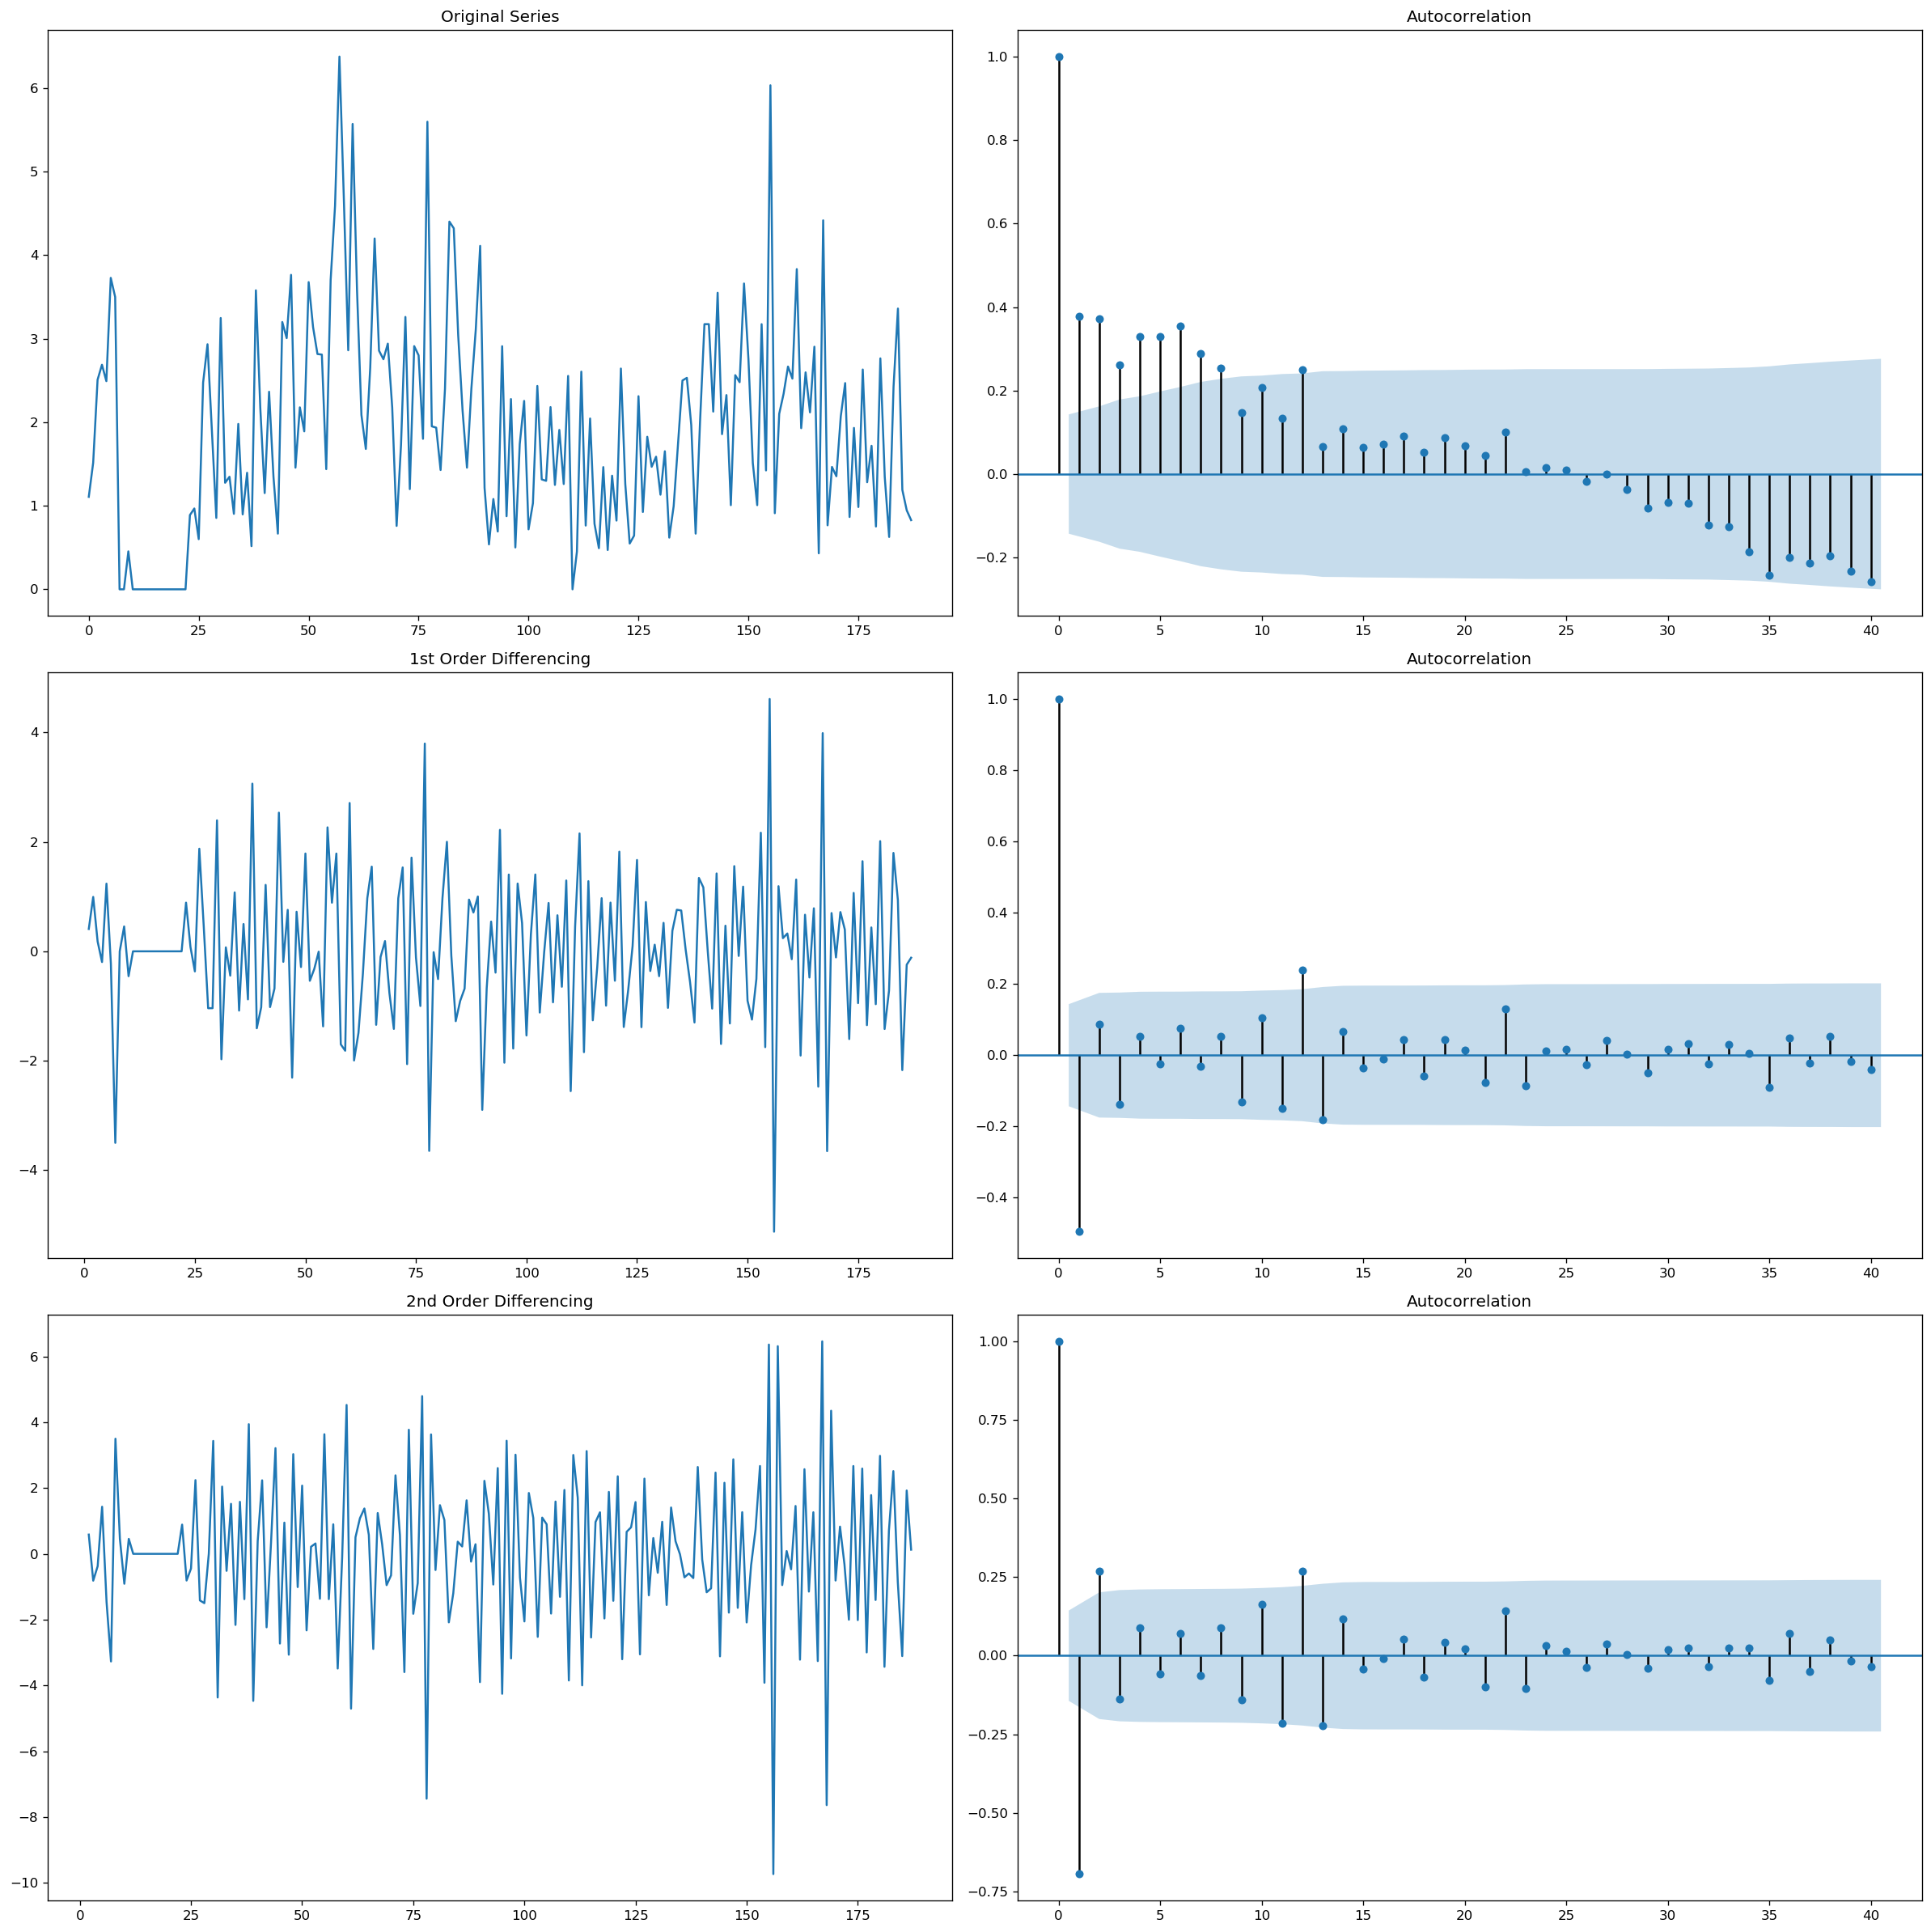

In [95]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})

a = day_level_conversions['pass_through_rate']
# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(a); axes[0, 0].set_title('Original Series')
plot_acf(a, ax=axes[0, 1],lags=40)

# 1st Differencing
axes[1, 0].plot(a.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(a.diff().dropna(), ax=axes[1, 1],lags=40)

# 2nd Differencing
axes[2, 0].plot(a.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(a.diff().diff().dropna(), ax=axes[2, 1],lags=40)

fig.tight_layout()
plt.show()

# Since our lag goes far negative fairly quick, and stretches better for second order differencing

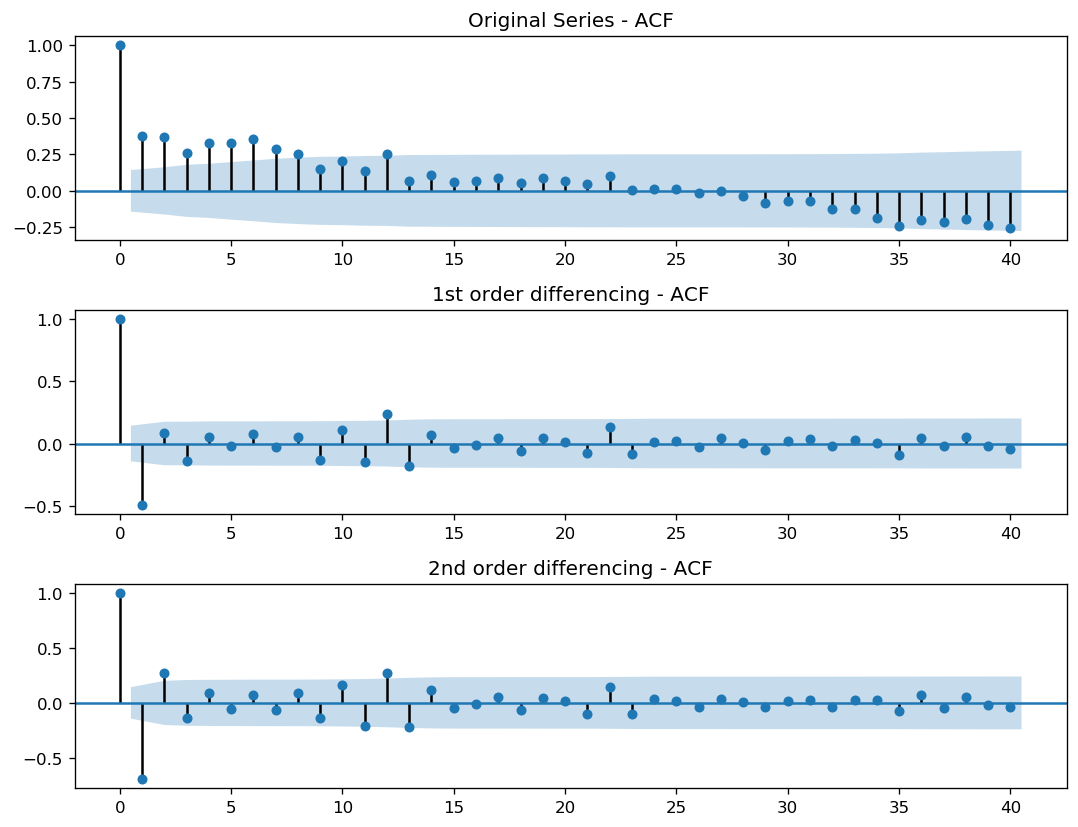

In [96]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

a = day_level_conversions['pass_through_rate']
# Original Series
fig, axes = plt.subplots(3, 1, sharex=False)
#axes[0, 0].plot(a); axes[0, 0].set_title('Original Series')
plot_acf(a, ax=axes[0],lags=40);axes[0].set_title('Original Series - ACF')

# 1st Differencing

plot_acf(a.diff().dropna(), ax=axes[1],lags=40);axes[1].set_title('1st order differencing - ACF')

# 2nd Differencing
plot_acf(a.diff().diff().dropna(), ax=axes[2],lags=40);axes[2].set_title('2nd order differencing - ACF')
fig.tight_layout()
plt.show()

# Since our lag goes far negative fairly quick, and stretches better for second order differencing

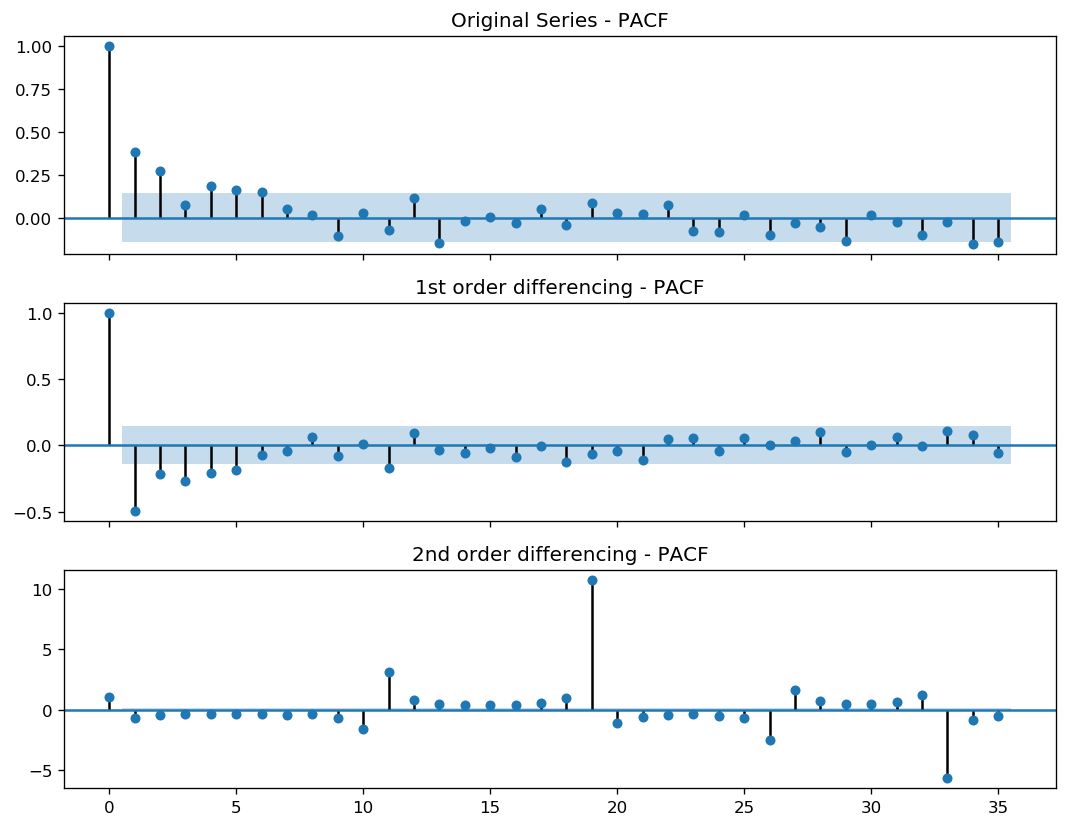

In [97]:
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

a = day_level_conversions['pass_through_rate']
# Original Series
fig, axes = plt.subplots(3, 1, sharex=True)
#axes[0, 0].plot(a); axes[0, 0].set_title('Original Series')
plot_pacf(a, ax=axes[0],lags=35);axes[0].set_title('Original Series - PACF')

# 1st Differencing

plot_pacf(a.diff().dropna(), ax=axes[1],lags=35);axes[1].set_title('1st order differencing - PACF')

# 2nd Differencing
plot_pacf(a.diff().diff().dropna(), ax=axes[2],lags=35);axes[2].set_title('2nd order differencing - PACF')
fig.tight_layout()
plt.show()

# Since our lag goes far negative fairly quick, and stretches better for second order differencing

## Series level findings

The original time series has a very strong correlation with lag1, lag2 and lag 3 of the series.

We will cover differenced series later.

## Running linear model for lags

In [98]:
day_level_conversions_w_lag.head()

Date  sign_ups  confirm_enrollments  pass_through_rate     lag_1  \
3 2019-06-11     186.0                  5.0           2.688172  2.508961   
4 2019-06-12     321.0                  8.0           2.492212  2.688172   
5 2019-06-13     295.0                 11.0           3.728814  2.492212   
6 2019-06-14     200.0                  7.0           3.500000  3.728814   
7 2019-06-15     118.0                  0.0           0.000000  3.500000   

      lag_2     lag_3  
3  1.515152  1.107011  
4  2.508961  1.515152  
5  2.688172  2.508961  
6  2.492212  2.688172  
7  3.728814  2.492212

In [99]:
y = day_level_conversions_w_lag.iloc[:,3]
X = day_level_conversions_w_lag.iloc[:,4:]

## Checking correlation between campaign pairs

In [100]:
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [101]:
corr = X.corr(method='pearson')

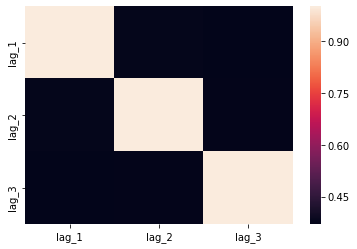

In [102]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

No correlation problem here

In [103]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              167.7
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    3.86e-52
Time:                        21:33:50   Log-Likelihood:                         -293.76
No. Observations:                 185   AIC:                                      593.5
Df Residuals:                     182   BIC:                                      603.2
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Significant variables**: lag_1, lag_2, lag_3

As we can see from the ACF plots, lag_1, lag_2 and lag_3 are all significant variables

## Models with regularization - all campaigns

In [104]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [105]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [106]:
print("Best alpha from 10-fold CV) =",reg.alpha_)

Best alpha from 10-fold CV) = 0.0049332975586764884


In [107]:
## Coefficients

lag_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
lag_coefs.columns = ['lag','coefficient']
lag_coefs

lag  coefficient
0  lag_1      0.36772
1  lag_2      0.35995
2  lag_3      0.18240

# Running linear models for each dimension

We run linear models - OLS, Ridge, Lasso to check for significant instances of each dimension:

Final goal - Create a collection of attributes of a visit that are significant for click throughs between 'sign up' page landing and 'confirm enrollment' page landing

y variable: pass_through_rate

In [108]:
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Campaign

### What do we expect?

First let's explore the behaviour of all campaigns

Text(0.5, 1.0, 'Sessions that came through various campaigns')

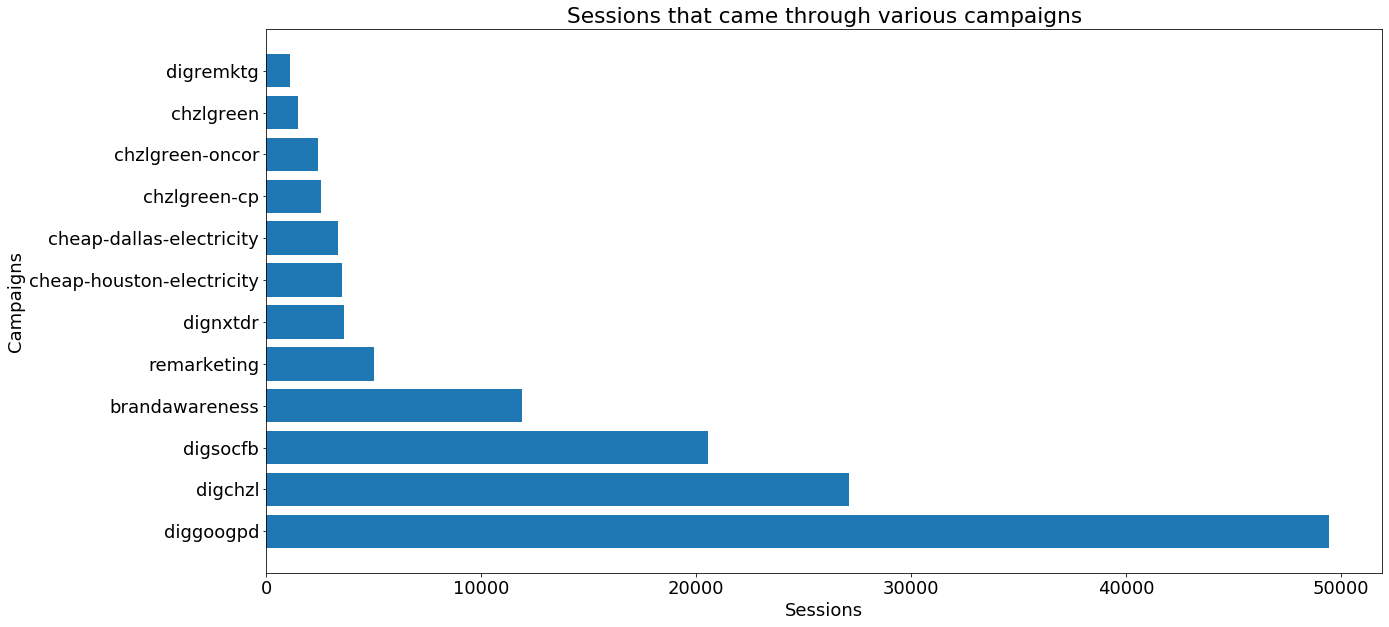

In [109]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})

plt.barh(df_campaign_top['campaign'], df_campaign_top['sessions'])
plt.xlabel("Sessions")
plt.ylabel("Campaigns")
plt.title("Sessions that came through various campaigns")

#df_campaign_top.plot(kind='bar')

We see that:
    
   1. **diggoogpd** offsets all other campaigns
   2. **digchzl** and **digsocfb** are of comparable magnitude
   3. All others contributed to <10000 sessions till date
   
We expect to see campaigns with more sessions as significant predictors of conversion rate.

In [110]:
df_campaign_pivot_w_conversion.head()

brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

            cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

            chzlgreen-oncor  digchzl  diggoogpd  dignxtdr  digremktg  ...  \
Date                                                                  ...   
2019-06-11              0.0      5.0       72.0       7.0        0.0  ...   
2019-06-12              0.0     51.0      101.0      78.0        0.0  ...   
2019-06-13              0.0     19.0      121.0     111.0        0.0  ...   
2019-06-14              0.0      3.0       86.0      41.0        0.0  ...   
2019-06-15              0.0      6.0       55.0      34.0        0.0  ...   

            chzlgreen-oncor_flag  digchzl_flag diggoogpd_flag dignxtdr_flag  \
Date                                                                          
2019-06-11                     0       0_to_10      50_to_100       0_to_10   
2019-06-12                     0     50_to_100           100+     50_to_100   
2019-06-13                     0      10_to_50           100+          100+   
2019-06-14                     0       0_to_10      50_to_100      10_to_50   
2019-06-15                     0       0_to_10      50_to_100      10_to_50   

           digremktg_flag digsocfb_flag remarketing_flag sign_ups  \
Date                                                                
2019-06-11              0       0_to_10                0    186.0   
2019-06-12              0       0_to_10                0    321.0   
2019-06-13              0       0_to_10                0    295.0   
2019-06-14              0       0_to_10                0    200.0   
2019-06-15              0       0_to_10                0    118.0   

           confirm_enrollments pass_through_rate  
Date                                              
2019-06-11                 5.0          2.688172  
2019-06-12                 8.0          2.492212  
2019-06-13                11.0          3.728814  
2019-06-14                 7.0          3.500000  
2019-06-15                 0.0          0.000000  

[5 rows x 27 columns]

In [111]:
y = df_campaign_pivot_w_conversion.iloc[:,-1:]
n = df_campaign_pivot.shape[1]
X = df_campaign_pivot.iloc[:,:int(n/2)]

## Checking correlation between campaign pairs

In [112]:
corr = X.corr(method='pearson')

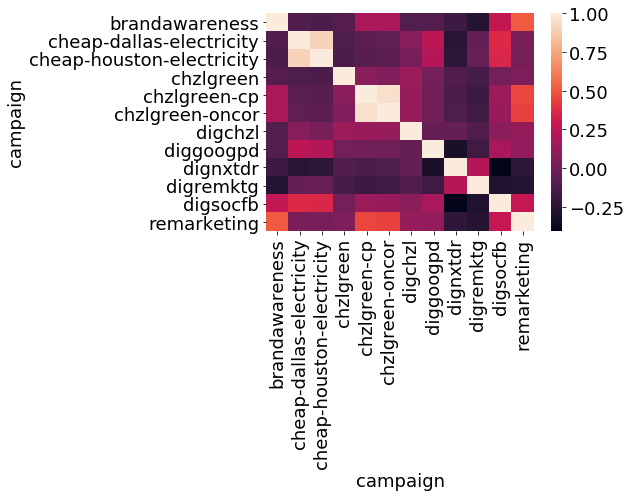

In [113]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Substantial correlation between cheap-electricity campaigns

In [114]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.736
Model:                            OLS   Adj. R-squared (uncentered):              0.718
Method:                 Least Squares   F-statistic:                              40.22
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    9.36e-44
Time:                        21:33:51   Log-Likelihood:                         -293.12
No. Observations:                 185   AIC:                                      610.2
Df Residuals:                     173   BIC:                                      648.9
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

**Significant variables**: diggoogpd, digsocfb

As we saw while pulling data, diggoogpd was throwing off a lot of the others. Let us run another model without diggoogpd.

## Models with regularization - all campaigns

In [115]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [116]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [117]:
print("Best alpha from 10-fold CV) =",reg.alpha_)

Best alpha from 10-fold CV) = 0.7095444657948797


In [118]:
## Coefficients

campaign_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
campaign_coefs.columns = ['campaign','coefficient']
campaign_coefs

campaign  coefficient
0              brandawareness     0.008715
1    cheap-dallas-electricity     0.000000
2   cheap-houston-electricity     0.020387
3                   chzlgreen    -0.000000
4                chzlgreen-cp    -0.000000
5             chzlgreen-oncor     0.000000
6                     digchzl     0.014004
7                   diggoogpd     0.006396
8                    dignxtdr     0.004701
9                   digremktg     0.000000
10                   digsocfb     0.021638
11                remarketing    -0.000000

## Campaign - Without google

In [119]:
df_campaign_pivot_w_conversion_wo_google.head()

brandawareness  cheap-dallas-electricity  \
Date                                                   
2019-06-11             0.0                       0.0   
2019-06-12             0.0                       0.0   
2019-06-13             0.0                       0.0   
2019-06-14             0.0                       0.0   
2019-06-15             0.0                       0.0   

            cheap-houston-electricity  chzlgreen  chzlgreen-cp  \
Date                                                             
2019-06-11                        0.0        0.0           0.0   
2019-06-12                        0.0        0.0           0.0   
2019-06-13                        0.0        0.0           0.0   
2019-06-14                        0.0        0.0           0.0   
2019-06-15                        0.0        0.0           0.0   

            chzlgreen-oncor  digchzl  dignxtdr  digremktg  digsocfb  ...  \
Date                                                                 ...   
2019-06-11              0.0      5.0       7.0        0.0       1.0  ...   
2019-06-12              0.0     51.0      78.0        0.0       1.0  ...   
2019-06-13              0.0     19.0     111.0        0.0       1.0  ...   
2019-06-14              0.0      3.0      41.0        0.0       6.0  ...   
2019-06-15              0.0      6.0      34.0        0.0       7.0  ...   

            chzlgreen-cp_flag chzlgreen-oncor_flag digchzl_flag dignxtdr_flag  \
Date                                                                            
2019-06-11                  0                    0      0_to_10       0_to_10   
2019-06-12                  0                    0    50_to_100     50_to_100   
2019-06-13                  0                    0     10_to_50          100+   
2019-06-14                  0                    0      0_to_10      10_to_50   
2019-06-15                  0                    0      0_to_10      10_to_50   

           digremktg_flag digsocfb_flag remarketing_flag sign_ups  \
Date                                                                
2019-06-11              0       0_to_10                0    186.0   
2019-06-12              0       0_to_10                0    321.0   
2019-06-13              0       0_to_10                0    295.0   
2019-06-14              0       0_to_10                0    200.0   
2019-06-15              0       0_to_10                0    118.0   

           confirm_enrollments pass_through_rate  
Date                                              
2019-06-11                 5.0          2.688172  
2019-06-12                 8.0          2.492212  
2019-06-13                11.0          3.728814  
2019-06-14                 7.0          3.500000  
2019-06-15                 0.0          0.000000  

[5 rows x 25 columns]

In [120]:
y = df_campaign_pivot_w_conversion_wo_google.iloc[:,-1:]
n = df_campaign_pivot_wo_google.shape[1]
X = df_campaign_pivot_wo_google.iloc[:,:int(n/2)]

In [121]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.703
Model:                            OLS   Adj. R-squared (uncentered):              0.684
Method:                 Least Squares   F-statistic:                              37.47
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    3.15e-40
Time:                        21:33:51   Log-Likelihood:                         -304.01
No. Observations:                 185   AIC:                                      630.0
Df Residuals:                     174   BIC:                                      665.4
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

**Significant variables**: digsocfb, digchzl

After removing diggoogpd, we get campaigns from facebook social and choozle as significant. We expected this since the magnitude of their session contributions is much higher than the other 10. (>10000 vs. <10000)

## Models with regularization - campaigns without google

In [122]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [123]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [124]:
print("Best alpha from 10-fold CV) =",reg.alpha_)

Best alpha from 10-fold CV) = 2.154961909656891


In [125]:
## Coefficients

campaign_coefs_clean = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
campaign_coefs_clean.columns = ['campaign','coefficient']
campaign_coefs_clean

campaign  coefficient
0              brandawareness     0.005007
1    cheap-dallas-electricity     0.000000
2   cheap-houston-electricity     0.023088
3                   chzlgreen    -0.000000
4                chzlgreen-cp    -0.000000
5             chzlgreen-oncor     0.000000
6                     digchzl     0.032684
7                    dignxtdr     0.002717
8                   digremktg     0.000000
9                    digsocfb     0.053372
10                remarketing     0.000000

In [126]:
reg.intercept_

0.0

## Campaign findings (With data upto 21-Nov, may change if dates changed)

We took a 2-step approach - 

1. Fit a simple OLS regression to datasets with google info, without google info.

2. Fit a LassoCV regression to datasets with google info, without google info to find best alpha and the values of campaign coefficients after putting L1 penalty in each case.

These are out findings:

1. digital-google-paid and digital-social-facebook came out to be the only significant campaigns in the normal model with beta values, but on applying lassoCV we got cheap-houston-electricity to be the campaign with the highest positive impact (beta = 0.020093 ==> 100 sessions from c-h-e contribute to 2 % higher pass through rate, keeping everything else constant), followed by digsocfb (beta = 0.013373, ==> 100 sessions from digsocfb contribute to 1.3% increase in pass through rate, everything else kept constant), brandawareness(0.7%/100 sessions) and diggoogpd(0.23%/100 sessions)

2. From data without diggoogpd, brandawareness, cheap-houston-electricity, digchzl, dignxtdr and digsocfb are significant campaigns.

## Gender

### What do we expect?

First let's explore the behaviour of all campaigns

In [127]:
df_gender_pivot_w_conversion.head()

female   male female_flag  male_flag  sign_ups  \
Date                                                         
2019-06-11     0.0   58.0           0  50_to_100     186.0   
2019-06-12    75.0  137.0   50_to_100       100+     321.0   
2019-06-13    66.0  103.0   50_to_100       100+     295.0   
2019-06-14    43.0   46.0    10_to_50   10_to_50     200.0   
2019-06-15     6.0    6.0     0_to_10    0_to_10     118.0   

            confirm_enrollments  pass_through_rate  
Date                                                
2019-06-11                  5.0           2.688172  
2019-06-12                  8.0           2.492212  
2019-06-13                 11.0           3.728814  
2019-06-14                  7.0           3.500000  
2019-06-15                  0.0           0.000000

In [128]:
## Count of sessions for male and female - both are significant

In [129]:
y = df_gender_pivot_w_conversion.iloc[:,-1:]
n = df_gender_pivot.shape[1]
X = df_gender_pivot_w_conversion.iloc[:,:int(n/2)]

In [130]:
results = sm.OLS(y, X).fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.689
Model:                            OLS   Adj. R-squared (uncentered):              0.685
Method:                 Least Squares   F-statistic:                              201.2
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    7.86e-47
Time:                        21:33:51   Log-Likelihood:                         -307.28
No. Observations:                 184   AIC:                                      618.6
Df Residuals:                     182   BIC:                                      625.0
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Significant variables**: male and female

Sessions coming from both males and females are significant, with a projected pass through rate increase of 1.17% for every 100 sessions from females and 0.7% increase for 100 sessions from males (without intercept)

In [131]:
y = df_gender_pivot_w_conversion.iloc[:,-1:]
n = df_gender_pivot.shape[1]
X = df_gender_pivot_w_conversion.iloc[:,:int(n/2)]

## Models with regularization

In [132]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=True).fit(X, y)

In [133]:
print("Best alpha from 10-fold CV) =",reg.alpha_)

Best alpha from 10-fold CV) = 0.03125133665841451


In [134]:
## Coefficients

gender_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
gender_coefs.columns = ['gender','coefficient']
gender_coefs

gender  coefficient
0  female     0.006446
1    male     0.002720

In [135]:
reg.intercept_

1.077316361625114

## Gender findings (With data upto 21-Nov, may change if dates changed)

We took a 2-step approach - 

1. Fit a simple OLS regression to numerical columns of number of sessions from each gender

2. Fit a LassoCV regression to numerical columns of number of sessions from each gender

These are out findings:

1. Both males and females are significant contributors to pass through rate, with every 100 sessions increasing from females adding more % in pass through rate vs. the same increase in sessions from males (consistent result from both least squares and lasso)

# Age

In [136]:
y = df_age_pivot_w_conversion.iloc[:,-1:]
n = df_age_pivot.shape[1]
X = df_age_pivot.iloc[:,:int(n/2)]

## Checking correlation between age pairs

In [137]:
corr = X.corr(method='pearson')

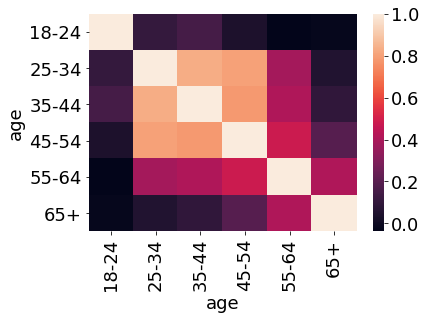

In [138]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Correlation between 25-34 and 35-44

In [139]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.578
Model:                            OLS   Adj. R-squared (uncentered):              0.562
Method:                 Least Squares   F-statistic:                              36.57
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    1.14e-27
Time:                        21:33:51   Log-Likelihood:                         -306.91
No. Observations:                 166   AIC:                                      625.8
Df Residuals:                     160   BIC:                                      644.5
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Significant age groups**: 25-34, 35-44, 45-54

25-34 and 35-44 show positive effects on pass through rate, whereas 45-54 session show a negative impact.

## Models with regularization - all ages

In [140]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [141]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [142]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 0.16621096914590533


In [143]:
## Coefficients

age_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
age_coefs.columns = ['age','coefficient']
age_coefs

age  coefficient
0  18-24    -0.000000
1  25-34     0.026268
2  35-44     0.018877
3  45-54    -0.033884
4  55-64     0.015883
5    65+     0.085240

## Age findings (With data upto 21-Nov, may change if dates changed)

We took a 2-step approach - 

1. Fit a simple OLS regression to numerical columns of number of sessions from each age group

2. Fit a LassoCV regression to numerical columns of number of sessions from each age group

These are our findings:

1. 25-34, 35-44 and 55-64 show positive effects on pass through rate, whereas 45-54 session show a negative impact

# Affinity

In [144]:
y = df_affinity_pivot_w_conversion.iloc[:,-1:]
n = df_affinity_pivot.shape[1]
X = df_affinity_pivot.iloc[:,:int(n/2)]

## Checking correlation between affinity pairs

In [145]:
corr = X.corr(method='pearson')

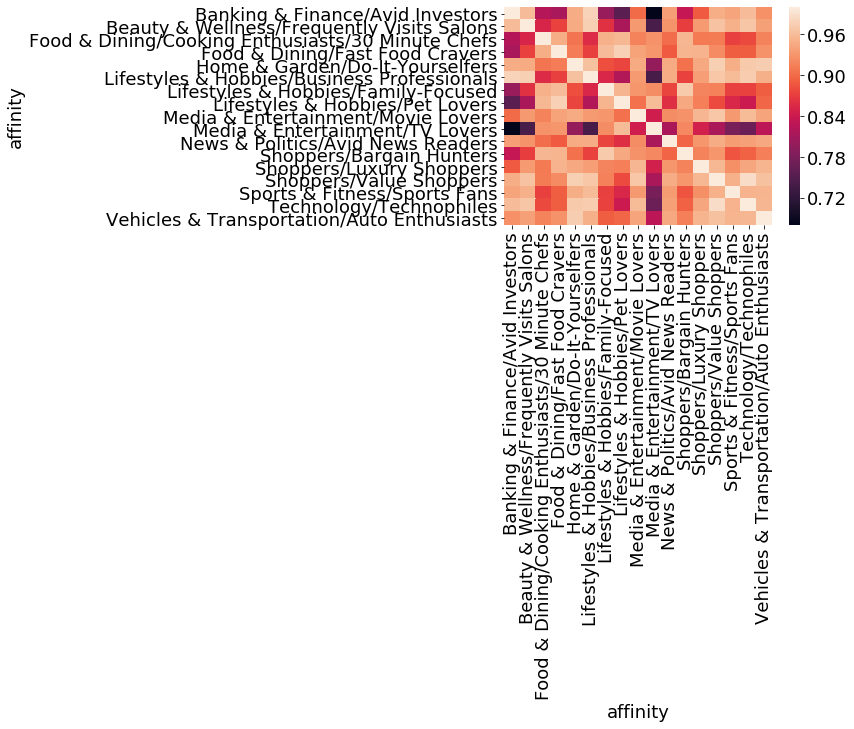

In [146]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Many highly correlated affinities.

In [147]:
corr

affinity                                           Banking & Finance/Avid Investors  \
affinity                                                                              
Banking & Finance/Avid Investors                                           1.000000   
Beauty & Wellness/Frequently Visits Salons                                 0.960112   
Food & Dining/Cooking Enthusiasts/30 Minute Chefs                          0.821612   
Food & Dining/Fast Food Cravers                                            0.813863   
Home & Garden/Do-It-Yourselfers                                            0.948302   
Lifestyles & Hobbies/Business Professionals                                0.979206   
Lifestyles & Hobbies/Family-Focused                                        0.802788   
Lifestyles & Hobbies/Pet Lovers                                            0.756276   
Media & Entertainment/Movie Lovers                                         0.900567   
Media & Entertainment/TV Lovers                                            0.680541   
News & Politics/Avid News Readers                                          0.937343   
Shoppers/Bargain Hunters                                                   0.834516   
Shoppers/Luxury Shoppers                                                   0.889599   
Shoppers/Value Shoppers                                                    0.949868   
Sports & Fitness/Sports Fans                                               0.942242   
Technology/Technophiles                                                    0.960638   
Vehicles & Transportation/Auto Enthusiasts                                 0.926695   

affinity                                           Beauty & Wellness/Frequently Visits Salons  \
affinity                                                                                        
Banking & Finance/Avid Investors                                                     0.960112   
Beauty & Wellness/Frequently Visits Salons                                           1.000000   
Food & Dining/Cooking Enthusiasts/30 Minute Chefs                                    0.852069   
Food & Dining/Fast Food Cravers                                                      0.874215   
Home & Garden/Do-It-Yourselfers                                                      0.946997   
Lifestyles & Hobbies/Business Professionals                                          0.975317   
Lifestyles & Hobbies/Family-Focused                                                  0.862044   
Lifestyles & Hobbies/Pet Lovers                                                      0.815206   
Media & Entertainment/Movie Lovers                                                   0.933765   
Media & Entertainment/TV Lovers                                                      0.742460   
News & Politics/Avid News Readers                                                    0.928967   
Shoppers/Bargain Hunters                                                             0.870383   
Shoppers/Luxury Shoppers                                                             0.934529   
Shoppers/Value Shoppers                                                              0.965442   
Sports & Fitness/Sports Fans                                                         0.951889   
Technology/Technophiles                                                              0.968272   
Vehicles & Transportation/Auto Enthusiasts                                           0.938281   

affinity                                           Food & Dining/Cooking Enthusiasts/30 Minute Chefs  \
affinity                                                                                               
Banking & Finance/Avid Investors                                                            0.821612   
Beauty & Wellness/Frequently Visits Salons                                                  0.852069   
Food & Dining/Cooking Enthusiasts/30 Minute Chefs                                     

## Multicolinearity

Upon eyeballing, the lowest correlation in 0.722 -- all others are above, and hence the OLS regression is likely to produce poor results

In [148]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.760
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              31.24
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    3.51e-43
Time:                        21:33:52   Log-Likelihood:                         -284.47
No. Observations:                 185   AIC:                                      602.9
Df Residuals:                     168   BIC:                                      657.7
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--

## Models with regularization - all affinitys

In [149]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [150]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [151]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 14.621075293579931


In [152]:
## Coefficients

affinity_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
affinity_coefs.columns = ['affinity','coefficient']
affinity_coefs

affinity  coefficient
0                    Banking & Finance/Avid Investors     0.000000
1          Beauty & Wellness/Frequently Visits Salons     0.000000
2   Food & Dining/Cooking Enthusiasts/30 Minute Chefs     0.000000
3                     Food & Dining/Fast Food Cravers     0.003223
4                     Home & Garden/Do-It-Yourselfers     0.000000
5         Lifestyles & Hobbies/Business Professionals     0.000000
6                 Lifestyles & Hobbies/Family-Focused     0.000000
7                     Lifestyles & Hobbies/Pet Lovers     0.000000
8                  Media & Entertainment/Movie Lovers     0.000000
9                     Media & Entertainment/TV Lovers     0.000000
10                  News & Politics/Avid News Readers     0.000000
11                           Shoppers/Bargain Hunters     0.000000
12                           Shoppers/Luxury Shoppers     0.000000
13                            Shoppers/Value Shoppers     0.007822
14                       Sports & Fitness/Sports Fans     0.000000
15                            Technology/Technophiles     0.000000
16         Vehicles & Transportation/Auto Enthusiasts     0.000000

## Affinity findings (With data upto 21-Nov, may change if dates changed)

1. Most affinity categories are highly correlated, hinting at a multicolinearity issue and thus rendering OLS results virtually useless.

2. We use Lasso to circumvent this issue, and find that customers with affinities towards **Food & Dining/Fast Food Cravers** and **Shoppers/Value Shoppers** show a positive effect on the pass through rate, with all others having coeficients 0.

# Language

In [153]:
y = df_language_pivot_w_conversion.iloc[:,-1:]
n = df_language_pivot.shape[1]
X = df_language_pivot.iloc[:,:int(n/2)]

## Checking correlation between language pairs

In [154]:
corr = X.corr(method='pearson')

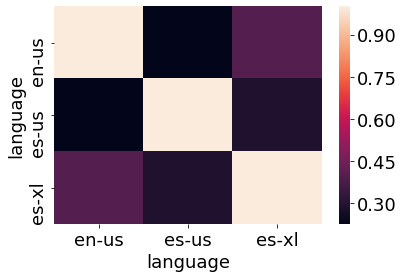

In [155]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

Many highly correlated affinities.

In [156]:
corr

language     en-us     es-us     es-xl
language                              
en-us     1.000000  0.227821  0.398408
es-us     0.227821  1.000000  0.292405
es-xl     0.398408  0.292405  1.000000

In [157]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.724
Model:                            OLS   Adj. R-squared (uncentered):              0.719
Method:                 Least Squares   F-statistic:                              158.7
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    1.44e-50
Time:                        21:33:52   Log-Likelihood:                         -297.44
No. Observations:                 185   AIC:                                      600.9
Df Residuals:                     182   BIC:                                      610.6
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Significant language groups**: en-us

## Models with regularization - all languages

In [158]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [159]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [160]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 15.764830303044803


In [161]:
## Coefficients

language_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
language_coefs.columns = ['language','coefficient']
language_coefs

language  coefficient
0    en-us     0.002943
1    es-us    -0.000000
2    es-xl     0.000000

In [162]:
reg.intercept_

0.0

## Language findings (With data upto 21-Nov, may change if dates changed)

1. We see only sessions in english contributing positively to pass through rate through both OLS and Lasso

# City

In [163]:
y = df_city_pivot_w_conversion.iloc[:,-1:]
n = df_city_pivot.shape[1]
X = df_city_pivot.iloc[:,:int(n/2)]

## Checking correlation between city pairs

In [164]:
corr = X.corr(method='pearson')

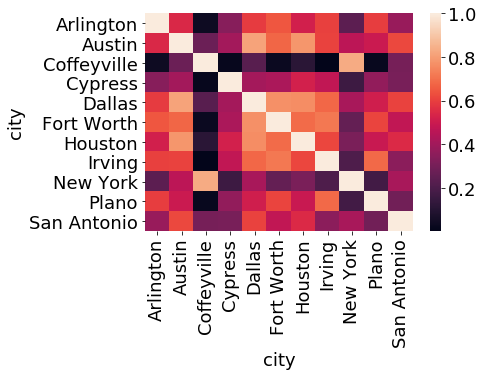

In [165]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Multicolinearity

No alarming correlation among any pairs

In [166]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.748
Model:                            OLS   Adj. R-squared (uncentered):              0.732
Method:                 Least Squares   F-statistic:                              46.95
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    2.71e-46
Time:                        21:33:52   Log-Likelihood:                         -288.87
No. Observations:                 185   AIC:                                      599.7
Df Residuals:                     174   BIC:                                      635.2
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

**Significant city groups**: Plano

## Models with regularization - all citys

In [167]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [168]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [169]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 0.31387329945668213


In [170]:
## Coefficients

city_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
city_coefs.columns = ['city','coefficient']
city_coefs

city  coefficient
0     Arlington     0.037679
1        Austin     0.004246
2   Coffeyville     0.000000
3       Cypress     0.001772
4        Dallas     0.001778
5    Fort Worth     0.012003
6       Houston     0.000969
7        Irving     0.000000
8      New York    -0.000000
9         Plano     0.044966
10  San Antonio     0.003040

## City findings (With data upto 21-Nov, may change if dates changed)

1. Significant cities contributing to pass through rate are **Cypress**, **Plano**, **Arlington**, **Dallas**, **Fort Worth** (in decreasing order of positive impact on the pass_through_rate) from LassoCV, with **Houston actually negatively** affecting it.

# Network

In [171]:
y = df_network_treated_pivot_w_conversion.iloc[:,-1:]
n = df_network_treated_pivot.shape[1]
X = df_network_treated_pivot.iloc[:,:int(n/2)]

## Checking correlation between city pairs

In [172]:
corr = X.corr(method='pearson')

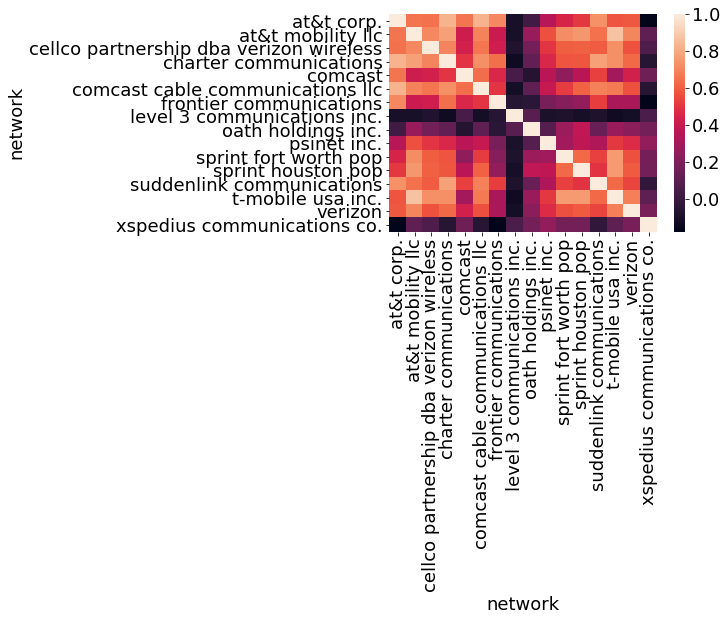

In [173]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [174]:
corr

network                                  at&t corp.  at&t mobility llc  \
network                                                                  
at&t corp.                                 1.000000           0.659253   
at&t mobility llc                          0.659253           1.000000   
cellco partnership dba verizon wireless    0.651186           0.708683   
charter communications                     0.825965           0.771262   
comcast                                    0.659349           0.421431   
comcast cable communications llc           0.828202           0.694833   
frontier communications                    0.709947           0.408500   
level 3 communications inc.               -0.099827          -0.097270   
oath holdings inc.                         0.028160           0.274681   
psinet inc.                                0.356964           0.571524   
sprint fort worth pop                      0.449635           0.724271   
sprint houston pop                         0.513499           0.750158   
suddenlink communications                  0.731824           0.649203   
t-mobile usa inc.                          0.578821           0.873501   
verizon                                    0.587210           0.704608   
xspedius communications co.               -0.171481           0.116349   

network                                  cellco partnership dba verizon wireless  \
network                                                                            
at&t corp.                                                              0.651186   
at&t mobility llc                                                       0.708683   
cellco partnership dba verizon wireless                                 1.000000   
charter communications                                                  0.698312   
comcast                                                                 0.436663   
comcast cable communications llc                                        0.664898   
frontier communications                                                 0.423022   
level 3 communications inc.                                            -0.072854   
oath holdings inc.                                                      0.176295   
psinet inc.                                                             0.503025   
sprint fort worth pop                                                   0.601978   
sprint houston pop                                                      0.609481   
suddenlink communications                                               0.598755   
t-mobile usa inc.                                                       0.727155   
verizon                                                                 0.575047   
xspedius communications co.                                             0.066418   

network                                  charter communications   comcast  \
network                                                                     
at&t corp.                                             0.825965  0.659349   
at&t mobility llc                                      0.771262  0.421431   
cellco partnership dba verizon wireless                0.698312  0.436663   
charter communications                                 1.000000  0.500947   
comcast                                                0.500947  1.000000   
comcast cable communications llc                       0.725220  0.641226   
frontier communications                                0.643975  0.459995   
level 3 communications inc.                           -0.131257  0.046660   
oath holdings inc.                                     0.122943 -0.061908   
psinet inc.                                            0.458997  0.363821   
sprint fort worth pop                                  0.579766  0.249103   
sprint houston pop                                     0.584134  0.362374   
suddenlink communications                              0.775150  0.531913   

## Multicolinearity

There is some collinearity between column pairs (at&t corp. and charter communications @ 0.83, at&t corp. and comcast cable communications llc @ 0.82)

We will rely on the lasso outputs

In [175]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.783
Model:                            OLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              38.14
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    1.28e-47
Time:                        21:33:53   Log-Likelihood:                         -274.99
No. Observations:                 185   AIC:                                      582.0
Df Residuals:                     169   BIC:                                      633.5
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------

## Models with regularization - all citys

In [176]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [177]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [178]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 7.336499613649201


In [179]:
## Coefficients

network_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
network_coefs.columns = ['network','coefficient']
network_coefs

network  coefficient
0                                at&t corp.     0.017414
1                         at&t mobility llc     0.000000
2   cellco partnership dba verizon wireless     0.000000
3                    charter communications     0.001106
4                                   comcast     0.000000
5          comcast cable communications llc     0.000000
6                   frontier communications     0.000000
7               level 3 communications inc.     0.000000
8                        oath holdings inc.     0.000000
9                               psinet inc.     0.000000
10                    sprint fort worth pop     0.000000
11                       sprint houston pop    -0.000000
12                suddenlink communications     0.000000
13                        t-mobile usa inc.     0.000000
14                                  verizon     0.000000
15              xspedius communications co.    -0.000000

In [180]:
reg.intercept_

0.0

## Network findings (With data upto 21-Nov, may change if dates changed)

1. Significant networks contributing to pass through rate are **at&t corp.**, **charter communications** (in decreasing order of positive impact on the pass_through_rate) from LassoCV

2. LR points towards **cellco partnership dba verizon wireless** too

# Device Brands

In [181]:
y = df_device_brand_pivot_w_conversion.iloc[:,-1:]
n = df_device_brand_pivot.shape[1]
X = df_device_brand_pivot.iloc[:,:int(n/2)]

## Checking correlation between device brand pairs

In [182]:
corr = X.corr(method='pearson')

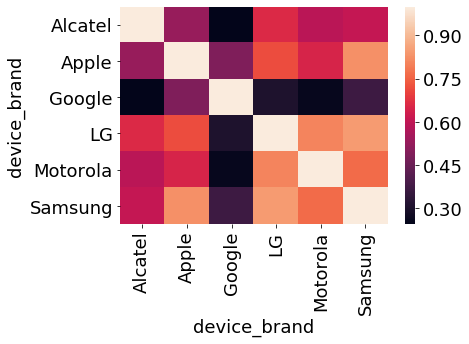

In [183]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [184]:
corr

device_brand   Alcatel     Apple    Google        LG  Motorola   Samsung
device_brand                                                            
Alcatel       1.000000  0.529786  0.245920  0.659468  0.591527  0.609150
Apple         0.529786  1.000000  0.489232  0.719187  0.647459  0.827307
Google        0.245920  0.489232  1.000000  0.306731  0.260322  0.368843
LG            0.659468  0.719187  0.306731  1.000000  0.808088  0.846299
Motorola      0.591527  0.647459  0.260322  0.808088  1.000000  0.765180
Samsung       0.609150  0.827307  0.368843  0.846299  0.765180  1.000000

## Multicolinearity

There is some collinearity between Samsung and Apple

We will rely on the lasso outputs

In [185]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.725
Model:                            OLS   Adj. R-squared (uncentered):              0.716
Method:                 Least Squares   F-statistic:                              78.78
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    1.31e-47
Time:                        21:33:53   Log-Likelihood:                         -296.83
No. Observations:                 185   AIC:                                      605.7
Df Residuals:                     179   BIC:                                      625.0
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Models with regularization - all device brands

In [186]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [187]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [188]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 5.571701840977287


In [189]:
## Coefficients

device_brand_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
device_brand_coefs.columns = ['device_brand','coefficient']
device_brand_coefs

device_brand  coefficient
0      Alcatel    -0.000000
1        Apple     0.010948
2       Google    -0.000000
3           LG     0.000000
4     Motorola     0.000000
5      Samsung     0.000000

## Device Brand findings (With data upto 21-Nov, may change if dates changed)

1. Significant device brands contributing to pass through rate are **Samsung**, **Apple** (in decreasing order of positive impact on the pass_through_rate) from LassoCV, with **Google** actually showing a negative effect on the pass_through_rate

# OS

In [190]:
y = df_os_pivot_w_conversion.iloc[:,-1:]
n = df_os_pivot.shape[1]
X = df_os_pivot.iloc[:,:int(n/2)]

## Checking correlation between device brand pairs

In [191]:
corr = X.corr(method='pearson')

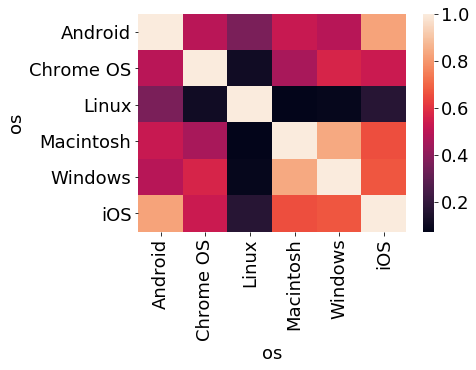

In [192]:
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [193]:
corr

os          Android  Chrome OS     Linux  Macintosh   Windows       iOS
os                                                                     
Android    1.000000   0.497325  0.362396   0.530108  0.491010  0.829824
Chrome OS  0.497325   1.000000  0.117405   0.458766  0.568326  0.535831
Linux      0.362396   0.117405  1.000000   0.075626  0.086993  0.172950
Macintosh  0.530108   0.458766  0.075626   1.000000  0.844021  0.657105
Windows    0.491010   0.568326  0.086993   0.844021  1.000000  0.671619
iOS        0.829824   0.535831  0.172950   0.657105  0.671619  1.000000

## Multicolinearity (With data upto 21-Nov, may change if dates changed)

There is some collinearity between iOS and android is 0.84, same as that between windows and macintosh.

We will majorly rely on the lasso outputs to make sure we handle this.

In [194]:
model = sm.OLS(y, X.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:      pass_through_rate   R-squared (uncentered):                   0.739
Model:                            OLS   Adj. R-squared (uncentered):              0.730
Method:                 Least Squares   F-statistic:                              84.26
Date:                Fri, 13 Dec 2019   Prob (F-statistic):                    1.66e-49
Time:                        21:33:54   Log-Likelihood:                         -292.28
No. Observations:                 185   AIC:                                      596.6
Df Residuals:                     179   BIC:                                      615.9
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

**Significant OS groups**: Macintosh

From OLS, we see significant OS only as only Macintosh, with iOS coming in as almost significant.

## Models with regularization - all device brands

In [195]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
import sklearn

In [196]:
#Fitting LassoCV
reg = LassoCV(alphas=None, cv=10, max_iter=10000, fit_intercept=False).fit(X, y)

In [197]:
print("Best alpha from 10-fold CV =",reg.alpha_)

Best alpha from 10-fold CV = 15.953753633615152


In [198]:
## Coefficients

os_coefs = pd.DataFrame(pd.concat([pd.Series(list(X.columns)), pd.Series(list(reg.coef_))],axis=1))
os_coefs.columns = ['os','coefficient']
os_coefs

os  coefficient
0    Android     0.000000
1  Chrome OS     0.000000
2      Linux     0.000000
3  Macintosh     0.000000
4    Windows     0.002863
5        iOS     0.006648

In [199]:
reg.intercept_

0.0

## OS findings (With data upto 21-Nov, may change if dates changed)

1. Significant device brands contributing to pass through rate are **Macintosh**, **iOS**, **Linux** and **Android** (in decreasing order of positive impact on the pass_through_rate) from LassoCV, with **Windows** actually showing a negative effect on the pass_through_rate

# Beta values - (With data upto 21-Nov, may change if dates changed)

## Campaigns

brandawareness    0.012007

cheap-dallas-electricity    0.000000

cheap-houston-electricity    0.019417

chzlgreen    -0.000000

chzlgreen-cp    0.000000

chzlgreen-oncor    0.000000

digchzl    0.012299

diggoogpd    0.006291

dignxtdr    0.005530

digremktg    0.000000

digsocfb    0.028091

remarketing    -0.000000


## Age - all

## Gender - all

## Affinity

	affinity	coefficient
0	Banking & Finance/Avid Investors	0.000000

1	Beauty & Wellness/Frequently Visits Salons	0.000000

2	Food & Dining/Cooking Enthusiasts/30 Minute Chefs	0.000000

3	Food & Dining/Fast Food Cravers	0.009610

4	Home & Garden/Do-It-Yourselfers	0.000000

5	Lifestyles & Hobbies/Business Professionals	0.000000

6	Lifestyles & Hobbies/Family-Focused	0.000000

7	Lifestyles & Hobbies/Pet Lovers	0.000000

8	Media & Entertainment/Movie Lovers	0.000000

9	Media & Entertainment/TV Lovers	0.000000

10	News & Politics/Avid News Readers	0.000000

11	Shoppers/Bargain Hunters	0.000000

12	Shoppers/Luxury Shoppers	0.000000

13	Shoppers/Value Shoppers	0.002999

14	Sports & Fitness/Sports Fans	0.000000

15	Technology/Technophiles	0.000000

16	Travel/Travel Buffs	0.000000

17	Vehicles & Transportation/Auto Enthusiasts	0.000000


## Language 


    language	coefficient
0	en-us	0.003205

1	es-us	0.000000

2	es-xl	0.000000

## City

	city	coefficient
0	Arlington	0.023461

1	Austin	-0.000000

2	Coffeyville	0.000000

3	Cypress	0.000000

4	Dallas	0.009378

5	Fort Worth	0.008013

6	Houston	0.000000

7	Irving	0.000000

8	New York	0.000000

9	Plano	0.030931

10	San Antonio	0.000000

## Network

	network	coefficient
0	at&t corp.	0.016278

1	at&t mobility llc	0.000000

2	cellco partnership dba verizon wireless	0.000000

3	charter communications	0.003496

4	comcast	0.000000

5	comcast cable communications llc	0.000000

6	frontier communications	0.000000

7	level 3 communications inc.	0.000000

8	oath holdings inc.	0.000000

9	psinet inc.	0.000000

10	sprint fort worth pop	0.000000

11	sprint houston pop	0.000000

12	suddenlink communications	0.000000

13	t-mobile usa inc.	0.000000

14	xspedius communications co.	-0.000000

## Device Brand

    device_brand	coefficient
    
0	Apple	0.008325

1	Google	-0.020843

2	LG	0.000000

3	Motorola	0.000000

4	Samsung	0.009076


## OS

    os	coefficient
0	Android	0.000653

1	Chrome OS	0.000000

2	Linux	0.002048

3	Macintosh	0.024753

4	Windows	-0.001818

5	iOS	0.006445


## Creating dataset for Aggregate methods

Two step process:

1. For each dimension, pull values of non-zero coefficient instances

2. Pull values from pivots for those columns and keep joining

In [200]:
sig_campaign = []

for i in range(len(campaign_coefs.iloc[campaign_coefs.coefficient.nonzero()[0]].campaign.values)):
        sig_campaign.append(campaign_coefs.iloc[campaign_coefs.coefficient.nonzero()[0]].campaign.values[i])
        
sig_campaign

['brandawareness',
 'cheap-houston-electricity',
 'digchzl',
 'diggoogpd',
 'dignxtdr',
 'digsocfb']

In [201]:
df_agg_main = df_campaign_pivot[sig_campaign]
df_agg_main.head()

campaign    brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

campaign    dignxtdr  digsocfb  
Date                            
2019-06-11       7.0       1.0  
2019-06-12      78.0       1.0  
2019-06-13     111.0       1.0  
2019-06-14      41.0       6.0  
2019-06-15      34.0       7.0

In [202]:
sig_age = []

for i in range(len(age_coefs.iloc[age_coefs.coefficient.nonzero()[0]].age.values)):
        sig_age.append(age_coefs.iloc[age_coefs.coefficient.nonzero()[0]].age.values[i])
        
sig_age

['25-34', '35-44', '45-54', '55-64', '65+']

In [203]:
df_agg_main = df_agg_main.merge(df_age_pivot[sig_age], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  65+  
Date                                                             
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  0.0  
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  0.0  
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  0.0  
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  0.0  
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  NaN

In [204]:
sig_gender = []

for i in range(len(gender_coefs.iloc[gender_coefs.coefficient.nonzero()[0]].gender.values)):
        sig_gender.append(gender_coefs.iloc[gender_coefs.coefficient.nonzero()[0]].gender.values[i])
        
sig_gender

['female', 'male']

In [205]:
df_agg_main = df_agg_main.merge(df_gender_pivot[sig_gender], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  65+  female   male  
Date                                                                            
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  0.0     0.0   58.0  
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  0.0    75.0  137.0  
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  0.0    66.0  103.0  
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  0.0    43.0   46.0  
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  NaN     6.0    6.0

In [206]:
sig_affinity = []

for i in range(len(affinity_coefs.iloc[affinity_coefs.coefficient.nonzero()[0]].affinity.values)):
        sig_affinity.append(affinity_coefs.iloc[affinity_coefs.coefficient.nonzero()[0]].affinity.values[i])
        
sig_affinity

['Food & Dining/Fast Food Cravers', 'Shoppers/Value Shoppers']

In [207]:
df_agg_main = df_agg_main.merge(df_affinity_pivot[sig_affinity], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  65+  female  \
Date                                                                      
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  0.0     0.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  0.0    75.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  0.0    66.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  0.0    43.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  NaN     6.0   

             male  Food & Dining/Fast Food Cravers  Shoppers/Value Shoppers  
Date                                                                         
2019-06-11   58.0                             74.0                    111.0  
2019-06-12  137.0                            136.0                    188.0  
2019-06-13  103.0                            104.0                    137.0  
2019-06-14   46.0                             67.0                     86.0  
2019-06-15    6.0                             41.0                     49.0

In [208]:
sig_language = []

for i in range(len(language_coefs.iloc[language_coefs.coefficient.nonzero()[0]].language.values)):
        sig_language.append(language_coefs.iloc[language_coefs.coefficient.nonzero()[0]].language.values[i])
        
sig_language

['en-us']

In [209]:
df_agg_main = df_agg_main.merge(df_language_pivot[sig_language], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  65+  female  \
Date                                                                      
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  0.0     0.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  0.0    75.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  0.0    66.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  0.0    43.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  NaN     6.0   

             male  Food & Dining/Fast Food Cravers  Shoppers/Value Shoppers  \
Date                                                                          
2019-06-11   58.0                             74.0                    111.0   
2019-06-12  137.0                            136.0                    188.0   
2019-06-13  103.0                            104.0                    137.0   
2019-06-14   46.0                             67.0                     86.0   
2019-06-15    6.0                             41.0                     49.0   

            en-us  
Date               
2019-06-11  362.0  
2019-06-12  603.0  
2019-06-13  506.0  
2019-06-14  333.0  
2019-06-15  180.0

In [210]:
sig_city = []

for i in range(len(city_coefs.iloc[city_coefs.coefficient.nonzero()[0]].city.values)):
        sig_city.append(city_coefs.iloc[city_coefs.coefficient.nonzero()[0]].city.values[i])
        
sig_city

['Arlington',
 'Austin',
 'Cypress',
 'Dallas',
 'Fort Worth',
 'Houston',
 'Plano',
 'San Antonio']

In [211]:
df_agg_main = df_agg_main.merge(df_city_pivot[sig_city], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  \
Date                                                        ...   
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...   

            Shoppers/Value Shoppers  en-us  Arlington  Austin  Cypress  \
Date                                                                     
2019-06-11                    111.0  362.0        7.0    13.0      3.0   
2019-06-12                    188.0  603.0       13.0    17.0      2.0   
2019-06-13                    137.0  506.0       11.0    10.0     12.0   
2019-06-14                     86.0  333.0        4.0    11.0      2.0   
2019-06-15                     49.0  180.0        5.0     6.0      3.0   

            Dallas  Fort Worth  Houston  Plano  San Antonio  
Date                                                         
2019-06-11    40.0        10.0    128.0    9.0          2.0  
2019-06-12    78.0        16.0    133.0   27.0          4.0  
2019-06-13    82.0        22.0    157.0    7.0          1.0  
2019-06-14    35.0        10.0    121.0    3.0          7.0  
2019-06-15    26.0        12.0     50.0    4.0          2.0  

[5 rows x 24 columns]

In [212]:
sig_network = []

for i in range(len(network_coefs.iloc[network_coefs.coefficient.nonzero()[0]].network.values)):
        sig_network.append(network_coefs.iloc[network_coefs.coefficient.nonzero()[0]].network.values[i])
        
sig_network

['at&t corp.', 'charter communications']

In [213]:
df_agg_main = df_agg_main.merge(df_network_pivot[sig_network], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  Arlington  \
Date                                                        ...              
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...        7.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...       13.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...       11.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...        4.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...        5.0   

            Austin  Cypress  Dallas  Fort Worth  Houston  Plano  San Antonio  \
Date                                                                           
2019-06-11    13.0      3.0    40.0        10.0    128.0    9.0          2.0   
2019-06-12    17.0      2.0    78.0        16.0    133.0   27.0          4.0   
2019-06-13    10.0     12.0    82.0        22.0    157.0    7.0          1.0   
2019-06-14    11.0      2.0    35.0        10.0    121.0    3.0          7.0   
2019-06-15     6.0      3.0    26.0        12.0     50.0    4.0          2.0   

            at&t corp.  charter communications  
Date                                            
2019-06-11        20.0                     9.0  
2019-06-12        34.0                    20.0  
2019-06-13        27.0                    20.0  
2019-06-14         9.0                    14.0  
2019-06-15        10.0                     7.0  

[5 rows x 26 columns]

In [214]:
sig_device_brand = []

for i in range(len(device_brand_coefs.iloc[device_brand_coefs.coefficient.nonzero()[0]].device_brand.values)):
        sig_device_brand.append(device_brand_coefs.iloc[device_brand_coefs.coefficient.nonzero()[0]].device_brand.values[i])
        
sig_device_brand

['Apple']

In [215]:
df_agg_main = df_agg_main.merge(df_device_brand_pivot[sig_device_brand], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  Austin  \
Date                                                        ...           
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...    13.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...    17.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...    10.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...    11.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...     6.0   

            Cypress  Dallas  Fort Worth  Houston  Plano  San Antonio  \
Date                                                                   
2019-06-11      3.0    40.0        10.0    128.0    9.0          2.0   
2019-06-12      2.0    78.0        16.0    133.0   27.0          4.0   
2019-06-13     12.0    82.0        22.0    157.0    7.0          1.0   
2019-06-14      2.0    35.0        10.0    121.0    3.0          7.0   
2019-06-15      3.0    26.0        12.0     50.0    4.0          2.0   

            at&t corp.  charter communications  Apple  
Date                                                   
2019-06-11        20.0                     9.0   75.0  
2019-06-12        34.0                    20.0  135.0  
2019-06-13        27.0                    20.0  133.0  
2019-06-14         9.0                    14.0   77.0  
2019-06-15        10.0                     7.0   56.0  

[5 rows x 27 columns]

In [216]:
sig_os = []

for i in range(len(os_coefs.iloc[os_coefs.coefficient.nonzero()[0]].os.values)):
        sig_os.append(os_coefs.iloc[os_coefs.coefficient.nonzero()[0]].os.values[i])
        
sig_os

['Windows', 'iOS']

In [217]:
df_agg_main = df_agg_main.merge(df_os_pivot[sig_os], how = 'left', left_on='Date', right_on='Date')
df_agg_main.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  Dallas  \
Date                                                        ...           
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...    40.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...    78.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...    82.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...    35.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...    26.0   

            Fort Worth  Houston  Plano  San Antonio  at&t corp.  \
Date                                                              
2019-06-11        10.0    128.0    9.0          2.0        20.0   
2019-06-12        16.0    133.0   27.0          4.0        34.0   
2019-06-13        22.0    157.0    7.0          1.0        27.0   
2019-06-14        10.0    121.0    3.0          7.0         9.0   
2019-06-15        12.0     50.0    4.0          2.0        10.0   

            charter communications  Apple  Windows    iOS  
Date                                                       
2019-06-11                     9.0   75.0    212.0   75.0  
2019-06-12                    20.0  135.0    299.0  135.0  
2019-06-13                    20.0  133.0    216.0  133.0  
2019-06-14                    14.0   77.0    170.0   77.0  
2019-06-15                     7.0   56.0     59.0   56.0  

[5 rows x 29 columns]

## Adding Lag and pass_through_rate

In [218]:
day_level_conversions_w_lag.head()

Date  sign_ups  confirm_enrollments  pass_through_rate     lag_1  \
3 2019-06-11     186.0                  5.0           2.688172  2.508961   
4 2019-06-12     321.0                  8.0           2.492212  2.688172   
5 2019-06-13     295.0                 11.0           3.728814  2.492212   
6 2019-06-14     200.0                  7.0           3.500000  3.728814   
7 2019-06-15     118.0                  0.0           0.000000  3.500000   

      lag_2     lag_3  
3  1.515152  1.107011  
4  2.508961  1.515152  
5  2.688172  2.508961  
6  2.492212  2.688172  
7  3.728814  2.492212

In [219]:
df_agg_rf_base = df_agg_main.merge(day_level_conversions_w_lag[['Date','lag_1','lag_2','lag_3','pass_through_rate']], how = 'left', left_on = 'Date', right_on = 'Date').set_index('Date')
df_agg_rf_base.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  San Antonio  \
Date                                                        ...                
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...          2.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...          4.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...          1.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...          7.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...          2.0   

            at&t corp.  charter communications  Apple  Windows    iOS  \
Date                                                                    
2019-06-11        20.0                     9.0   75.0    212.0   75.0   
2019-06-12        34.0                    20.0  135.0    299.0  135.0   
2019-06-13        27.0                    20.0  133.0    216.0  133.0   
2019-06-14         9.0                    14.0   77.0    170.0   77.0   
2019-06-15        10.0                     7.0   56.0     59.0   56.0   

               lag_1     lag_2     lag_3  pass_through_rate  
Date                                                         
2019-06-11  2.508961  1.515152  1.107011           2.688172  
2019-06-12  2.688172  2.508961  1.515152           2.492212  
2019-06-13  2.492212  2.688172  2.508961           3.728814  
2019-06-14  3.728814  2.492212  2.688172           3.500000  
2019-06-15  3.500000  3.728814  2.492212           0.000000  

[5 rows x 33 columns]

## Checking distribution of pass_through_rate

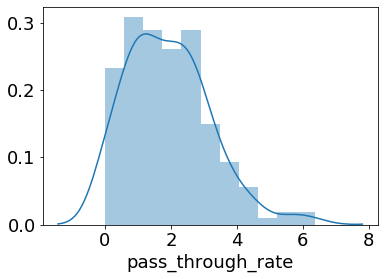

In [220]:
sns.distplot(df_agg_rf_base['pass_through_rate']);

Near normal with slight right skewness

## Running random forest

In [221]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [222]:
ncol_pred = df_agg_rf_base.shape[1]-1
X = df_agg_rf_base.iloc[:,:ncol_pred].fillna(0)
y = df_agg_rf_base.iloc[:,-1].fillna(0)

In [223]:
gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (5, 10, 25, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [224]:
grid_result = gsc.fit(X, y)
best_params = grid_result.best_params_

In [225]:
best_params

{'max_depth': 6, 'n_estimators': 5}

In [226]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=0, verbose=False)

In [227]:
rfr.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
                      oob_score=False, random_state=0, verbose=False,
                      warm_start=False)

In [228]:
feature_importance = pd.DataFrame()

feature_importance['column_name'] = X.columns
feature_importance['importance'] = rfr.feature_importances_
feature_importance = feature_importance.sort_values(by = 'importance', ascending = True)

In [229]:
feature_importance

column_name  importance
10                              65+    0.000000
20                       Fort Worth    0.000000
21                          Houston    0.000005
9                             55-64    0.000030
11                           female    0.000104
13  Food & Dining/Fast Food Cravers    0.000184
25           charter communications    0.000247
15                            en-us    0.000462
6                             25-34    0.005376
14          Shoppers/Value Shoppers    0.008326
8                             45-54    0.010149
27                          Windows    0.011066
12                             male    0.011250
23                      San Antonio    0.011364
3                         diggoogpd    0.011495
26                            Apple    0.013471
17                           Austin    0.017854
28                              iOS    0.018042
0                    brandawareness    0.021789
7                             35-44    0.022625
19                           Dallas    0.023456
1         cheap-houston-electricity    0.024252
5                          digsocfb    0.026050
18                          Cypress    0.027326
4                          dignxtdr    0.028643
16                        Arlington    0.036096
31                            lag_3    0.037467
29                            lag_1    0.042737
2                           digchzl    0.047874
22                            Plano    0.058358
24                       at&t corp.    0.233445
30                            lag_2    0.250456

<BarContainer object of 32 artists>

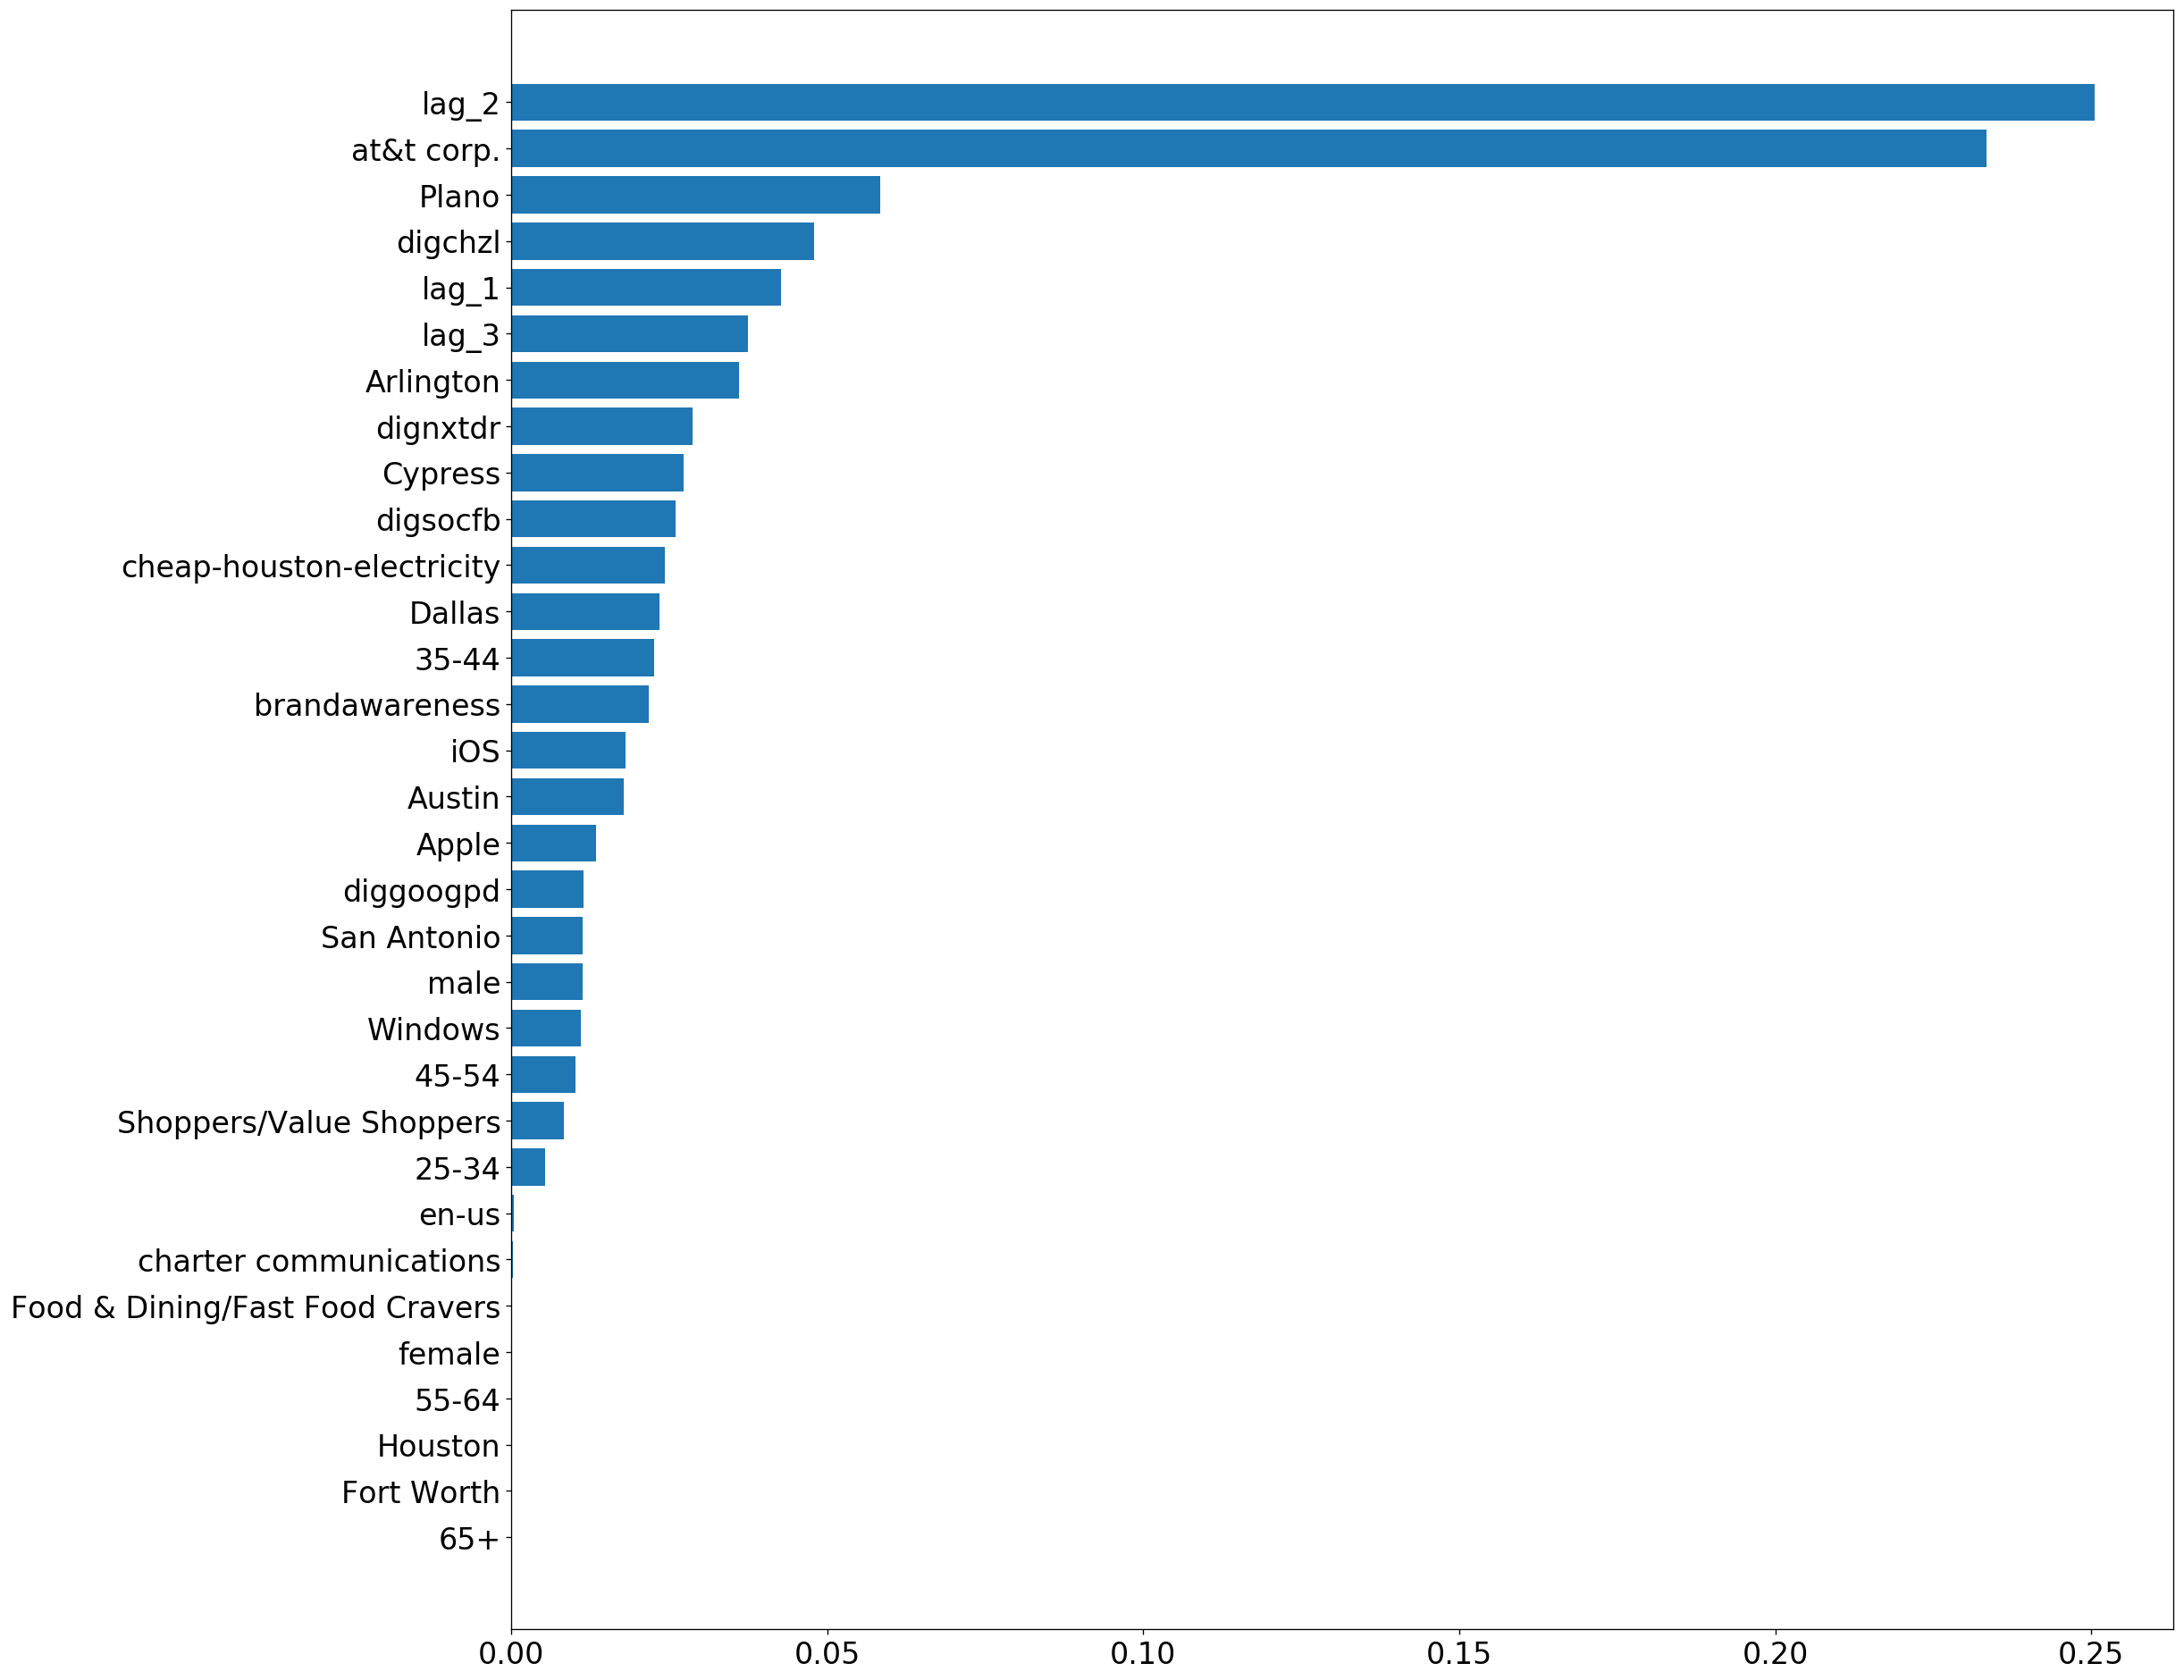

In [230]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})

plt.barh(feature_importance['column_name'], feature_importance['importance'], )

In [231]:
scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_absolute_error')

## Aggregating coefs values for these variables (from lasso)

In [232]:
feature_importance_w_coeffs = feature_importance.copy()

In [233]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(campaign_coefs, left_on = 'column_name', right_on = 'campaign', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient
0         65+    0.000000      NaN          NaN
1  Fort Worth    0.000000      NaN          NaN
2     Houston    0.000005      NaN          NaN
3       55-64    0.000030      NaN          NaN
4      female    0.000104      NaN          NaN

In [234]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(gender_coefs, left_on = 'column_name', right_on = 'gender', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y
0         65+    0.000000      NaN            NaN     NaN            NaN
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN
2     Houston    0.000005      NaN            NaN     NaN            NaN
3       55-64    0.000030      NaN            NaN     NaN            NaN
4      female    0.000104      NaN            NaN  female       0.006446

In [235]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(age_coefs, left_on = 'column_name', right_on = 'age', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient  
0    65+     0.085240  
1    NaN          NaN  
2    NaN          NaN  
3  55-64     0.015883  
4    NaN          NaN

In [236]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(network_coefs, left_on = 'column_name', right_on = 'network', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y  
0    65+       0.085240     NaN            NaN  
1    NaN            NaN     NaN            NaN  
2    NaN            NaN     NaN            NaN  
3  55-64       0.015883     NaN            NaN  
4    NaN            NaN     NaN            NaN

In [237]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(device_brand_coefs, left_on = 'column_name', right_on = 'device_brand', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y device_brand  coefficient  
0    65+       0.085240     NaN            NaN          NaN          NaN  
1    NaN            NaN     NaN            NaN          NaN          NaN  
2    NaN            NaN     NaN            NaN          NaN          NaN  
3  55-64       0.015883     NaN            NaN          NaN          NaN  
4    NaN            NaN     NaN            NaN          NaN          NaN

In [238]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(city_coefs, left_on = 'column_name', right_on = 'city', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y device_brand  coefficient_x  \
0    65+       0.085240     NaN            NaN          NaN            NaN   
1    NaN            NaN     NaN            NaN          NaN            NaN   
2    NaN            NaN     NaN            NaN          NaN            NaN   
3  55-64       0.015883     NaN            NaN          NaN            NaN   
4    NaN            NaN     NaN            NaN          NaN            NaN   

         city  coefficient_y  
0         NaN            NaN  
1  Fort Worth       0.012003  
2     Houston       0.000969  
3         NaN            NaN  
4         NaN            NaN

In [239]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(os_coefs, left_on = 'column_name', right_on = 'os', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y device_brand  coefficient_x  \
0    65+       0.085240     NaN            NaN          NaN            NaN   
1    NaN            NaN     NaN            NaN          NaN            NaN   
2    NaN            NaN     NaN            NaN          NaN            NaN   
3  55-64       0.015883     NaN            NaN          NaN            NaN   
4    NaN            NaN     NaN            NaN          NaN            NaN   

         city  coefficient_y   os  coefficient  
0         NaN            NaN  NaN          NaN  
1  Fort Worth       0.012003  NaN          NaN  
2     Houston       0.000969  NaN          NaN  
3         NaN            NaN  NaN          NaN  
4         NaN            NaN  NaN          NaN

In [240]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(language_coefs, left_on = 'column_name', right_on = 'language', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y device_brand  coefficient_x  \
0    65+       0.085240     NaN            NaN          NaN            NaN   
1    NaN            NaN     NaN            NaN          NaN            NaN   
2    NaN            NaN     NaN            NaN          NaN            NaN   
3  55-64       0.015883     NaN            NaN          NaN            NaN   
4    NaN            NaN     NaN            NaN          NaN            NaN   

         city  coefficient_y   os  coefficient_x language  coefficient_y  
0         NaN            NaN  NaN            NaN      NaN            NaN  
1  Fort Worth       0.012003  NaN            NaN      NaN            NaN  
2     Houston       0.000969  NaN            NaN      NaN            NaN  
3         NaN            NaN  NaN            NaN      NaN            NaN  
4         NaN            NaN  NaN            NaN      NaN            NaN

In [241]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(affinity_coefs, left_on = 'column_name', right_on = 'affinity', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y device_brand  coefficient_x  \
0    65+       0.085240     NaN            NaN          NaN            NaN   
1    NaN            NaN     NaN            NaN          NaN            NaN   
2    NaN            NaN     NaN            NaN          NaN            NaN   
3  55-64       0.015883     NaN            NaN          NaN            NaN   
4    NaN            NaN     NaN            NaN          NaN            NaN   

         city  coefficient_y   os  coefficient_x language  coefficient_y  \
0         NaN            NaN  NaN            NaN      NaN            NaN   
1  Fort Worth       0.012003  NaN            NaN      NaN            NaN   
2     Houston       0.000969  NaN            NaN      NaN            NaN   
3         NaN            NaN  NaN            NaN      NaN            NaN   
4         NaN            NaN  NaN            NaN      NaN            NaN   

  affinity  coefficient  
0      NaN          NaN  
1      NaN          NaN  
2      NaN          NaN  
3      NaN          NaN  
4      NaN          NaN

In [242]:
feature_importance_w_coeffs = feature_importance_w_coeffs.merge(lag_coefs, left_on = 'column_name', right_on = 'lag', how = 'left')
feature_importance_w_coeffs.head()

column_name  importance campaign  coefficient_x  gender  coefficient_y  \
0         65+    0.000000      NaN            NaN     NaN            NaN   
1  Fort Worth    0.000000      NaN            NaN     NaN            NaN   
2     Houston    0.000005      NaN            NaN     NaN            NaN   
3       55-64    0.000030      NaN            NaN     NaN            NaN   
4      female    0.000104      NaN            NaN  female       0.006446   

     age  coefficient_x network  coefficient_y  ...        city  \
0    65+       0.085240     NaN            NaN  ...         NaN   
1    NaN            NaN     NaN            NaN  ...  Fort Worth   
2    NaN            NaN     NaN            NaN  ...     Houston   
3  55-64       0.015883     NaN            NaN  ...         NaN   
4    NaN            NaN     NaN            NaN  ...         NaN   

   coefficient_y   os  coefficient_x language  coefficient_y affinity  \
0            NaN  NaN            NaN      NaN            NaN      NaN   
1       0.012003  NaN            NaN      NaN            NaN      NaN   
2       0.000969  NaN            NaN      NaN            NaN      NaN   
3            NaN  NaN            NaN      NaN            NaN      NaN   
4            NaN  NaN            NaN      NaN            NaN      NaN   

   coefficient_x  lag  coefficient_y  
0            NaN  NaN            NaN  
1            NaN  NaN            NaN  
2            NaN  NaN            NaN  
3            NaN  NaN            NaN  
4            NaN  NaN            NaN  

[5 rows x 22 columns]

In [243]:
feature_importance_w_coeffs

column_name  importance                   campaign  \
0                               65+    0.000000                        NaN   
1                        Fort Worth    0.000000                        NaN   
2                           Houston    0.000005                        NaN   
3                             55-64    0.000030                        NaN   
4                            female    0.000104                        NaN   
5   Food & Dining/Fast Food Cravers    0.000184                        NaN   
6            charter communications    0.000247                        NaN   
7                             en-us    0.000462                        NaN   
8                             25-34    0.005376                        NaN   
9           Shoppers/Value Shoppers    0.008326                        NaN   
10                            45-54    0.010149                        NaN   
11                          Windows    0.011066                        NaN   
12                             male    0.011250                        NaN   
13                      San Antonio    0.011364                        NaN   
14                        diggoogpd    0.011495                  diggoogpd   
15                            Apple    0.013471                        NaN   
16                           Austin    0.017854                        NaN   
17                              iOS    0.018042                        NaN   
18                   brandawareness    0.021789             brandawareness   
19                            35-44    0.022625                        NaN   
20                           Dallas    0.023456                        NaN   
21        cheap-houston-electricity    0.024252  cheap-houston-electricity   
22                         digsocfb    0.026050                   digsocfb   
23                          Cypress    0.027326                        NaN   
24                         dignxtdr    0.028643                   dignxtdr   
25                        Arlington    0.036096                        NaN   
26                            lag_3    0.037467                        NaN   
27                            lag_1    0.042737                        NaN   
28                          digchzl    0.047874                    digchzl   
29                            Plano    0.058358                        NaN   
30                       at&t corp.    0.233445                        NaN   
31                            lag_2    0.250456                        NaN   

    coefficient_x  gender  coefficient_y    age  coefficient_x  \
0             NaN     NaN            NaN    65+       0.085240   
1             NaN     NaN            NaN    NaN            NaN   
2             NaN     NaN            NaN    NaN            NaN   
3             NaN     NaN            NaN  55-64       0.015883   
4             NaN  female       0.006446    NaN            NaN   
5             NaN     NaN            NaN    NaN            NaN   
6             NaN     NaN            NaN    NaN            NaN   
7             NaN     NaN            NaN    NaN            NaN   
8             NaN     NaN            NaN  25-34       0.026268   
9             NaN     NaN            NaN    NaN            NaN   
10            NaN     NaN            NaN  45-54      -0.033884   
11            NaN     NaN            NaN    NaN            NaN   
12            NaN    male       0.002720    NaN            NaN   
13            NaN     NaN            NaN    NaN            NaN   
14       0.006396     NaN            NaN    NaN            NaN   
15            NaN     NaN            NaN    NaN            NaN   
16            NaN     NaN            NaN    NaN            NaN   
17            NaN     NaN            NaN    NaN            NaN   
18       0.008715     NaN            NaN    NaN            NaN   
19            NaN     NaN            NaN  35-44       0.018877   
20            NaN     NaN            NaN    NaN            NaN 

In [244]:
feature_importance_w_coeffs = feature_importance_w_coeffs.drop(['campaign','gender','age','network','device_brand','city','os','lag'], axis = 1)

In [245]:
mapping = {'coefficient_x': 'coefficient',
          'coefficient_y': 'coefficient',
          'coefficient': 'coefficient'}

In [246]:
feature_importance_w_coeffs = feature_importance_w_coeffs.set_index(['column_name','importance']).groupby(mapping, axis = 1).sum().reset_index()
feature_importance_w_coeffs['positive_coef'] = np.where(feature_importance_w_coeffs['coefficient']>=0, 1, 0)
feature_importance_w_coeffs.head()

column_name  importance  coefficient  positive_coef
0         65+    0.000000     0.085240              1
1  Fort Worth    0.000000     0.012003              1
2     Houston    0.000005     0.000969              1
3       55-64    0.000030     0.015883              1
4      female    0.000104     0.006446              1

In [247]:
feature_importance_w_coeffs

column_name  importance  coefficient  positive_coef
0                               65+    0.000000     0.085240              1
1                        Fort Worth    0.000000     0.012003              1
2                           Houston    0.000005     0.000969              1
3                             55-64    0.000030     0.015883              1
4                            female    0.000104     0.006446              1
5   Food & Dining/Fast Food Cravers    0.000184     0.003223              1
6            charter communications    0.000247     0.001106              1
7                             en-us    0.000462     0.002943              1
8                             25-34    0.005376     0.026268              1
9           Shoppers/Value Shoppers    0.008326     0.007822              1
10                            45-54    0.010149    -0.033884              0
11                          Windows    0.011066     0.002863              1
12                             male    0.011250     0.002720              1
13                      San Antonio    0.011364     0.003040              1
14                        diggoogpd    0.011495     0.006396              1
15                            Apple    0.013471     0.010948              1
16                           Austin    0.017854     0.004246              1
17                              iOS    0.018042     0.006648              1
18                   brandawareness    0.021789     0.008715              1
19                            35-44    0.022625     0.018877              1
20                           Dallas    0.023456     0.001778              1
21        cheap-houston-electricity    0.024252     0.020387              1
22                         digsocfb    0.026050     0.021638              1
23                          Cypress    0.027326     0.001772              1
24                         dignxtdr    0.028643     0.004701              1
25                        Arlington    0.036096     0.037679              1
26                            lag_3    0.037467     0.182400              1
27                            lag_1    0.042737     0.367720              1
28                          digchzl    0.047874     0.014004              1
29                            Plano    0.058358     0.044966              1
30                       at&t corp.    0.233445     0.017414              1
31                            lag_2    0.250456     0.359950              1

## Plotting Results

In [248]:
mask1 = feature_importance_w_coeffs['positive_coef'] == 1
mask2 = feature_importance_w_coeffs['positive_coef'] == 0

# plt.bar(x[mask1], y[mask1], color = 'red')
# plt.bar(x[mask2], y[mask2], color = 'blue')
# plt.show()

In [249]:
feature_importance_w_coeffs[mask2]['column_name']

10    45-54
Name: column_name, dtype: object

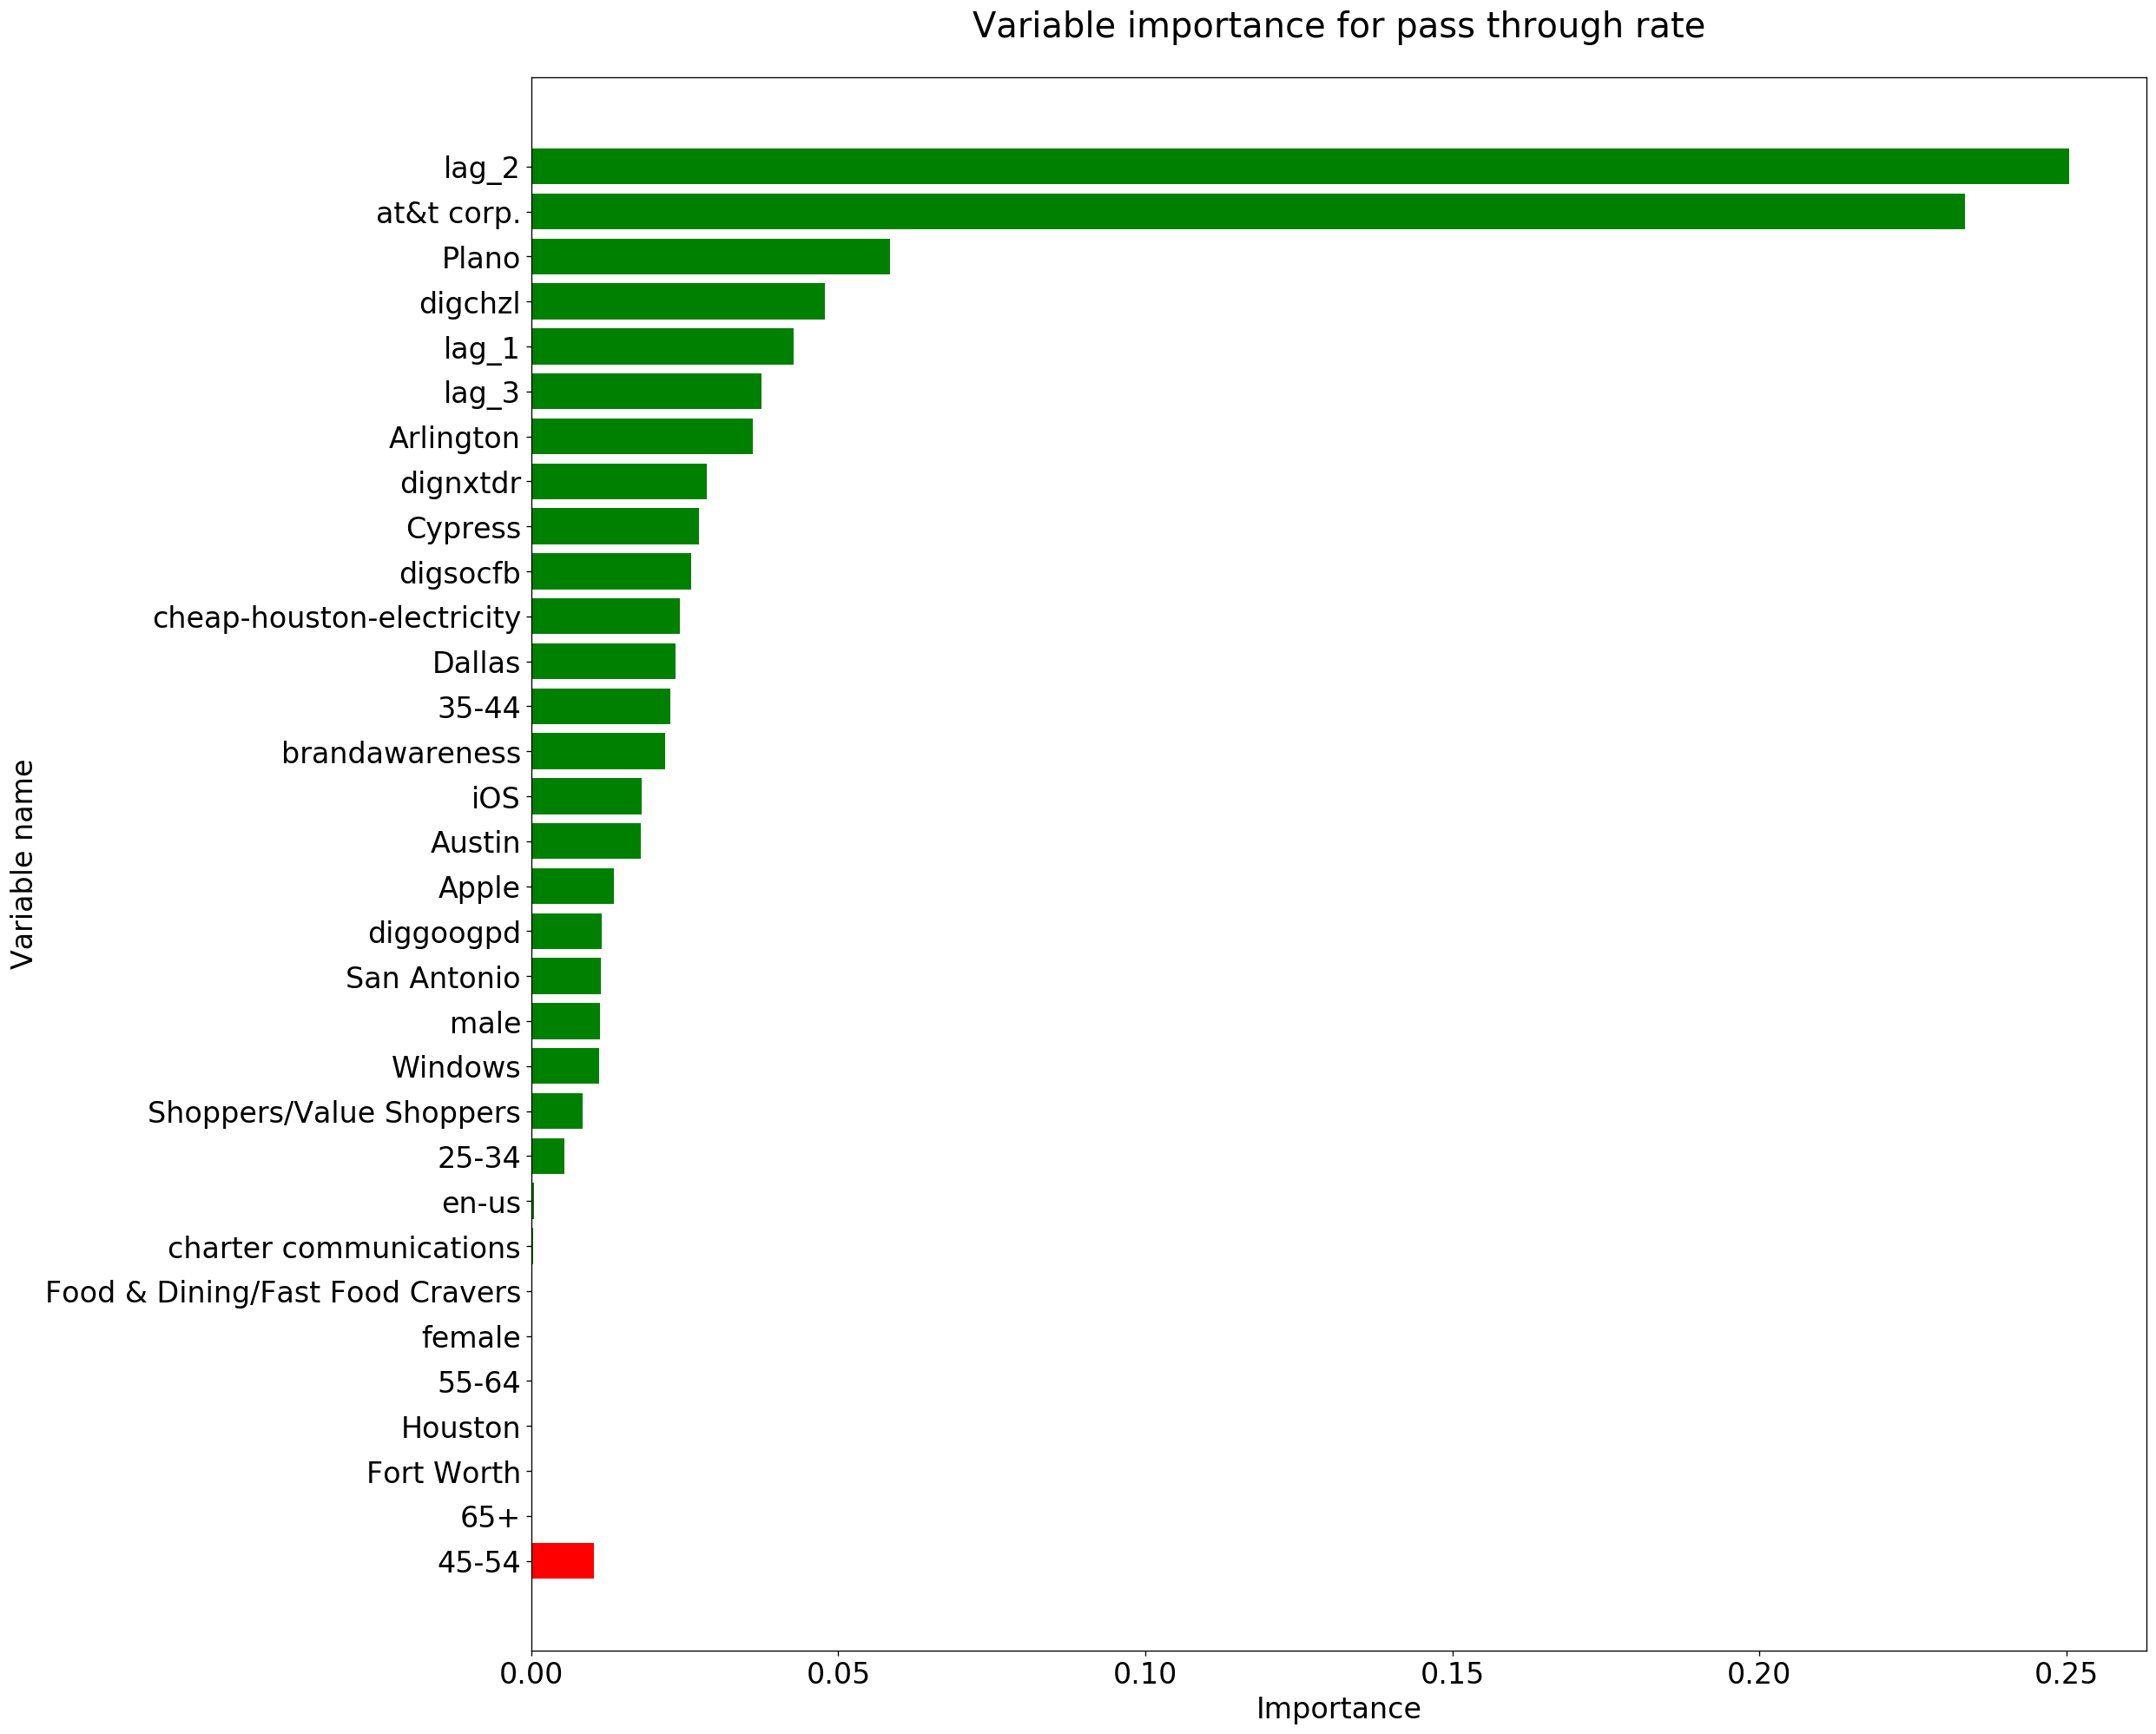

In [250]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})

plt.barh(feature_importance_w_coeffs[mask2]['column_name'], feature_importance_w_coeffs[mask2]['importance'], color = 'red')
plt.barh(feature_importance_w_coeffs[mask1]['column_name'], feature_importance_w_coeffs[mask1]['importance'], color = 'green')

plt.title('Variable importance for pass through rate').set_position([.5, 1.02])
plt.xlabel('Importance')
plt.ylabel('Variable name')

plt.show()

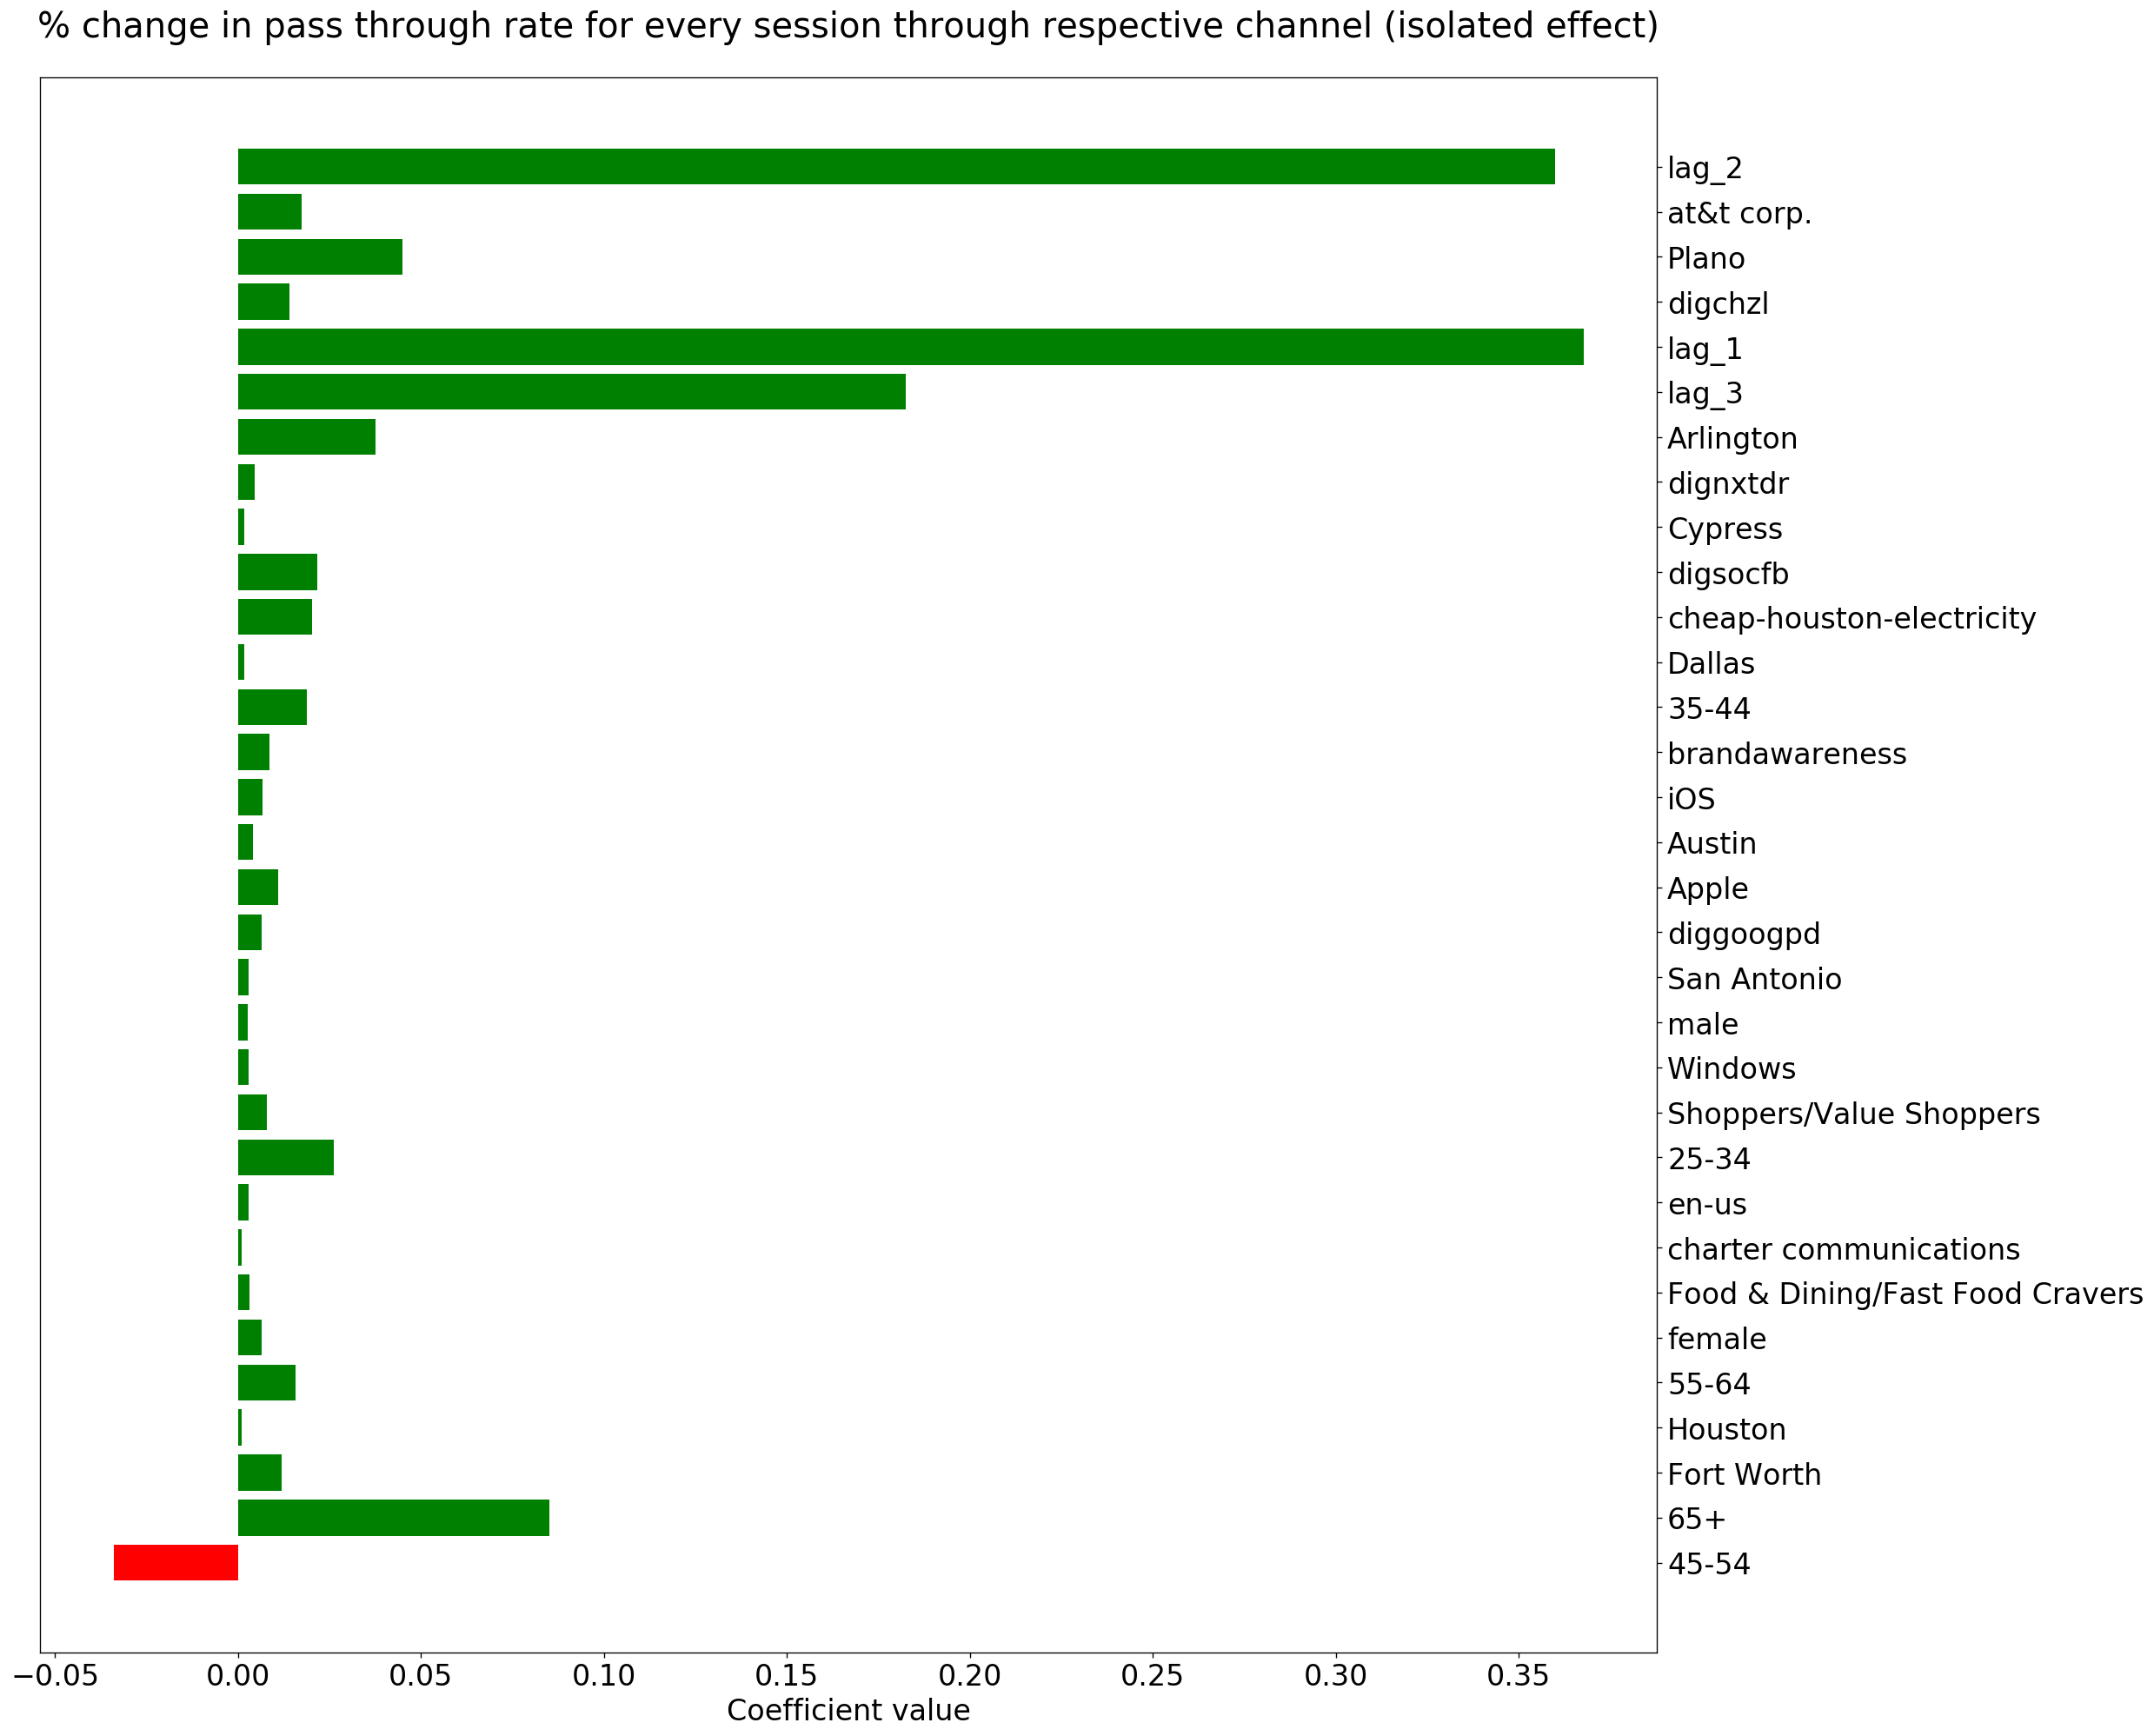

In [251]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

plt.barh(feature_importance_w_coeffs[mask2]['column_name'], feature_importance_w_coeffs[mask2]['coefficient'], color = 'red')
plt.barh(feature_importance_w_coeffs[mask1]['column_name'], feature_importance_w_coeffs[mask1]['coefficient'], color = 'green')

plt.title('% change in pass through rate for every session through respective channel (isolated effect)').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

As is clear from the plots, above, lag1, lag2 and lag3 have high importance for our target pass_through_rate and and the highest coefficients among all from the dimensions.

We try to take out the effect of these three and then try to run a random forest on 'pass_through_rate_modified'

where **'pass_through_rate_modified' = 'pass_through_rate' - beta_lag_1 * lag_1 - beta_lag_2 * lag_2 - beta_lag_3 * lag_3**

## RF on modified DF

In [252]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [253]:
df_agg_rf_base.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  San Antonio  \
Date                                                        ...                
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...          2.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...          4.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...          1.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...          7.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...          2.0   

            at&t corp.  charter communications  Apple  Windows    iOS  \
Date                                                                    
2019-06-11        20.0                     9.0   75.0    212.0   75.0   
2019-06-12        34.0                    20.0  135.0    299.0  135.0   
2019-06-13        27.0                    20.0  133.0    216.0  133.0   
2019-06-14         9.0                    14.0   77.0    170.0   77.0   
2019-06-15        10.0                     7.0   56.0     59.0   56.0   

               lag_1     lag_2     lag_3  pass_through_rate  
Date                                                         
2019-06-11  2.508961  1.515152  1.107011           2.688172  
2019-06-12  2.688172  2.508961  1.515152           2.492212  
2019-06-13  2.492212  2.688172  2.508961           3.728814  
2019-06-14  3.728814  2.492212  2.688172           3.500000  
2019-06-15  3.500000  3.728814  2.492212           0.000000  

[5 rows x 33 columns]

In [254]:
feature_importance_w_coeffs.head()

column_name  importance  coefficient  positive_coef
0         65+    0.000000     0.085240              1
1  Fort Worth    0.000000     0.012003              1
2     Houston    0.000005     0.000969              1
3       55-64    0.000030     0.015883              1
4      female    0.000104     0.006446              1

In [255]:
df_agg_rf_modified = df_agg_rf_base.copy()

df_agg_rf_modified['pass_through_rate_modified'] = df_agg_rf_modified['pass_through_rate'] - feature_importance_w_coeffs.iloc[feature_importance_w_coeffs.index[feature_importance_w_coeffs['column_name'] == 'lag_1'].tolist()]['coefficient'].values[0]*df_agg_rf_modified['lag_1'] - feature_importance_w_coeffs.iloc[feature_importance_w_coeffs.index[feature_importance_w_coeffs['column_name'] == 'lag_2'].tolist()]['coefficient'].values[0]*df_agg_rf_modified['lag_2'] - feature_importance_w_coeffs.iloc[feature_importance_w_coeffs.index[feature_importance_w_coeffs['column_name'] == 'lag_3'].tolist()]['coefficient'].values[0]*df_agg_rf_modified['lag_3']
df_agg_rf_modified.drop(['lag_1','lag_2','lag_3','pass_through_rate'], axis = 1, inplace = True)
df_agg_rf_modified.head()

brandawareness  cheap-houston-electricity  digchzl  diggoogpd  \
Date                                                                        
2019-06-11             0.0                        0.0      5.0       72.0   
2019-06-12             0.0                        0.0     51.0      101.0   
2019-06-13             0.0                        0.0     19.0      121.0   
2019-06-14             0.0                        0.0      3.0       86.0   
2019-06-15             0.0                        0.0      6.0       55.0   

            dignxtdr  digsocfb  25-34  35-44  45-54  55-64  ...  Fort Worth  \
Date                                                        ...               
2019-06-11       7.0       1.0    4.0    0.0    0.0    0.0  ...        10.0   
2019-06-12      78.0       1.0   51.0   37.0    3.0    0.0  ...        16.0   
2019-06-13     111.0       1.0   26.0    3.0    2.0    0.0  ...        22.0   
2019-06-14      41.0       6.0    7.0    0.0    0.0    0.0  ...        10.0   
2019-06-15      34.0       7.0    NaN    NaN    NaN    NaN  ...        12.0   

            Houston  Plano  San Antonio  at&t corp.  charter communications  \
Date                                                                          
2019-06-11    128.0    9.0          2.0        20.0                     9.0   
2019-06-12    133.0   27.0          4.0        34.0                    20.0   
2019-06-13    157.0    7.0          1.0        27.0                    20.0   
2019-06-14    121.0    3.0          7.0         9.0                    14.0   
2019-06-15     50.0    4.0          2.0        10.0                     7.0   

            Apple  Windows    iOS  pass_through_rate_modified  
Date                                                           
2019-06-11   75.0    212.0   75.0                    1.018281  
2019-06-12  135.0    299.0  135.0                    0.324255  
2019-06-13  133.0    216.0  133.0                    1.387137  
2019-06-14   77.0    170.0   77.0                    0.741448  
2019-06-15   56.0     59.0   56.0                   -3.083784  

[5 rows x 30 columns]

In [256]:
ncol_pred = df_agg_rf_modified.shape[1]-1
X = df_agg_rf_modified.iloc[:,:ncol_pred].fillna(0)
y = df_agg_rf_modified.iloc[:,-1].fillna(0)

In [257]:
gsc_modified = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (5, 10, 25, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

In [258]:
grid_result_modified = gsc_modified.fit(X, y)
best_params_modified = grid_result_modified.best_params_

In [259]:
best_params_modified

{'max_depth': 3, 'n_estimators': 100}

In [260]:
rfr_modified = RandomForestRegressor(max_depth=best_params_modified["max_depth"], n_estimators=best_params_modified["n_estimators"], random_state=0, verbose=False)

In [261]:
rfr_modified.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0,
                      verbose=False, warm_start=False)

In [262]:
rfr_modified.feature_importances_

array([0.00947011, 0.06189177, 0.06167609, 0.08150485, 0.00336843,
       0.03441701, 0.02894906, 0.07502566, 0.02104782, 0.00969487,
       0.00310399, 0.02486215, 0.0153811 , 0.01957267, 0.03138936,
       0.04717124, 0.05571842, 0.02216132, 0.02643512, 0.05125229,
       0.01984118, 0.02307526, 0.05372108, 0.02422731, 0.06723853,
       0.03212674, 0.03212285, 0.03078321, 0.03277051])

In [263]:
feature_importance_modified = pd.DataFrame()

feature_importance_modified['column_name'] = X.columns
feature_importance_modified['importance'] = rfr_modified.feature_importances_
feature_importance_modified = feature_importance_modified.sort_values(by = 'importance', ascending = True)

In [264]:
feature_importance_modified

column_name  importance
10                              65+    0.003104
4                          dignxtdr    0.003368
0                    brandawareness    0.009470
9                             55-64    0.009695
12                             male    0.015381
13  Food & Dining/Fast Food Cravers    0.019573
20                       Fort Worth    0.019841
8                             45-54    0.021048
17                           Austin    0.022161
21                          Houston    0.023075
23                      San Antonio    0.024227
11                           female    0.024862
18                          Cypress    0.026435
6                             25-34    0.028949
27                          Windows    0.030783
14          Shoppers/Value Shoppers    0.031389
26                            Apple    0.032123
25           charter communications    0.032127
28                              iOS    0.032771
5                          digsocfb    0.034417
15                            en-us    0.047171
19                           Dallas    0.051252
22                            Plano    0.053721
16                        Arlington    0.055718
2                           digchzl    0.061676
1         cheap-houston-electricity    0.061892
24                       at&t corp.    0.067239
7                             35-44    0.075026
3                         diggoogpd    0.081505

<BarContainer object of 29 artists>

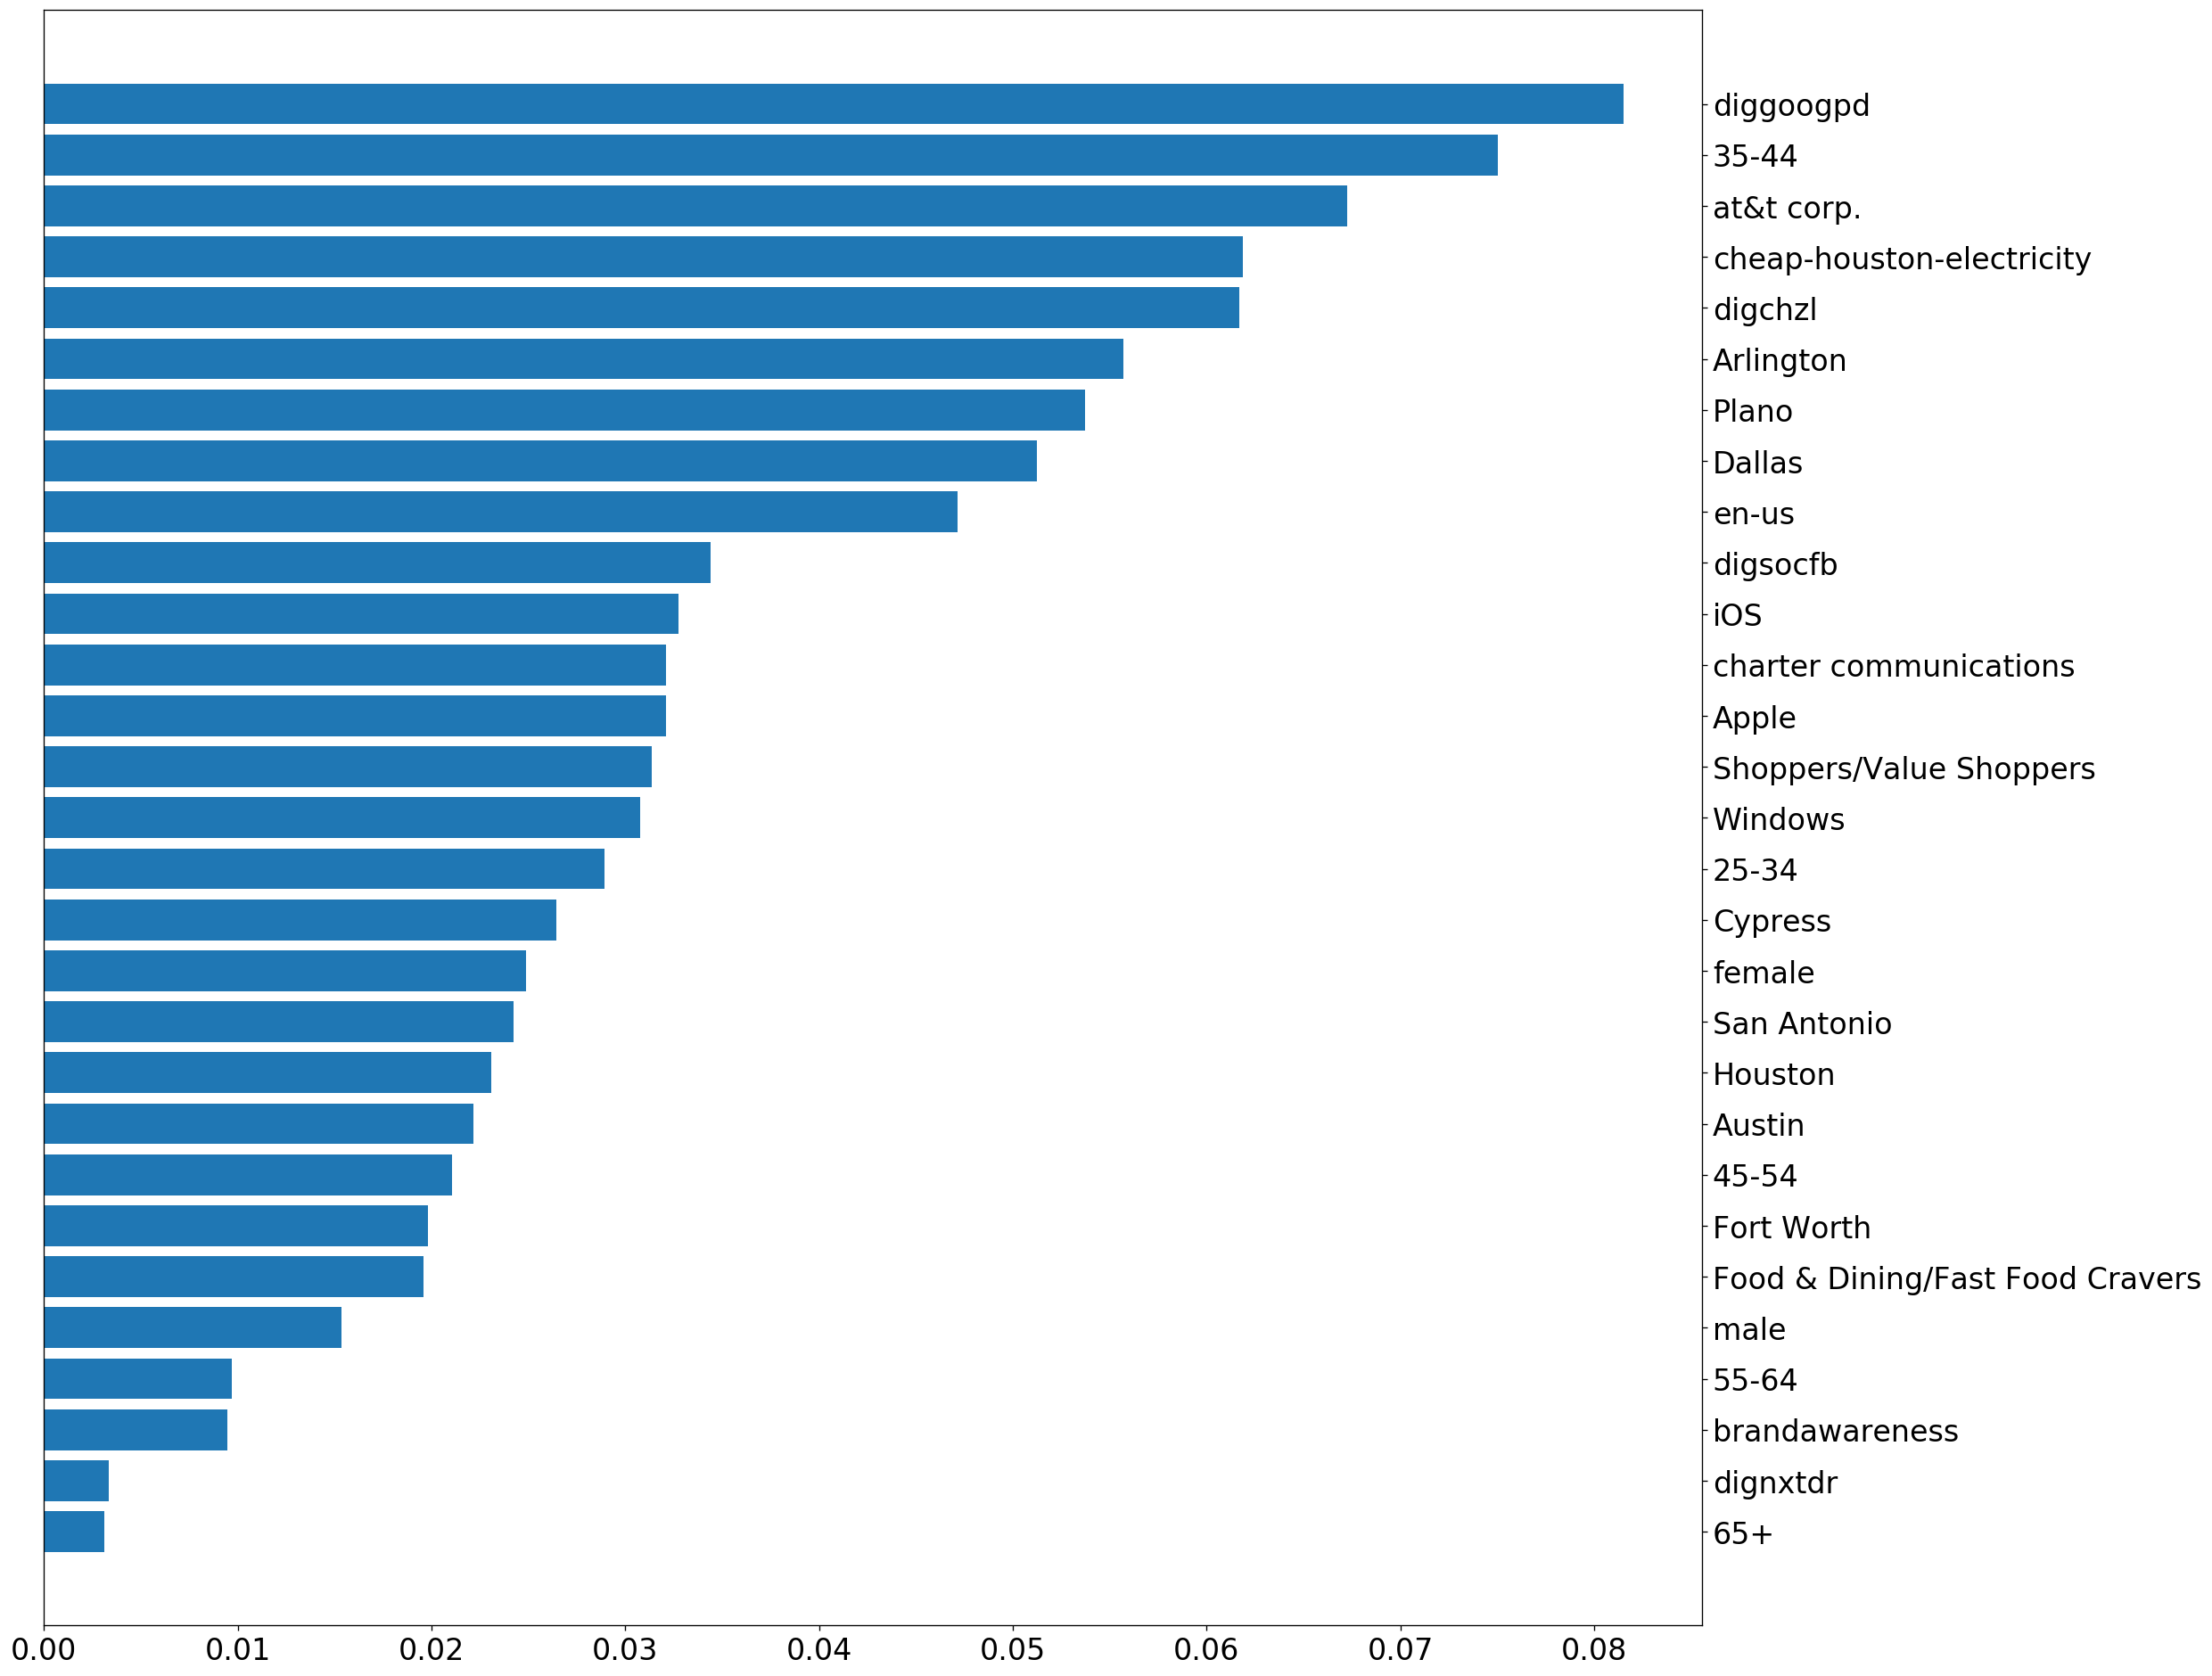

In [265]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})

plt.barh(feature_importance_modified['column_name'], feature_importance_modified['importance'], )

In [266]:
scores = cross_val_score(rfr_modified, X, y, cv=10, scoring='neg_mean_absolute_error')

## Aggregating coefs values for these variables (from lasso)

In [267]:
feature_importance_w_coeffs_modified = feature_importance_modified.copy()

In [268]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(campaign_coefs, left_on = 'column_name', right_on = 'campaign', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient
0             65+    0.003104             NaN          NaN
1        dignxtdr    0.003368        dignxtdr     0.004701
2  brandawareness    0.009470  brandawareness     0.008715
3           55-64    0.009695             NaN          NaN
4            male    0.015381             NaN          NaN

In [269]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(gender_coefs, left_on = 'column_name', right_on = 'gender', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4        0.00272

In [270]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(age_coefs, left_on = 'column_name', right_on = 'age', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient  
0            NaN    65+     0.085240  
1            NaN    NaN          NaN  
2            NaN    NaN          NaN  
3            NaN  55-64     0.015883  
4        0.00272    NaN          NaN

In [271]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(network_coefs, left_on = 'column_name', right_on = 'network', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y  
0            NaN    65+       0.085240     NaN            NaN  
1            NaN    NaN            NaN     NaN            NaN  
2            NaN    NaN            NaN     NaN            NaN  
3            NaN  55-64       0.015883     NaN            NaN  
4        0.00272    NaN            NaN     NaN            NaN

In [272]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(device_brand_coefs, left_on = 'column_name', right_on = 'device_brand', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y device_brand  \
0            NaN    65+       0.085240     NaN            NaN          NaN   
1            NaN    NaN            NaN     NaN            NaN          NaN   
2            NaN    NaN            NaN     NaN            NaN          NaN   
3            NaN  55-64       0.015883     NaN            NaN          NaN   
4        0.00272    NaN            NaN     NaN            NaN          NaN   

   coefficient  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [273]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(city_coefs, left_on = 'column_name', right_on = 'city', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y device_brand  \
0            NaN    65+       0.085240     NaN            NaN          NaN   
1            NaN    NaN            NaN     NaN            NaN          NaN   
2            NaN    NaN            NaN     NaN            NaN          NaN   
3            NaN  55-64       0.015883     NaN            NaN          NaN   
4        0.00272    NaN            NaN     NaN            NaN          NaN   

   coefficient_x city  coefficient_y  
0            NaN  NaN            NaN  
1            NaN  NaN            NaN  
2            NaN  NaN            NaN  
3            NaN  NaN            NaN  
4            NaN  NaN            NaN

In [274]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(os_coefs, left_on = 'column_name', right_on = 'os', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y device_brand  \
0            NaN    65+       0.085240     NaN            NaN          NaN   
1            NaN    NaN            NaN     NaN            NaN          NaN   
2            NaN    NaN            NaN     NaN            NaN          NaN   
3            NaN  55-64       0.015883     NaN            NaN          NaN   
4        0.00272    NaN            NaN     NaN            NaN          NaN   

   coefficient_x city  coefficient_y   os  coefficient  
0            NaN  NaN            NaN  NaN          NaN  
1            NaN  NaN            NaN  NaN          NaN  
2            NaN  NaN            NaN  NaN          NaN  
3            NaN  NaN            NaN  NaN          NaN  
4            NaN  NaN            NaN  NaN          NaN

In [275]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(language_coefs, left_on = 'column_name', right_on = 'language', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y device_brand  \
0            NaN    65+       0.085240     NaN            NaN          NaN   
1            NaN    NaN            NaN     NaN            NaN          NaN   
2            NaN    NaN            NaN     NaN            NaN          NaN   
3            NaN  55-64       0.015883     NaN            NaN          NaN   
4        0.00272    NaN            NaN     NaN            NaN          NaN   

   coefficient_x city  coefficient_y   os  coefficient_x language  \
0            NaN  NaN            NaN  NaN            NaN      NaN   
1            NaN  NaN            NaN  NaN            NaN      NaN   
2            NaN  NaN            NaN  NaN            NaN      NaN   
3            NaN  NaN            NaN  NaN            NaN      NaN   
4            NaN  NaN            NaN  NaN            NaN      NaN   

   coefficient_y  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [276]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.merge(affinity_coefs, left_on = 'column_name', right_on = 'affinity', how = 'left')
feature_importance_w_coeffs_modified.head()

column_name  importance        campaign  coefficient_x gender  \
0             65+    0.003104             NaN            NaN    NaN   
1        dignxtdr    0.003368        dignxtdr       0.004701    NaN   
2  brandawareness    0.009470  brandawareness       0.008715    NaN   
3           55-64    0.009695             NaN            NaN    NaN   
4            male    0.015381             NaN            NaN   male   

   coefficient_y    age  coefficient_x network  coefficient_y device_brand  \
0            NaN    65+       0.085240     NaN            NaN          NaN   
1            NaN    NaN            NaN     NaN            NaN          NaN   
2            NaN    NaN            NaN     NaN            NaN          NaN   
3            NaN  55-64       0.015883     NaN            NaN          NaN   
4        0.00272    NaN            NaN     NaN            NaN          NaN   

   coefficient_x city  coefficient_y   os  coefficient_x language  \
0            NaN  NaN            NaN  NaN            NaN      NaN   
1            NaN  NaN            NaN  NaN            NaN      NaN   
2            NaN  NaN            NaN  NaN            NaN      NaN   
3            NaN  NaN            NaN  NaN            NaN      NaN   
4            NaN  NaN            NaN  NaN            NaN      NaN   

   coefficient_y affinity  coefficient  
0            NaN      NaN          NaN  
1            NaN      NaN          NaN  
2            NaN      NaN          NaN  
3            NaN      NaN          NaN  
4            NaN      NaN          NaN

In [277]:
feature_importance_w_coeffs_modified

column_name  importance                   campaign  \
0                               65+    0.003104                        NaN   
1                          dignxtdr    0.003368                   dignxtdr   
2                    brandawareness    0.009470             brandawareness   
3                             55-64    0.009695                        NaN   
4                              male    0.015381                        NaN   
5   Food & Dining/Fast Food Cravers    0.019573                        NaN   
6                        Fort Worth    0.019841                        NaN   
7                             45-54    0.021048                        NaN   
8                            Austin    0.022161                        NaN   
9                           Houston    0.023075                        NaN   
10                      San Antonio    0.024227                        NaN   
11                           female    0.024862                        NaN   
12                          Cypress    0.026435                        NaN   
13                            25-34    0.028949                        NaN   
14                          Windows    0.030783                        NaN   
15          Shoppers/Value Shoppers    0.031389                        NaN   
16                            Apple    0.032123                        NaN   
17           charter communications    0.032127                        NaN   
18                              iOS    0.032771                        NaN   
19                         digsocfb    0.034417                   digsocfb   
20                            en-us    0.047171                        NaN   
21                           Dallas    0.051252                        NaN   
22                            Plano    0.053721                        NaN   
23                        Arlington    0.055718                        NaN   
24                          digchzl    0.061676                    digchzl   
25        cheap-houston-electricity    0.061892  cheap-houston-electricity   
26                       at&t corp.    0.067239                        NaN   
27                            35-44    0.075026                        NaN   
28                        diggoogpd    0.081505                  diggoogpd   

    coefficient_x  gender  coefficient_y    age  coefficient_x  \
0             NaN     NaN            NaN    65+       0.085240   
1        0.004701     NaN            NaN    NaN            NaN   
2        0.008715     NaN            NaN    NaN            NaN   
3             NaN     NaN            NaN  55-64       0.015883   
4             NaN    male       0.002720    NaN            NaN   
5             NaN     NaN            NaN    NaN            NaN   
6             NaN     NaN            NaN    NaN            NaN   
7             NaN     NaN            NaN  45-54      -0.033884   
8             NaN     NaN            NaN    NaN            NaN   
9             NaN     NaN            NaN    NaN            NaN   
10            NaN     NaN            NaN    NaN            NaN   
11            NaN  female       0.006446    NaN            NaN   
12            NaN     NaN            NaN    NaN            NaN   
13            NaN     NaN            NaN  25-34       0.026268   
14            NaN     NaN            NaN    NaN            NaN   
15            NaN     NaN            NaN    NaN            NaN   
16            NaN     NaN            NaN    NaN            NaN   
17            NaN     NaN            NaN    NaN            NaN   
18            NaN     NaN            NaN    NaN            NaN   
19       0.021638     NaN            NaN    NaN            NaN   
20            NaN     NaN            NaN    NaN            NaN   
21            NaN     NaN            NaN    NaN            NaN   
22            NaN     NaN            NaN    NaN            NaN   
23            NaN     NaN            NaN    NaN            NaN   
24       0.014004     NaN        

In [278]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.drop(['campaign','gender','age','network','device_brand','city','os'], axis = 1)

In [279]:
mapping = {'coefficient_x': 'coefficient',
          'coefficient_y': 'coefficient',
          'coefficient': 'coefficient'}

In [280]:
feature_importance_w_coeffs_modified = feature_importance_w_coeffs_modified.set_index(['column_name','importance']).groupby(mapping, axis = 1).sum().reset_index()
feature_importance_w_coeffs_modified['positive_coef'] = np.where(feature_importance_w_coeffs_modified['coefficient']>=0, 1, 0)
feature_importance_w_coeffs_modified.head()

column_name  importance  coefficient  positive_coef
0             65+    0.003104     0.085240              1
1        dignxtdr    0.003368     0.004701              1
2  brandawareness    0.009470     0.008715              1
3           55-64    0.009695     0.015883              1
4            male    0.015381     0.002720              1

In [281]:
feature_importance_w_coeffs_modified

column_name  importance  coefficient  positive_coef
0                               65+    0.003104     0.085240              1
1                          dignxtdr    0.003368     0.004701              1
2                    brandawareness    0.009470     0.008715              1
3                             55-64    0.009695     0.015883              1
4                              male    0.015381     0.002720              1
5   Food & Dining/Fast Food Cravers    0.019573     0.003223              1
6                        Fort Worth    0.019841     0.012003              1
7                             45-54    0.021048    -0.033884              0
8                            Austin    0.022161     0.004246              1
9                           Houston    0.023075     0.000969              1
10                      San Antonio    0.024227     0.003040              1
11                           female    0.024862     0.006446              1
12                          Cypress    0.026435     0.001772              1
13                            25-34    0.028949     0.026268              1
14                          Windows    0.030783     0.002863              1
15          Shoppers/Value Shoppers    0.031389     0.007822              1
16                            Apple    0.032123     0.010948              1
17           charter communications    0.032127     0.001106              1
18                              iOS    0.032771     0.006648              1
19                         digsocfb    0.034417     0.021638              1
20                            en-us    0.047171     0.002943              1
21                           Dallas    0.051252     0.001778              1
22                            Plano    0.053721     0.044966              1
23                        Arlington    0.055718     0.037679              1
24                          digchzl    0.061676     0.014004              1
25        cheap-houston-electricity    0.061892     0.020387              1
26                       at&t corp.    0.067239     0.017414              1
27                            35-44    0.075026     0.018877              1
28                        diggoogpd    0.081505     0.006396              1

## Plotting results

In [282]:
mask1_modified = feature_importance_w_coeffs_modified['positive_coef'] == 1
mask2_modified = feature_importance_w_coeffs_modified['positive_coef'] == 0

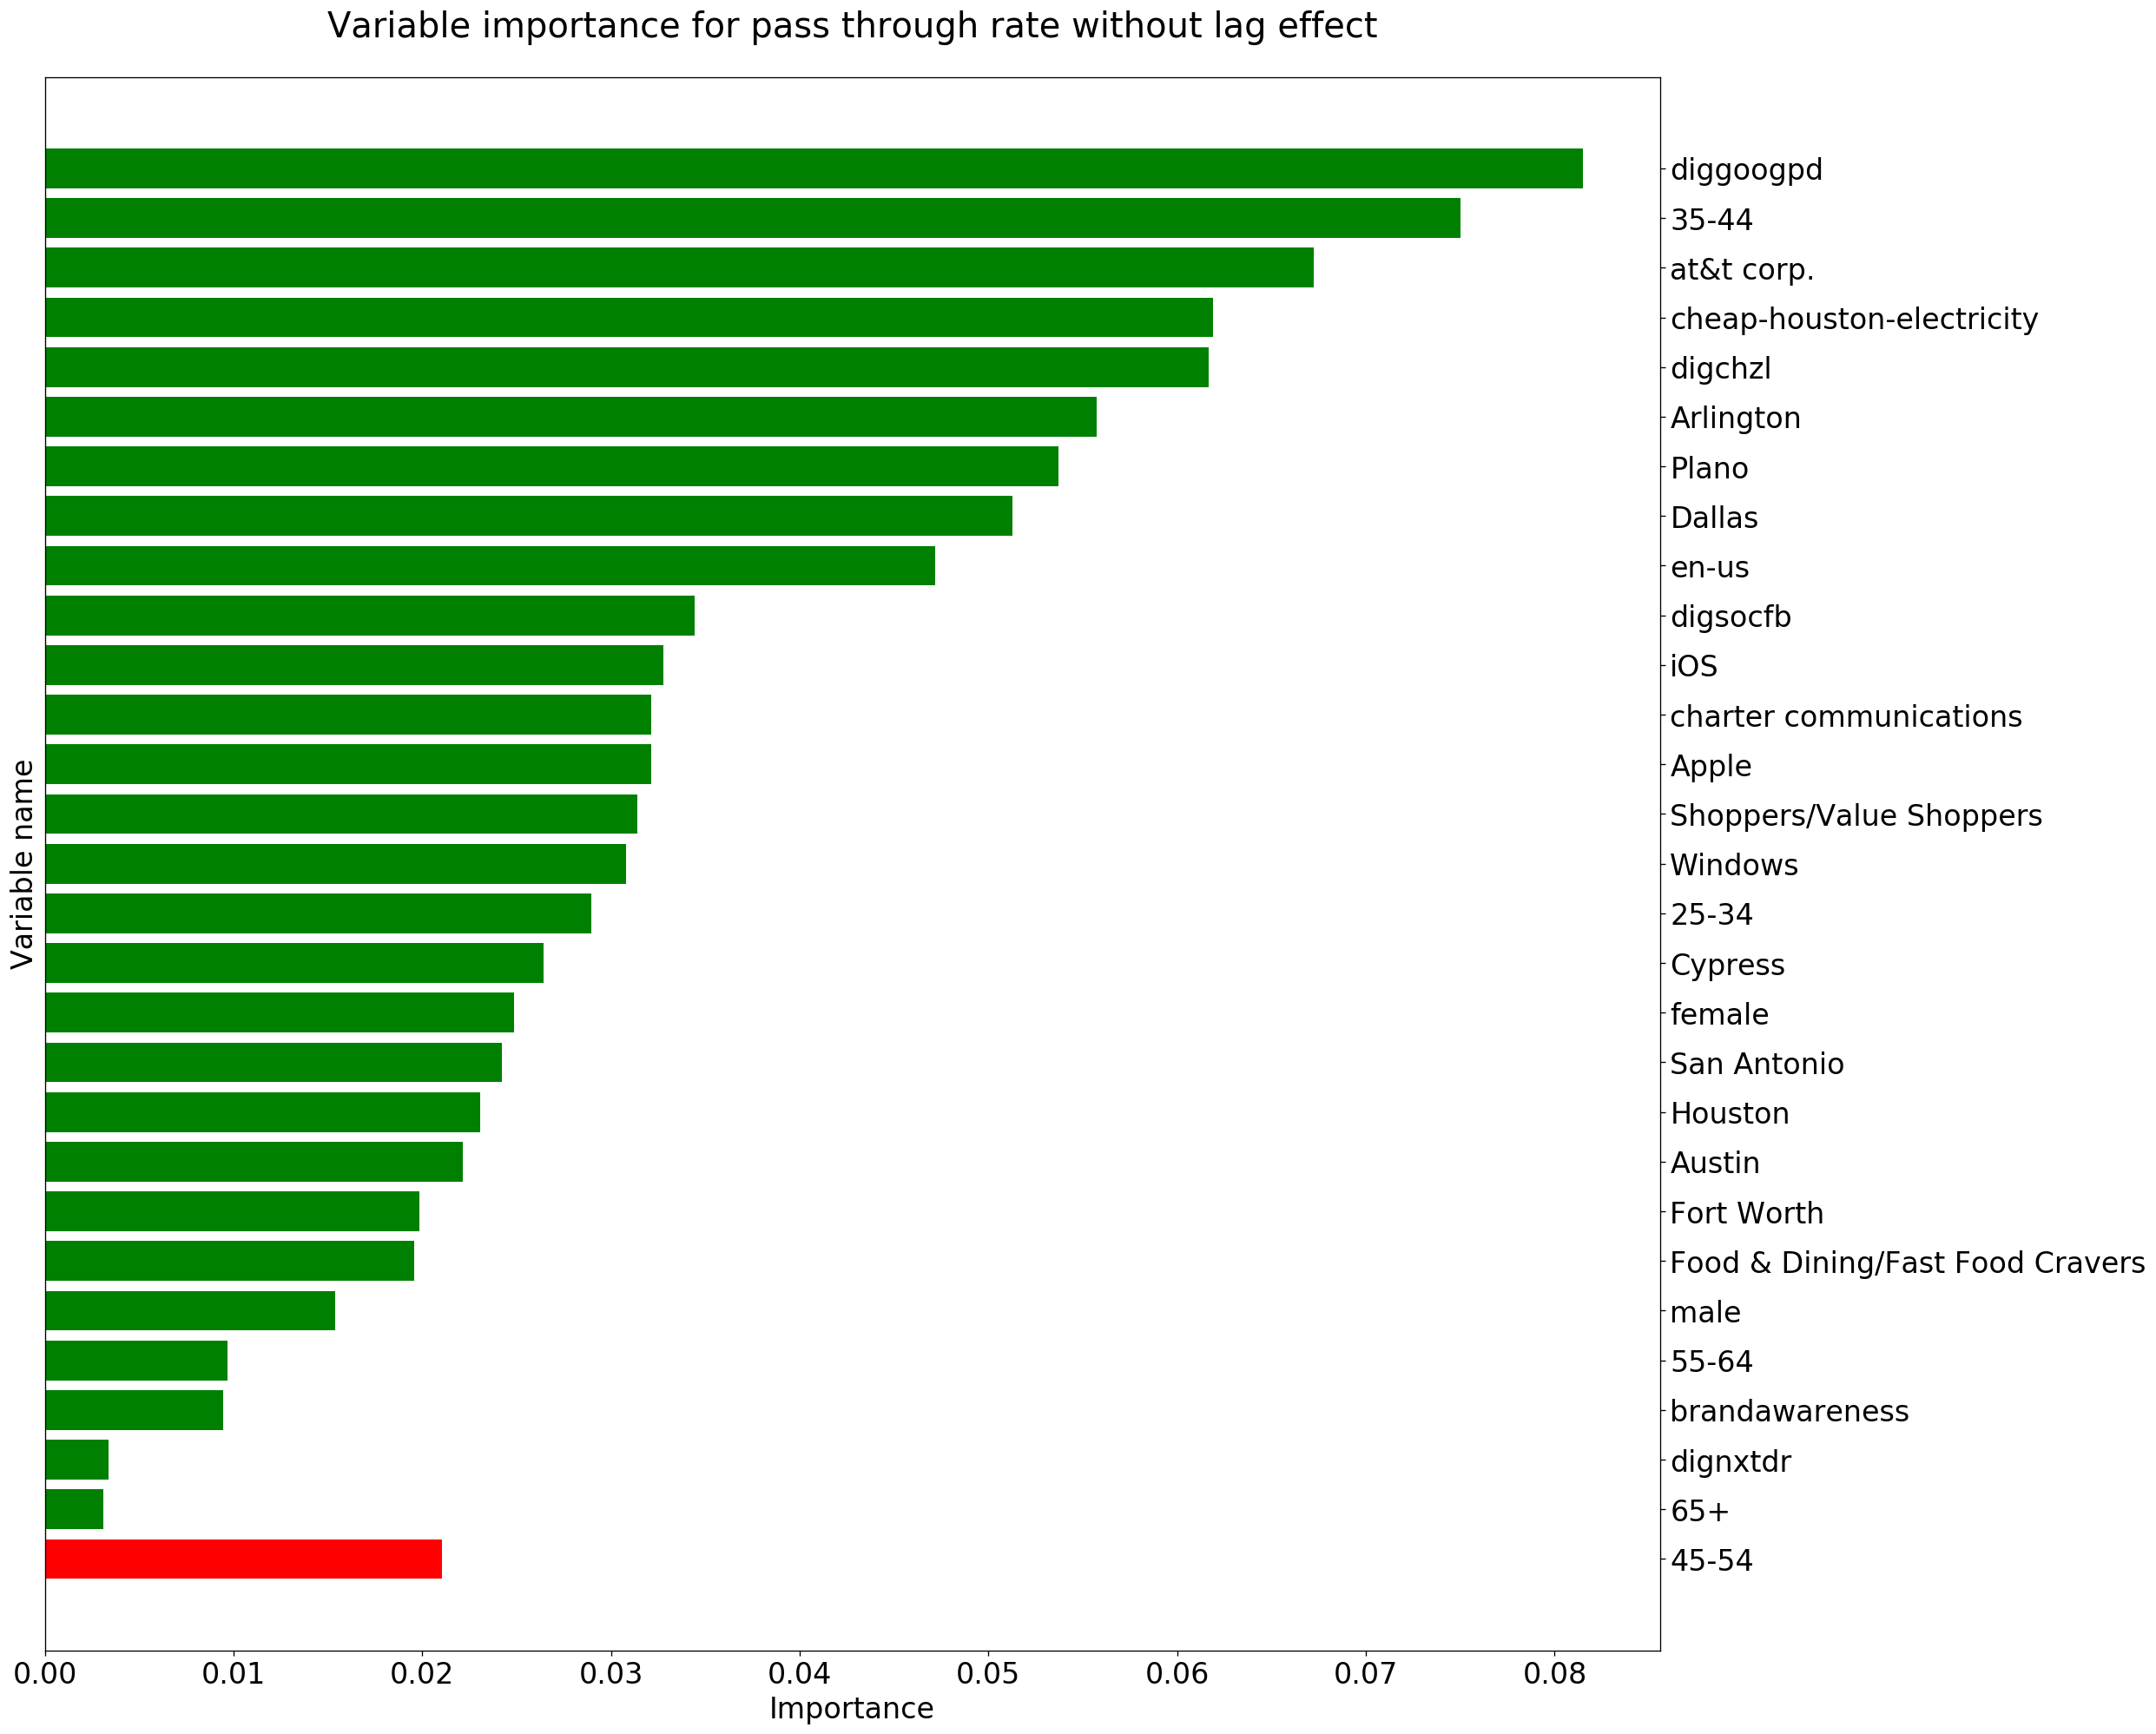

In [283]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})

plt.barh(feature_importance_w_coeffs_modified[mask2_modified]['column_name'], feature_importance_w_coeffs_modified[mask2_modified]['importance'], color = 'red')
plt.barh(feature_importance_w_coeffs_modified[mask1_modified]['column_name'], feature_importance_w_coeffs_modified[mask1_modified]['importance'], color = 'green')

plt.title('Variable importance for pass through rate without lag effect').set_position([.5, 1.02])
plt.xlabel('Importance')
plt.ylabel('Variable name')

plt.show()

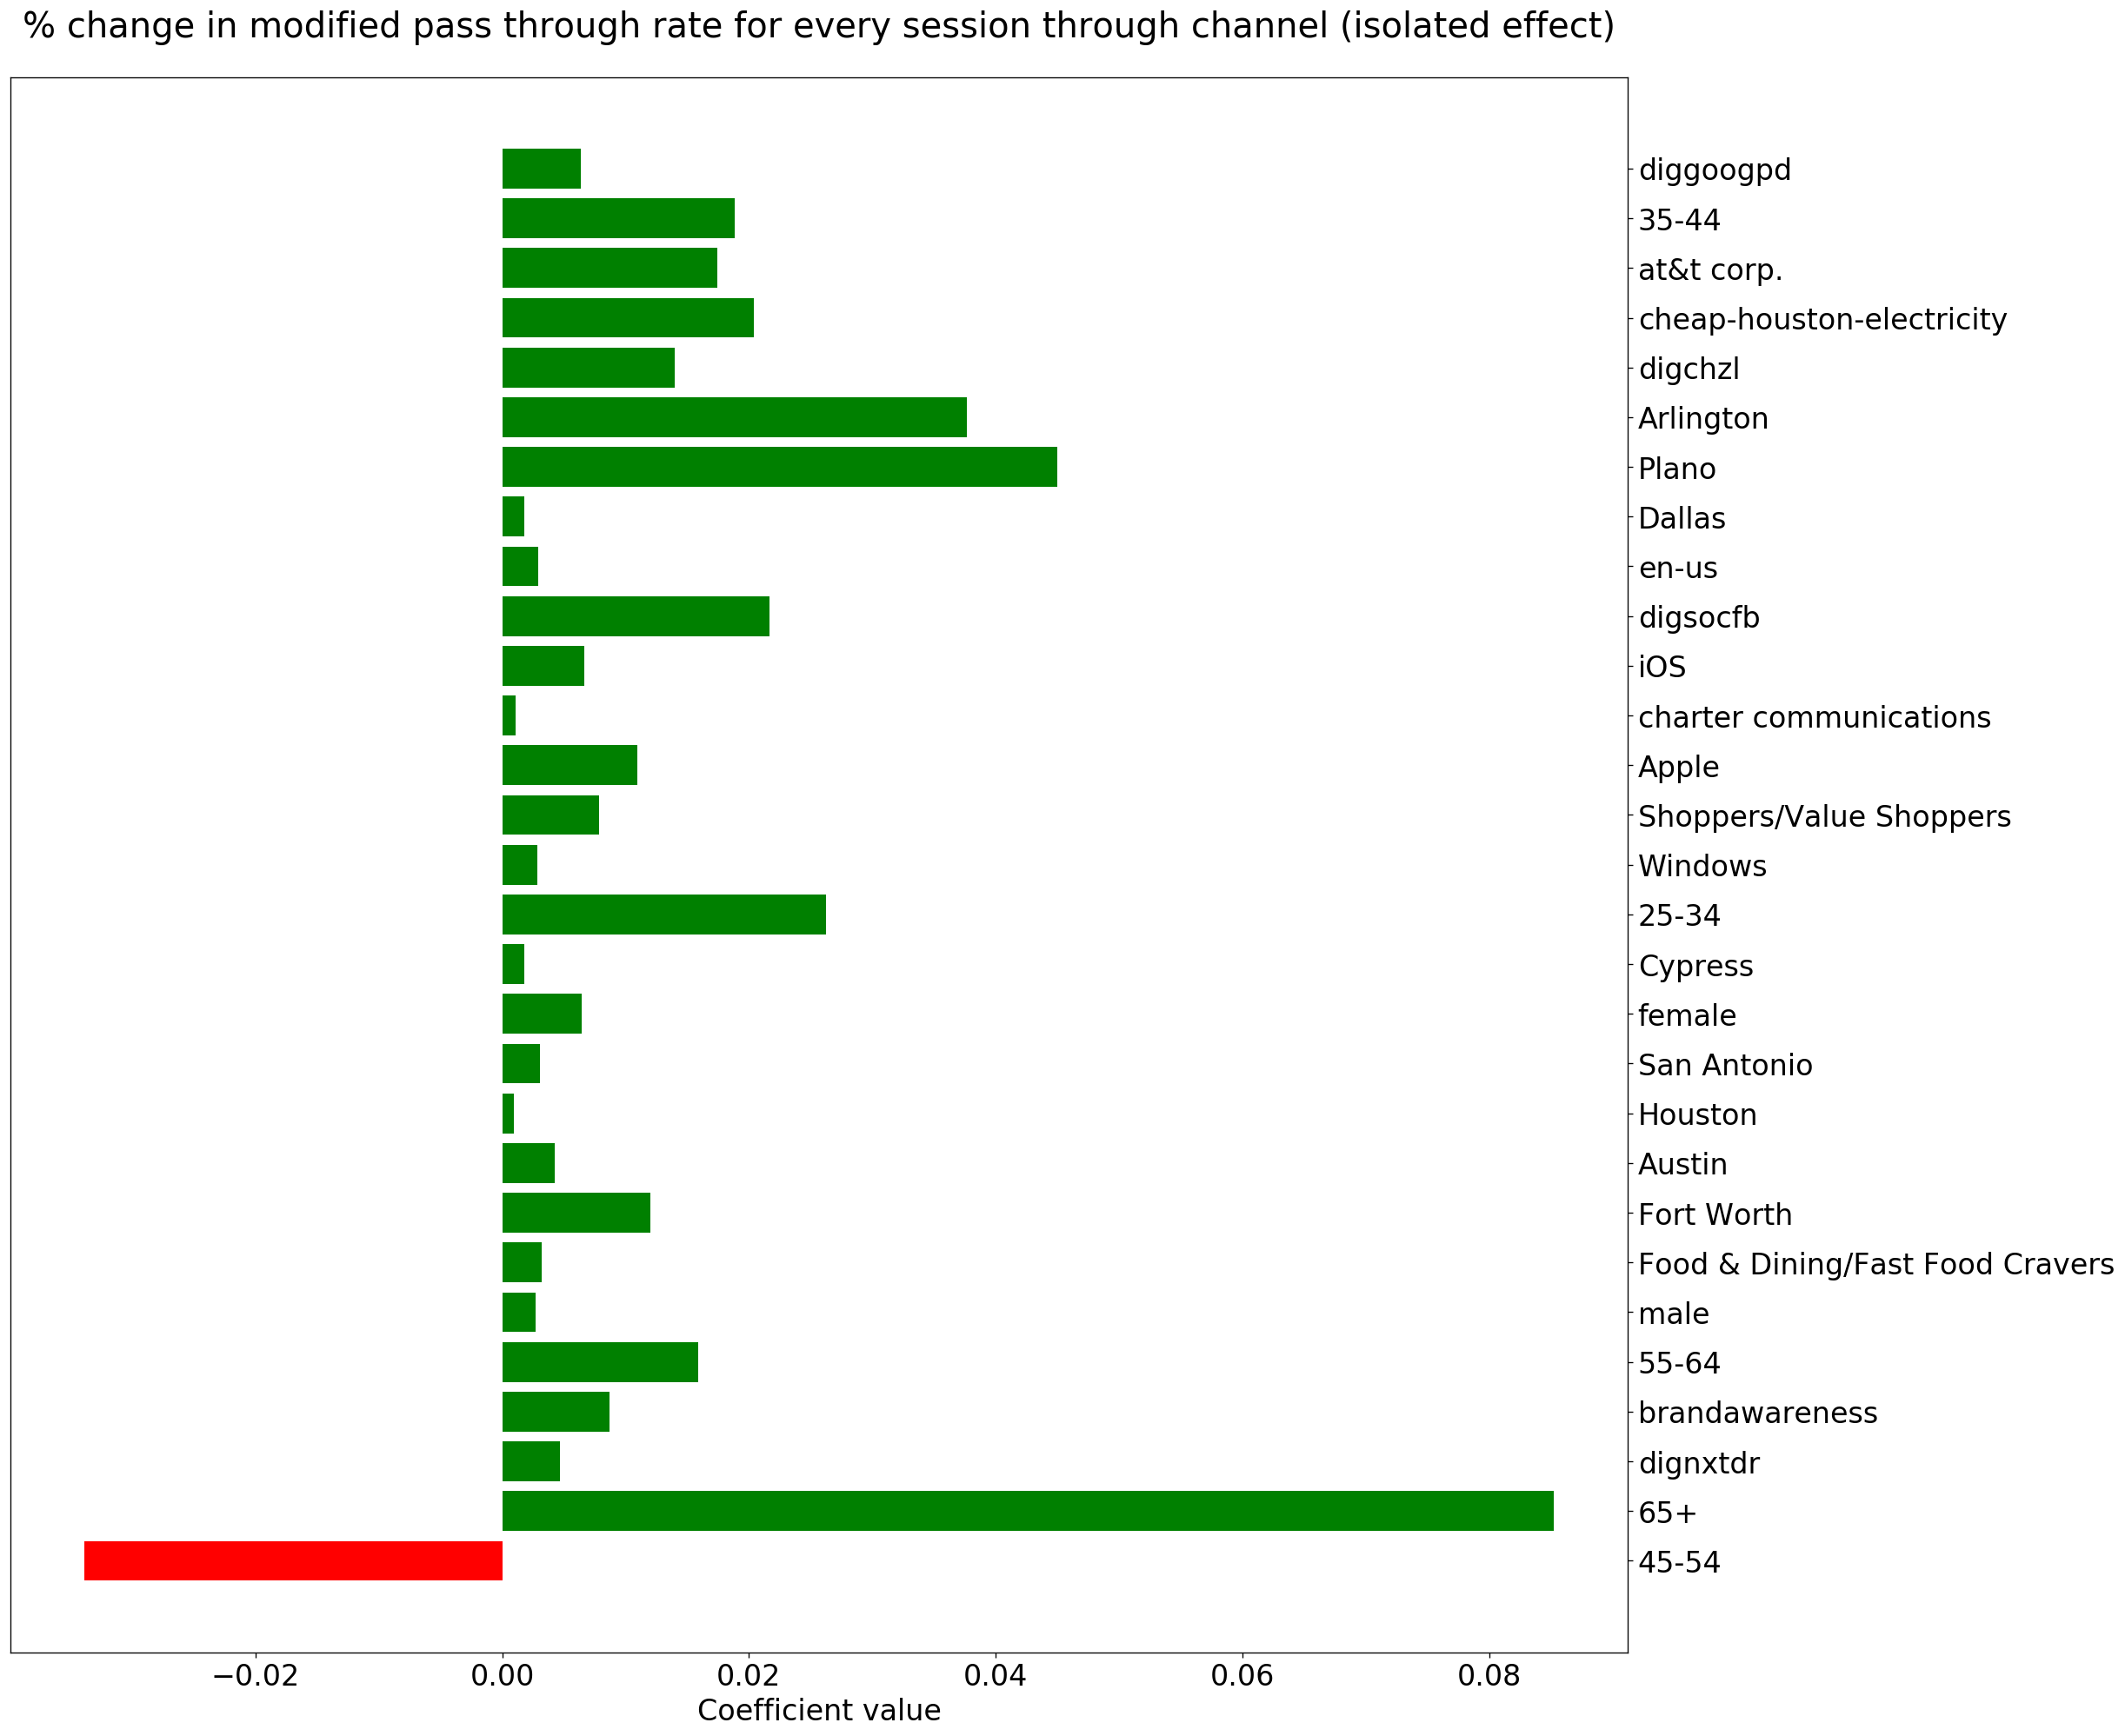

In [284]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

plt.barh(feature_importance_w_coeffs_modified[mask2_modified]['column_name'], feature_importance_w_coeffs_modified[mask2_modified]['coefficient'], color = 'red')
plt.barh(feature_importance_w_coeffs_modified[mask1_modified]['column_name'], feature_importance_w_coeffs_modified[mask1_modified]['coefficient'], color = 'green')

plt.title('% change in modified pass through rate for every session through channel (isolated effect)').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

# Appendix

### Coefficient plots

In [285]:
def positive_coef_col(df):

    df['positive_coef'] = np.where(df['coefficient']>=0, 1, 0)
    return df

In [286]:
campaign_coefs_sign = positive_coef_col(campaign_coefs)

In [287]:
mask1_coef = campaign_coefs_sign['positive_coef'] == 1
mask2_coef = campaign_coefs_sign['positive_coef'] == 0

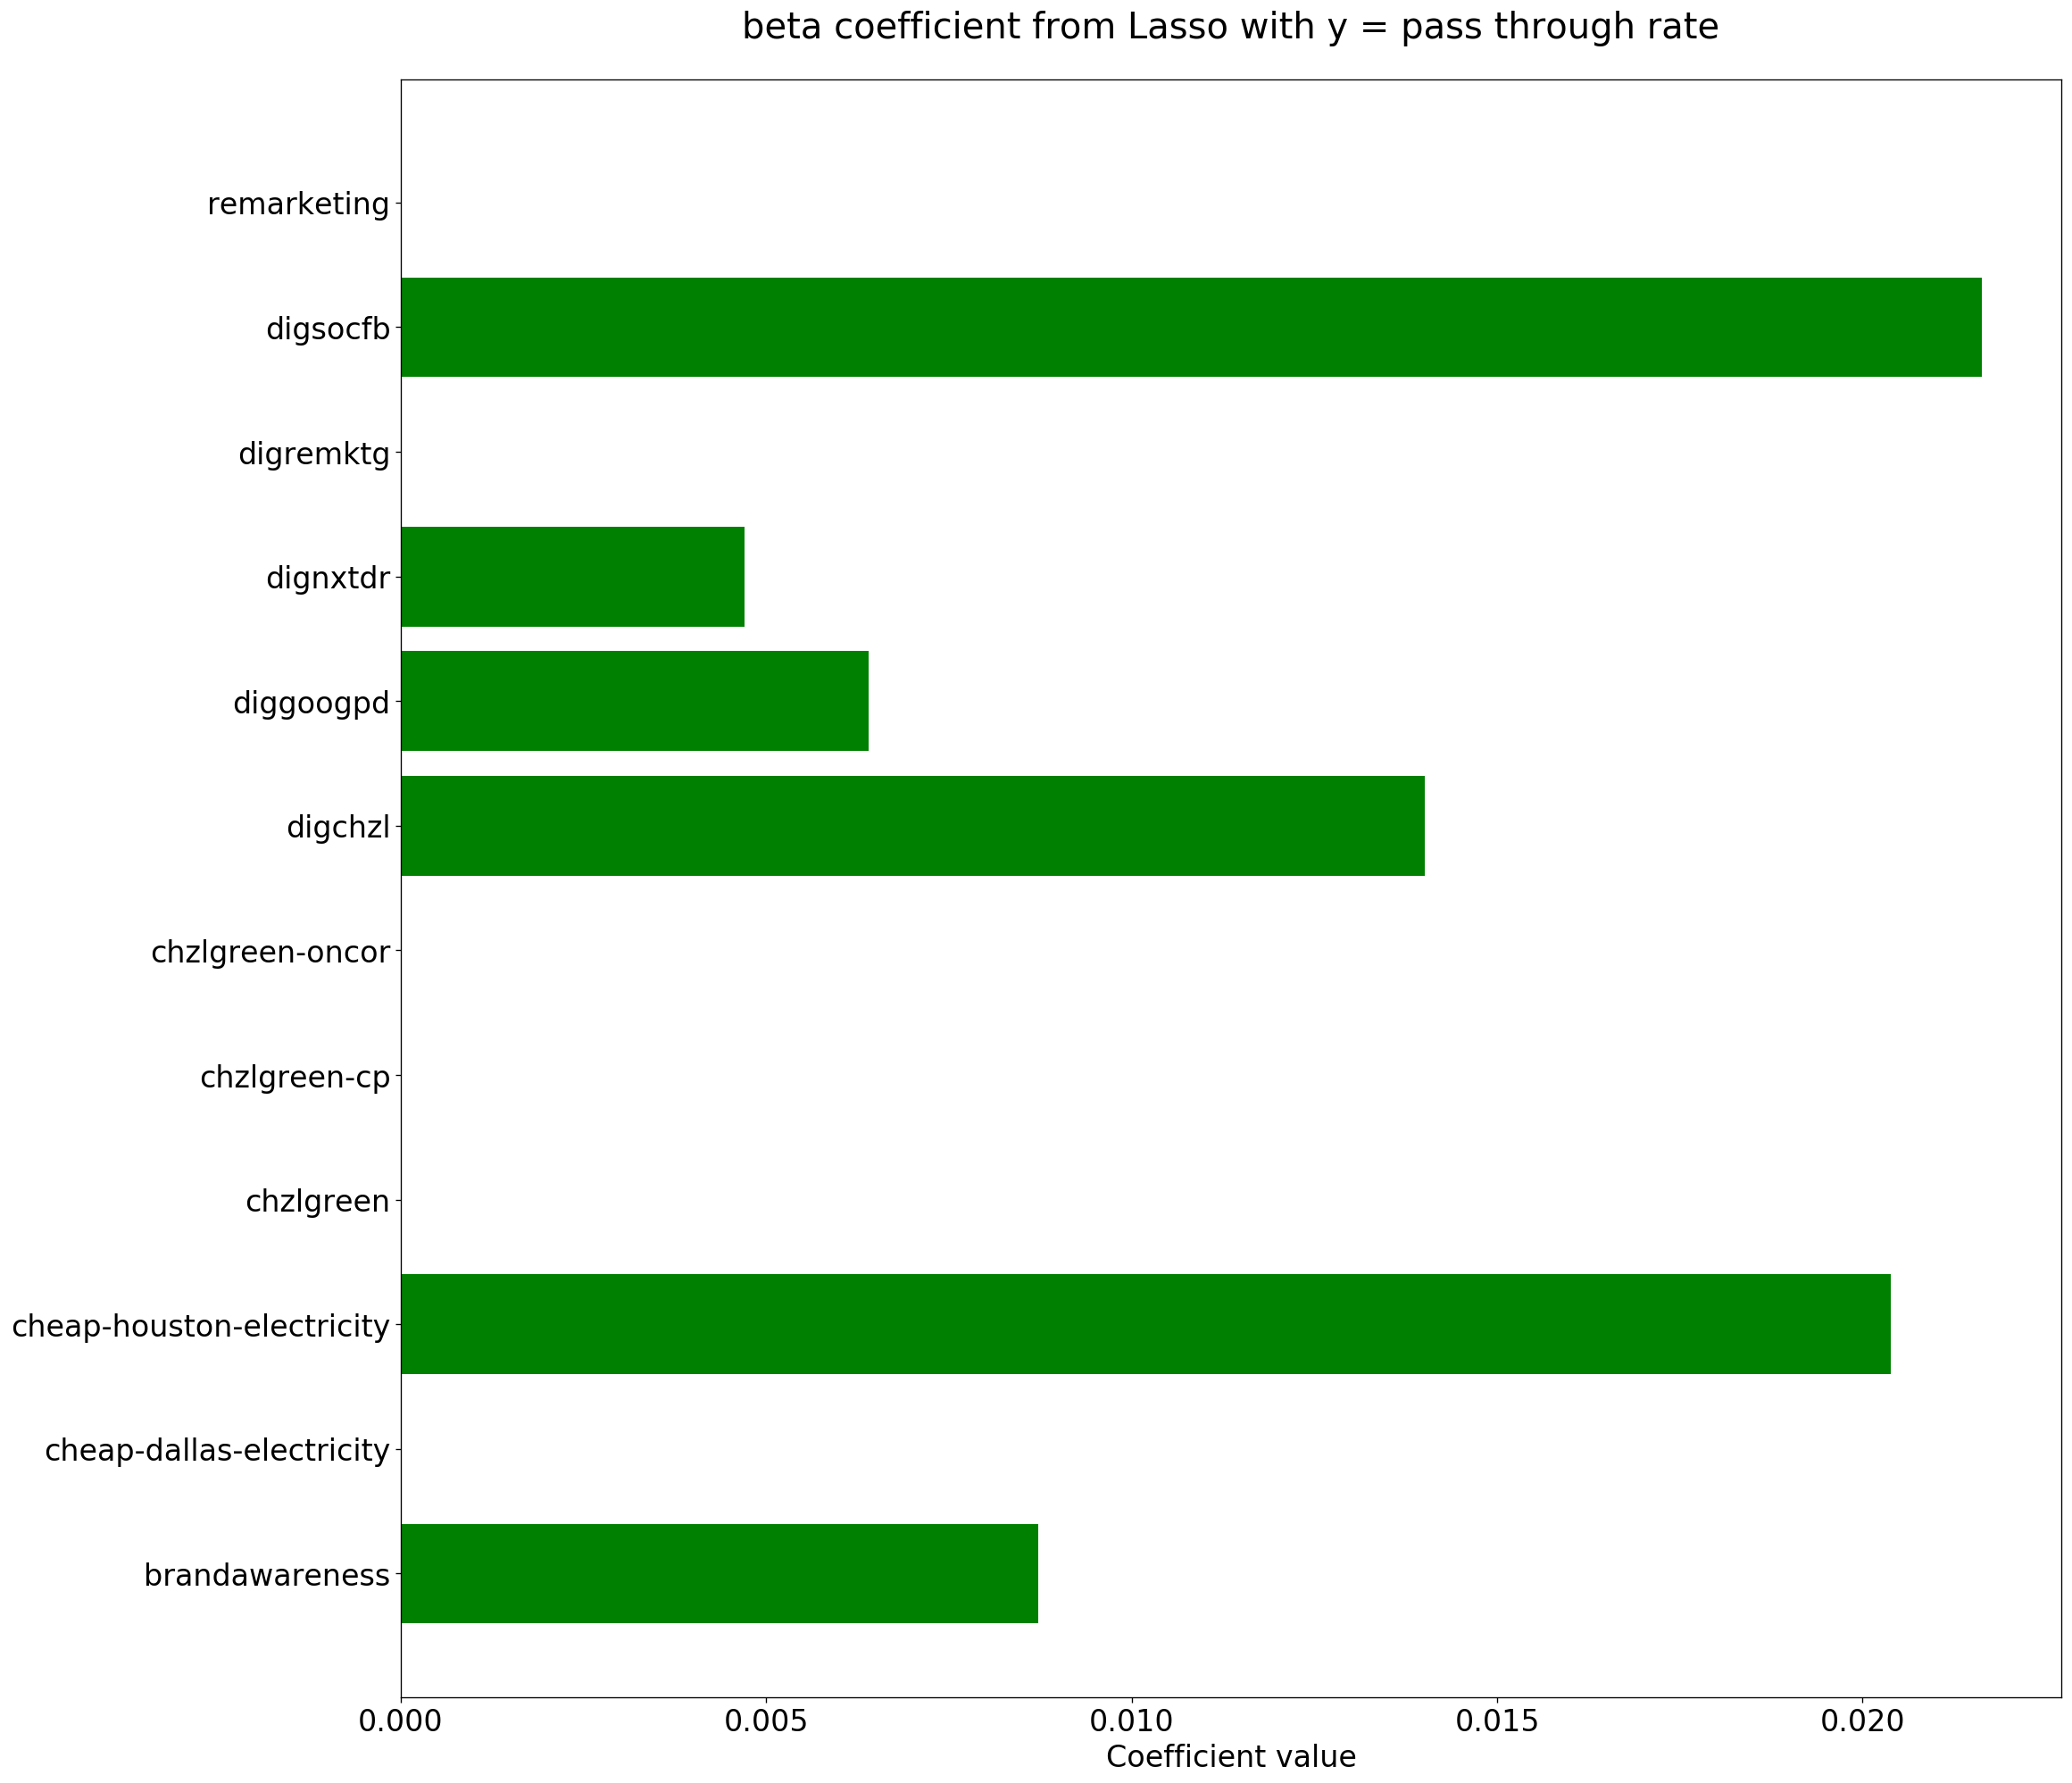

In [288]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(campaign_coefs_sign[mask2_coef]['campaign'], campaign_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(campaign_coefs_sign[mask1_coef]['campaign'], campaign_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Age

In [289]:
age_coefs_sign = positive_coef_col(age_coefs)

In [290]:
mask1_coef = age_coefs_sign['positive_coef'] == 1
mask2_coef = age_coefs_sign['positive_coef'] == 0

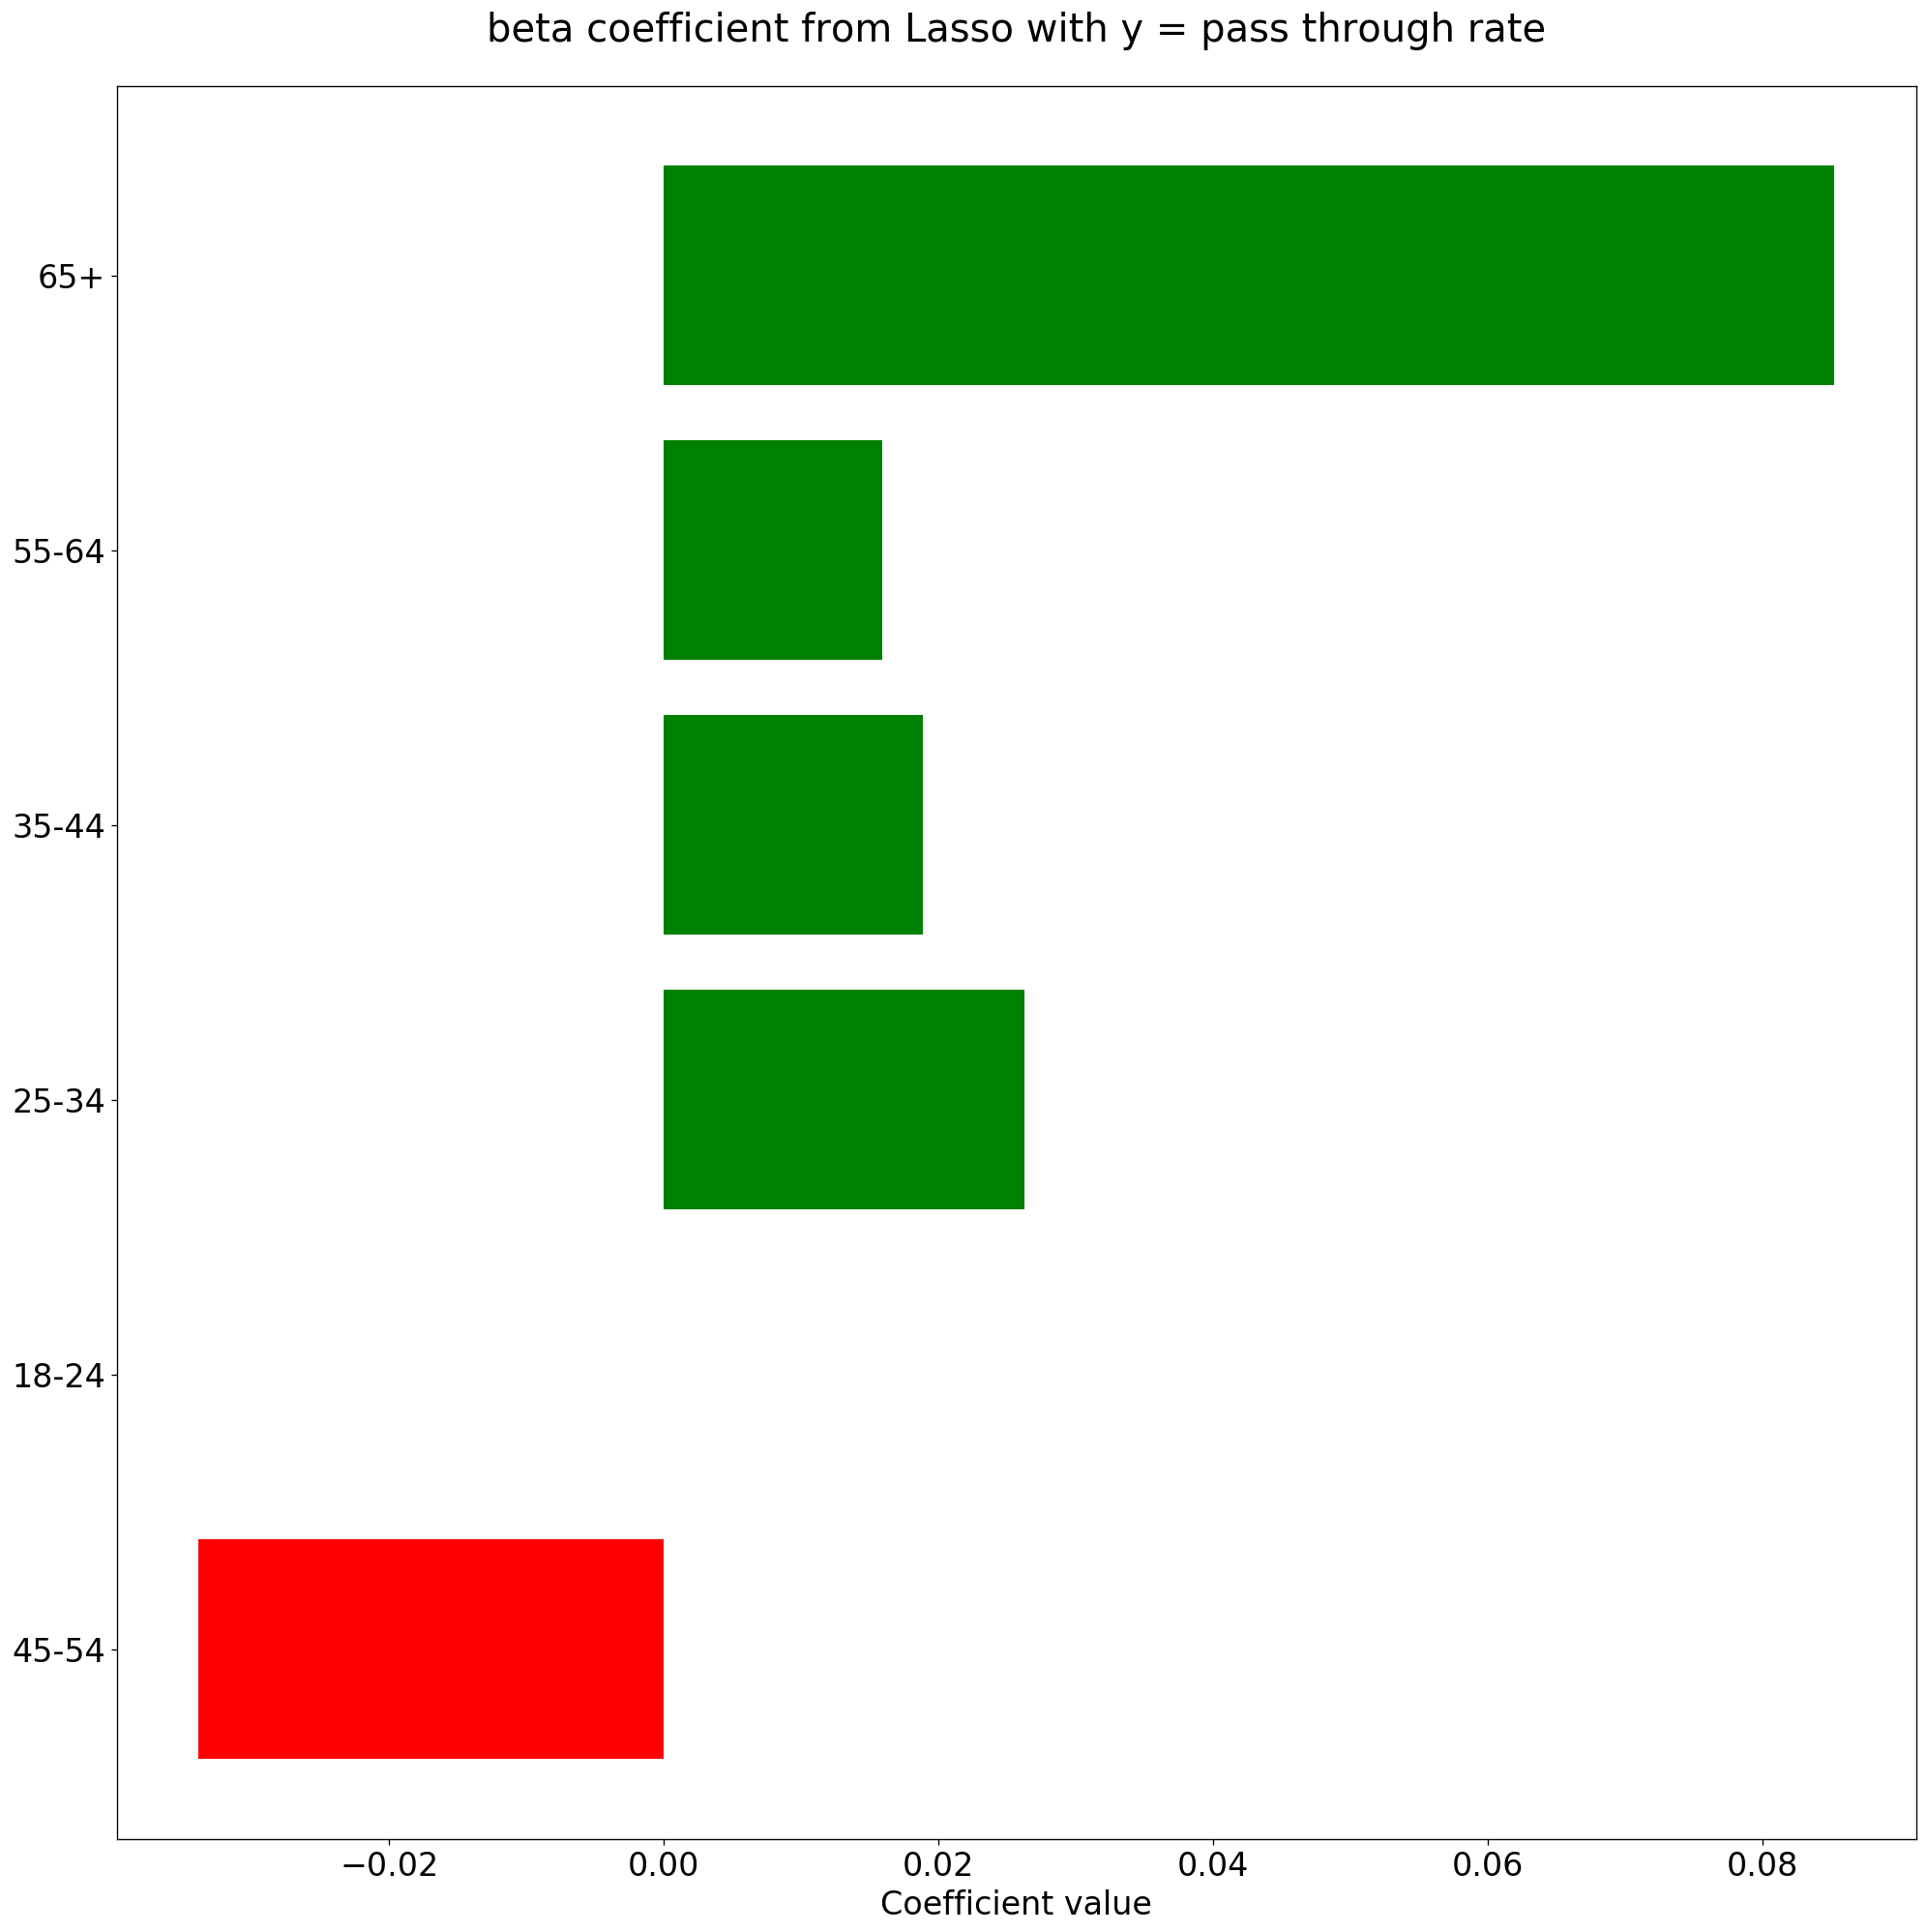

In [291]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(age_coefs_sign[mask2_coef]['age'], age_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(age_coefs_sign[mask1_coef]['age'], age_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Gender

In [292]:
gender_coefs_sign = positive_coef_col(gender_coefs)

In [293]:
mask1_coef = gender_coefs_sign['positive_coef'] == 1
mask2_coef = gender_coefs_sign['positive_coef'] == 0

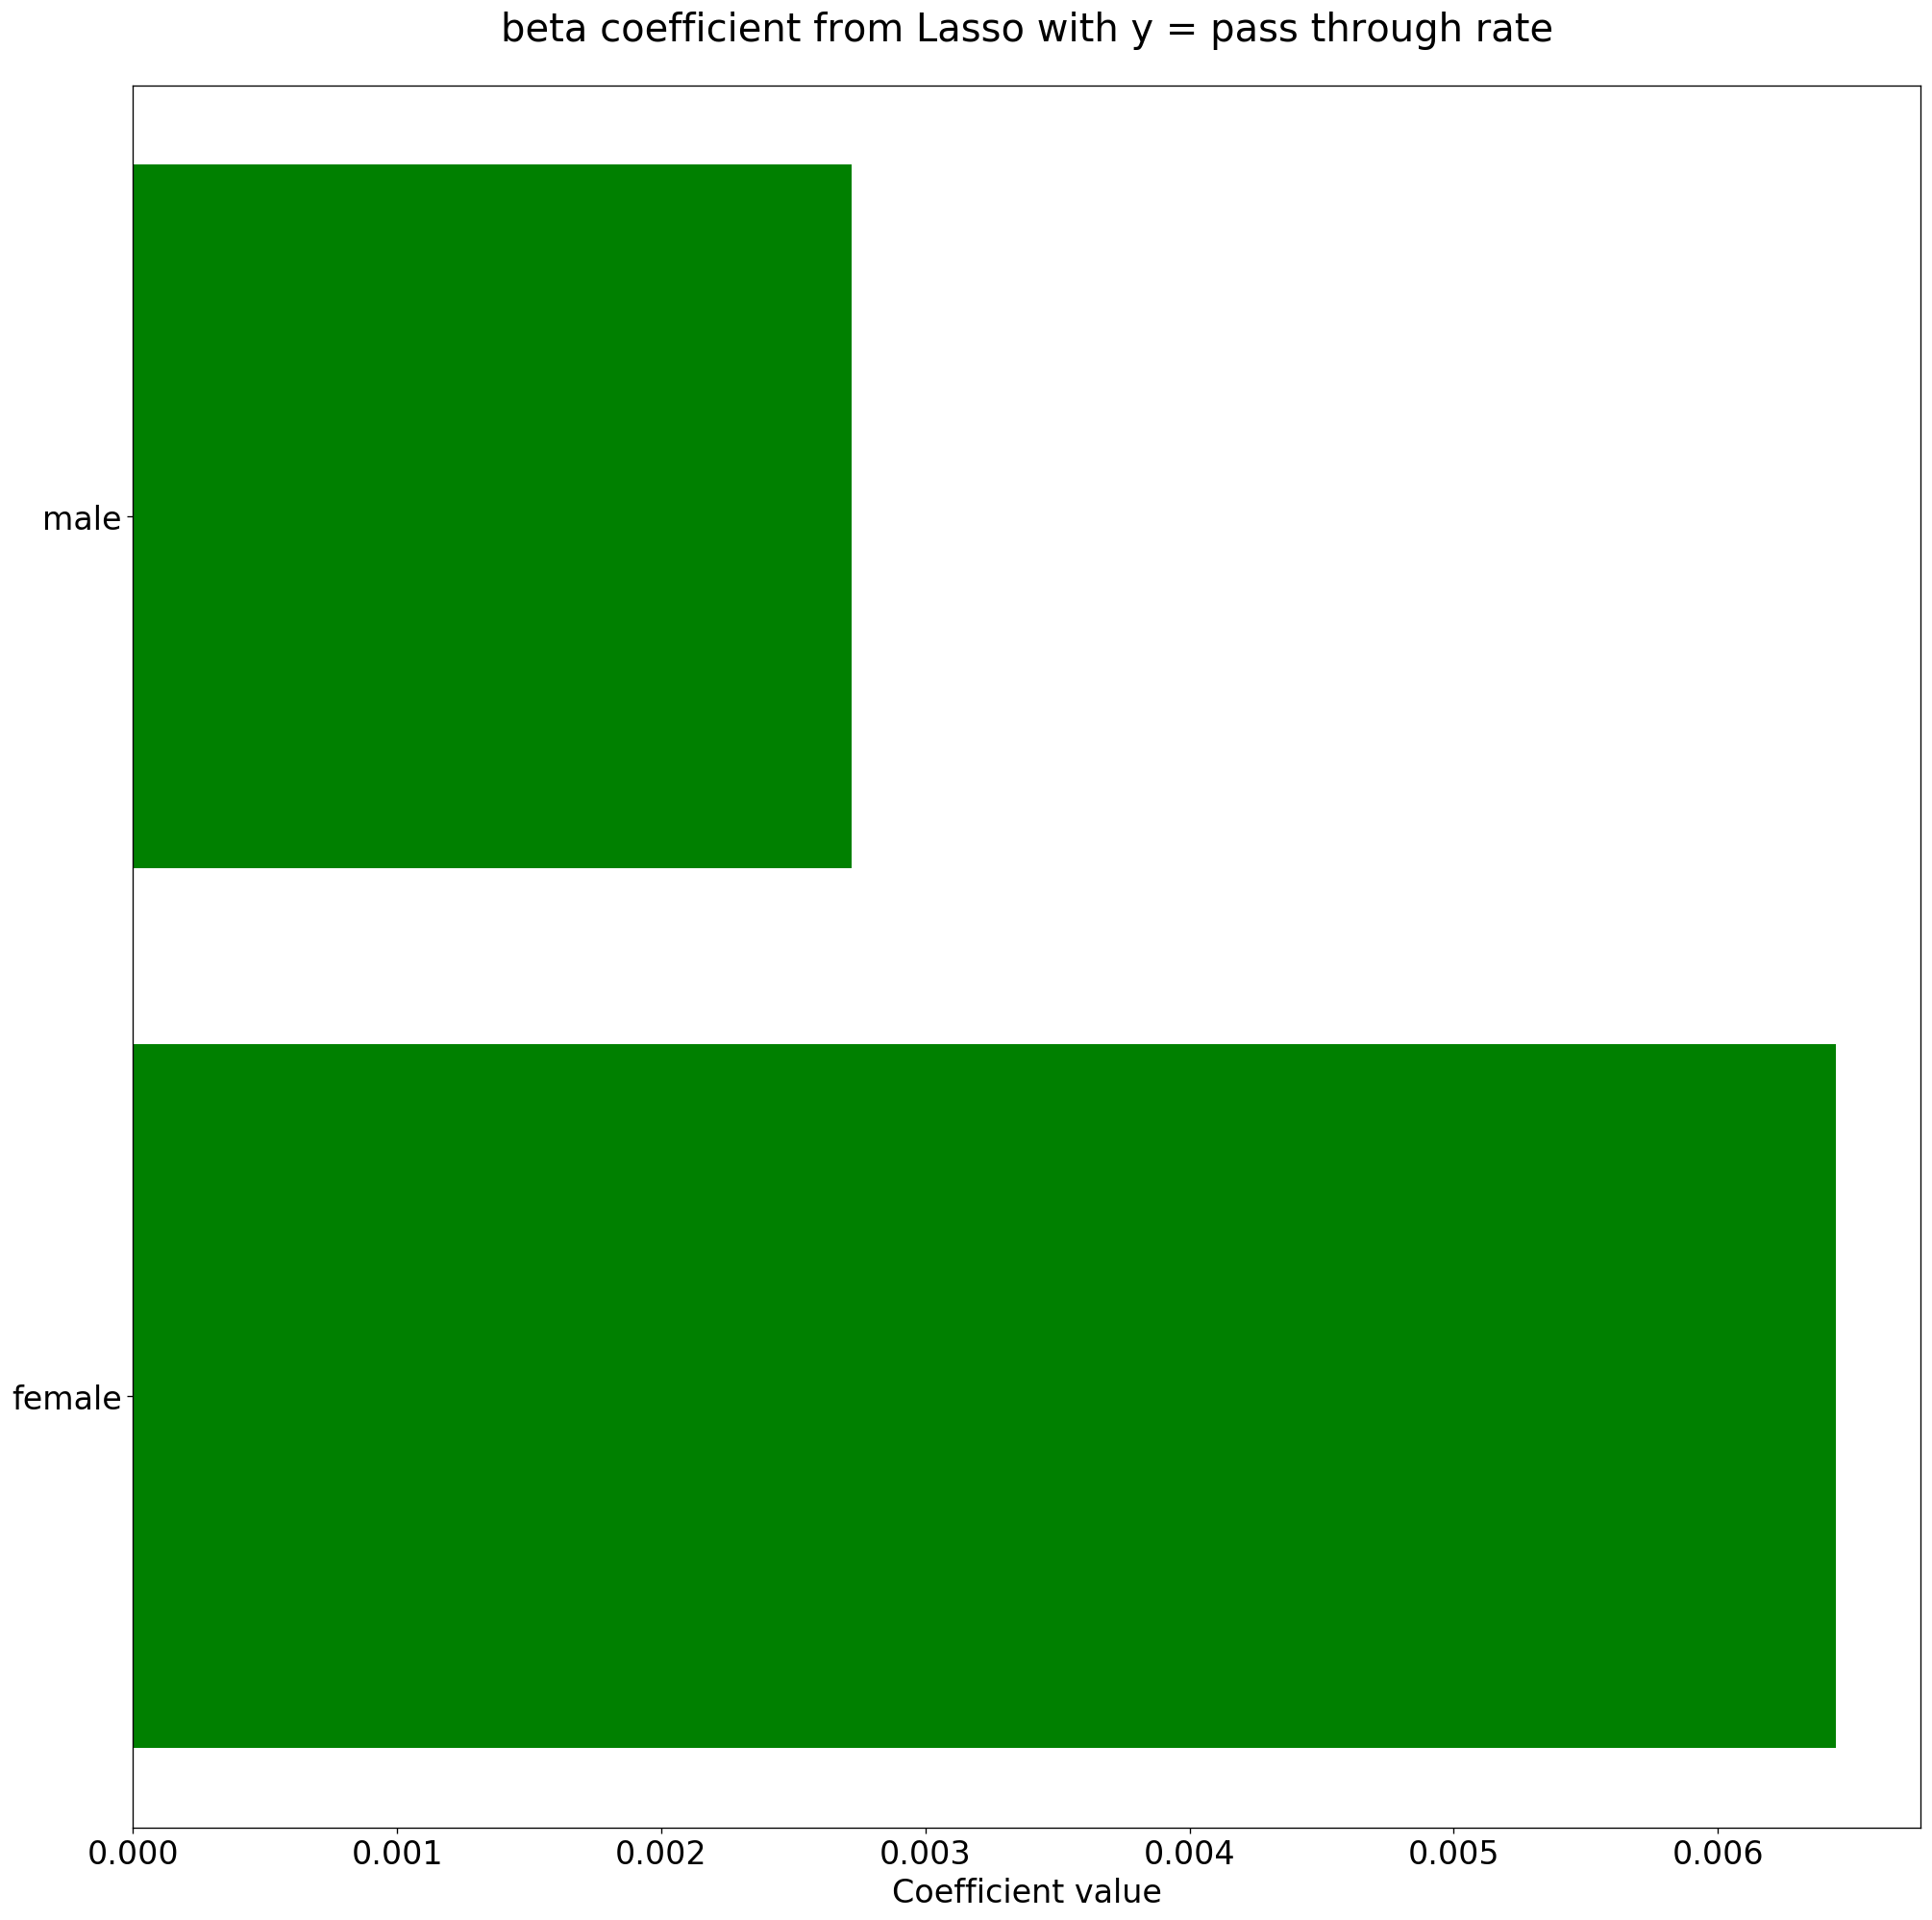

In [294]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(gender_coefs_sign[mask2_coef]['gender'], gender_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(gender_coefs_sign[mask1_coef]['gender'], gender_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

In [295]:
campaign_coefs_sign = positive_coef_col(campaign_coefs)

In [296]:
mask1_coef = campaign_coefs_sign['positive_coef'] == 1
mask2_coef = campaign_coefs_sign['positive_coef'] == 0

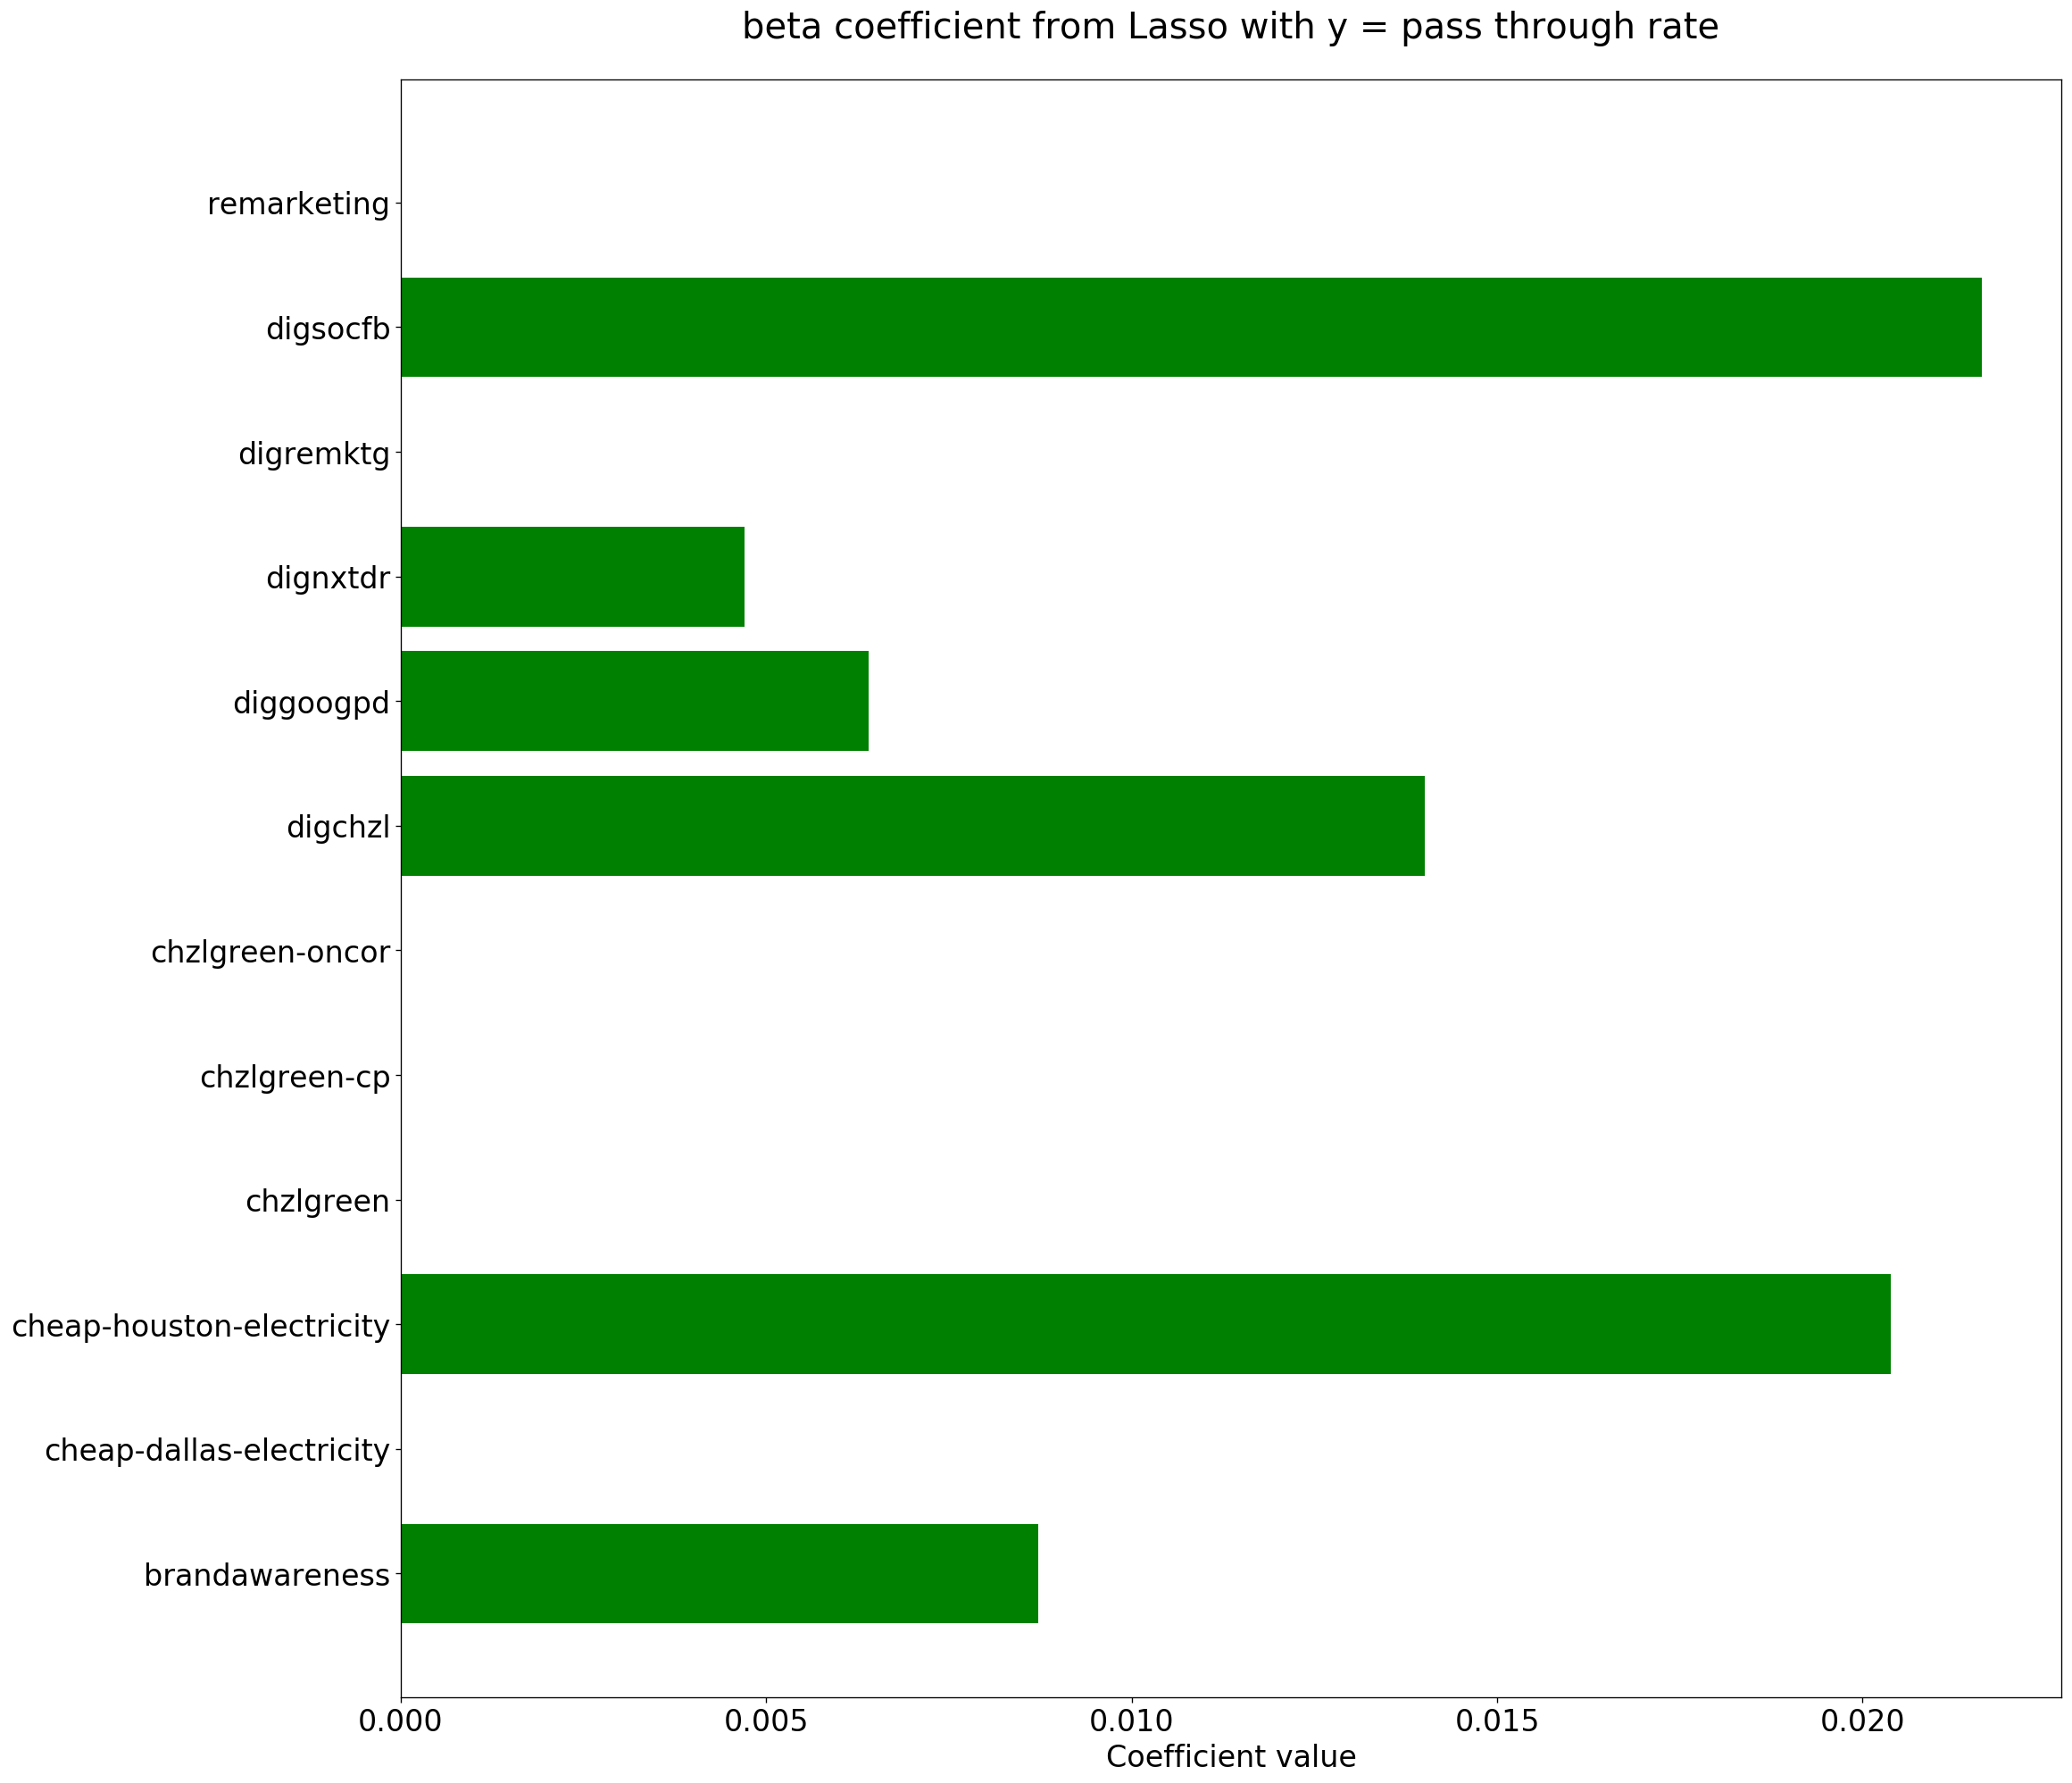

In [297]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(campaign_coefs_sign[mask2_coef]['campaign'], campaign_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(campaign_coefs_sign[mask1_coef]['campaign'], campaign_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## City

In [298]:
city_coefs_sign = positive_coef_col(city_coefs).sort_values(by = 'coefficient')

In [299]:
mask1_coef = city_coefs_sign['positive_coef'] == 1
mask2_coef = city_coefs_sign['positive_coef'] == 0

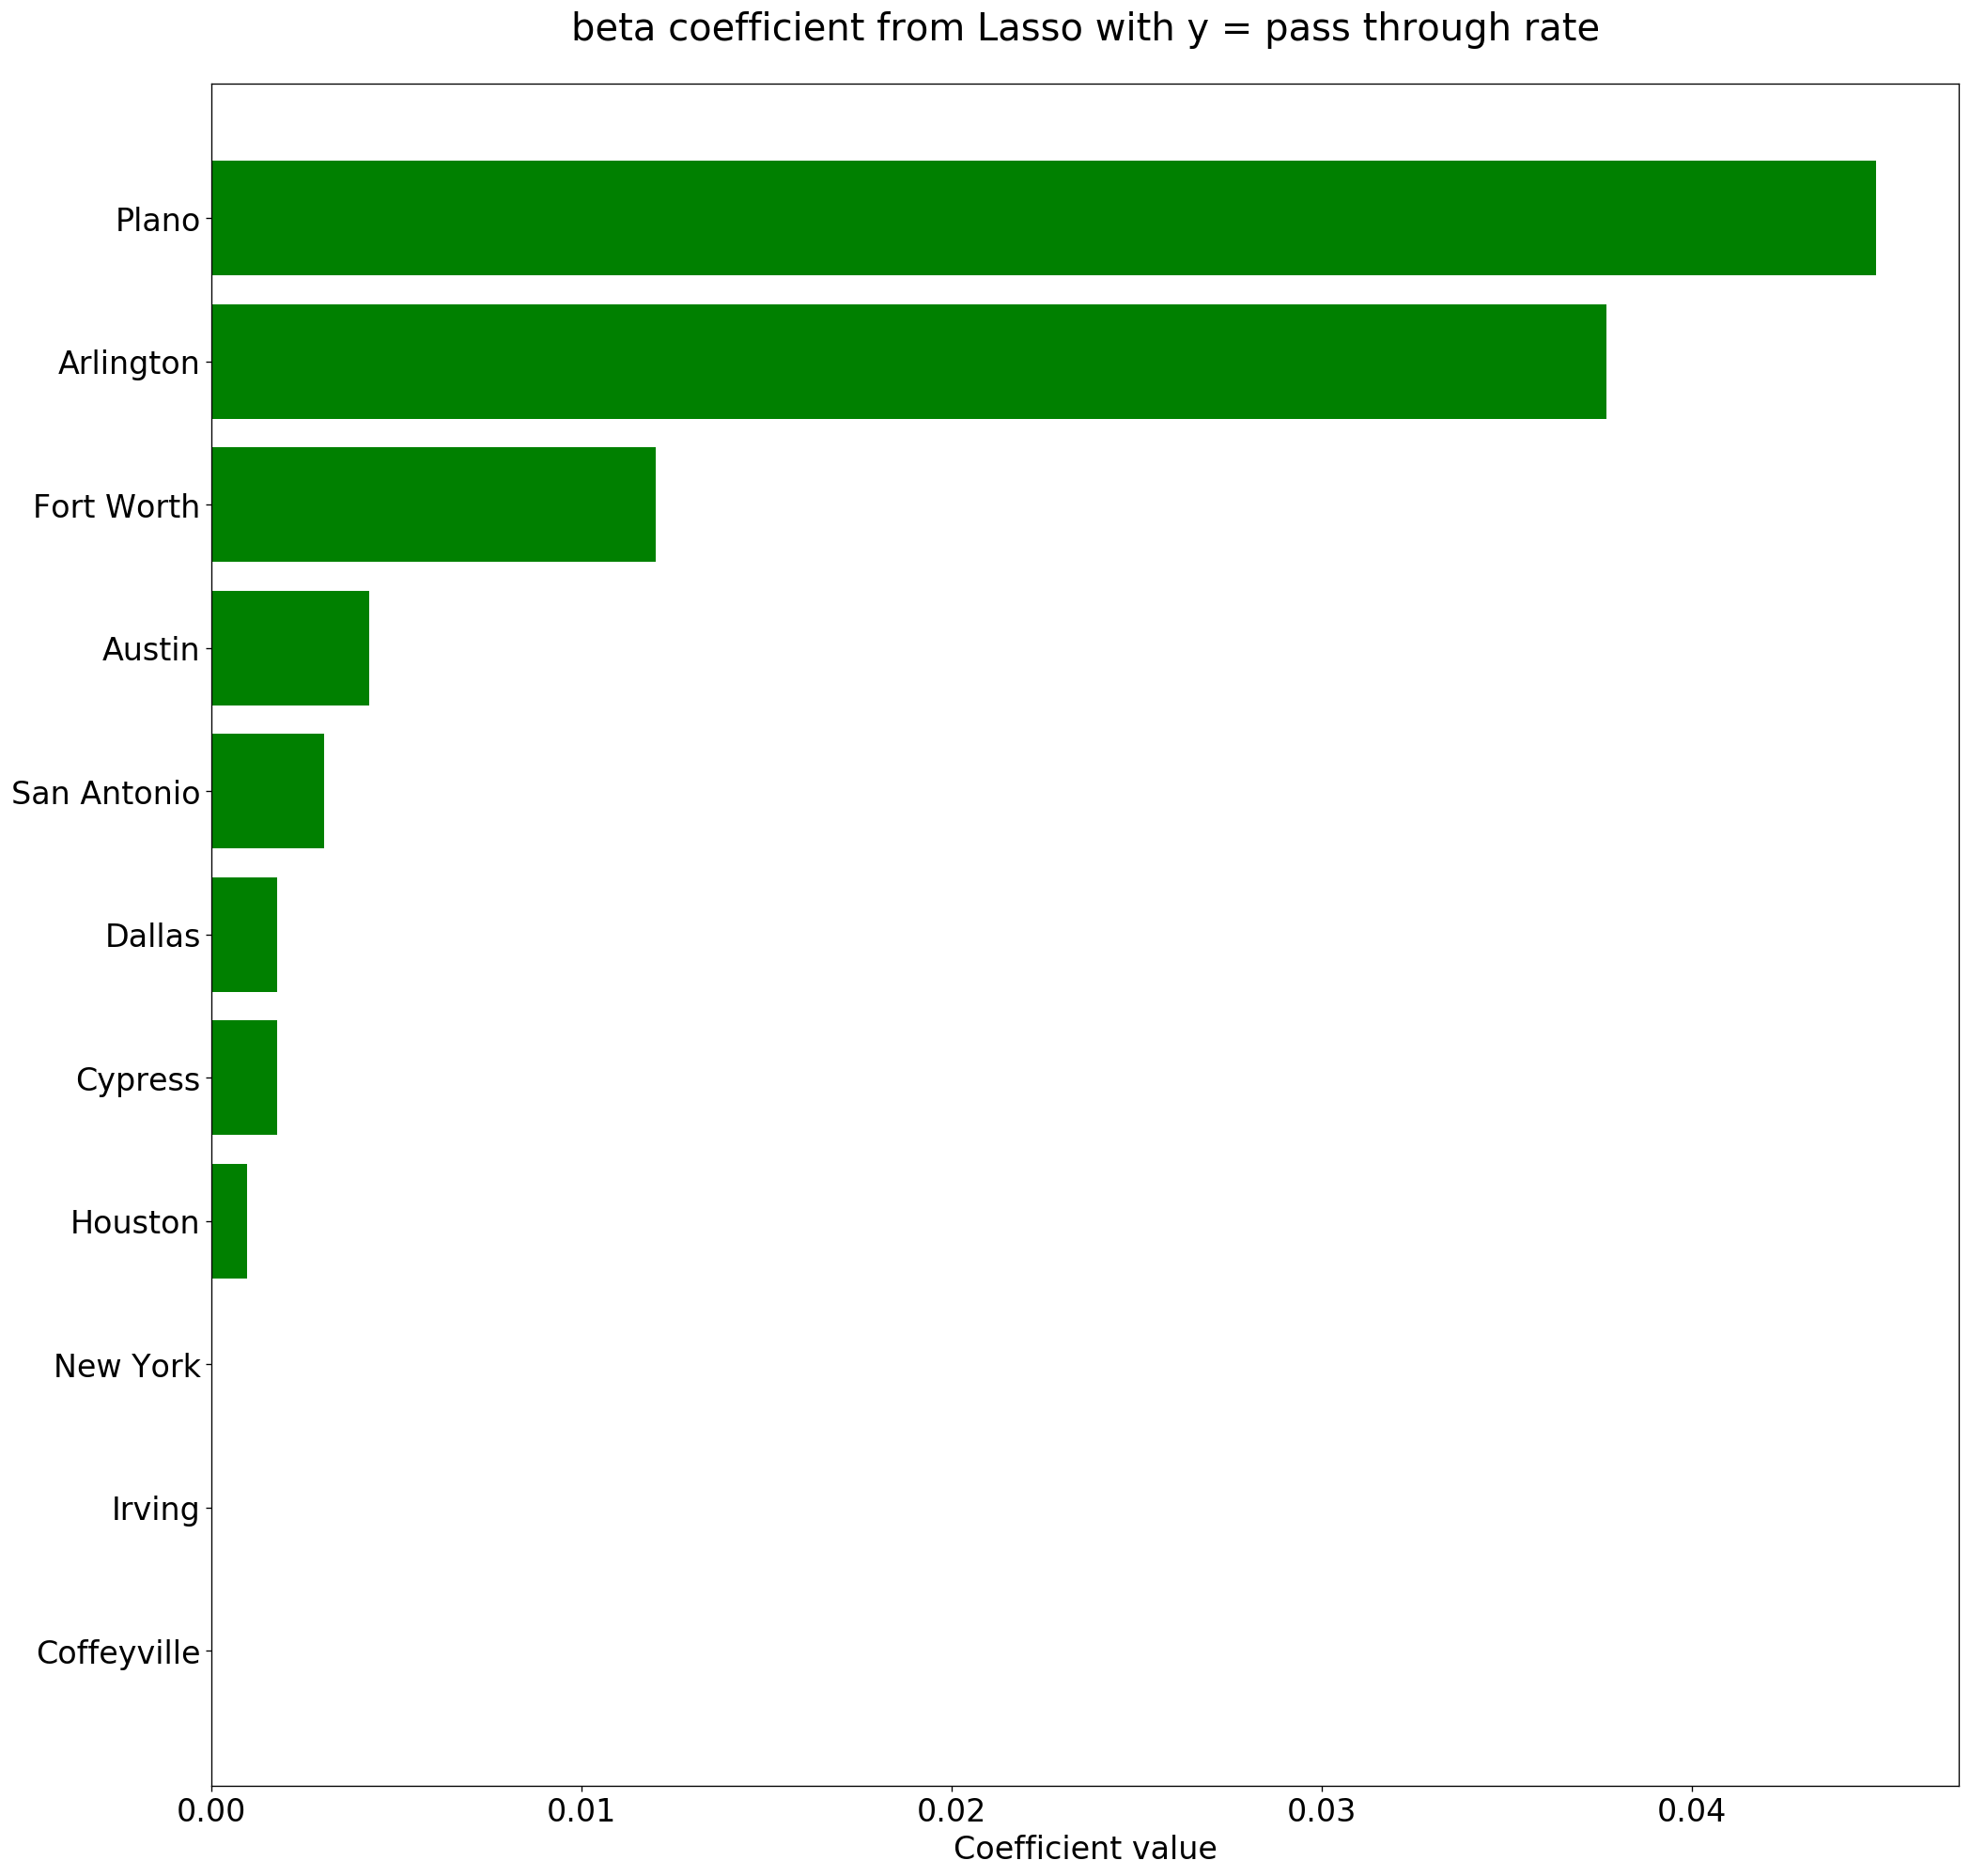

In [300]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(city_coefs_sign[mask2_coef]['city'], city_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(city_coefs_sign[mask1_coef]['city'], city_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Network

In [301]:
network_coefs_sign = positive_coef_col(network_coefs).sort_values(by = 'coefficient')

In [302]:
mask1_coef = network_coefs_sign['positive_coef'] == 1
mask2_coef = network_coefs_sign['positive_coef'] == 0

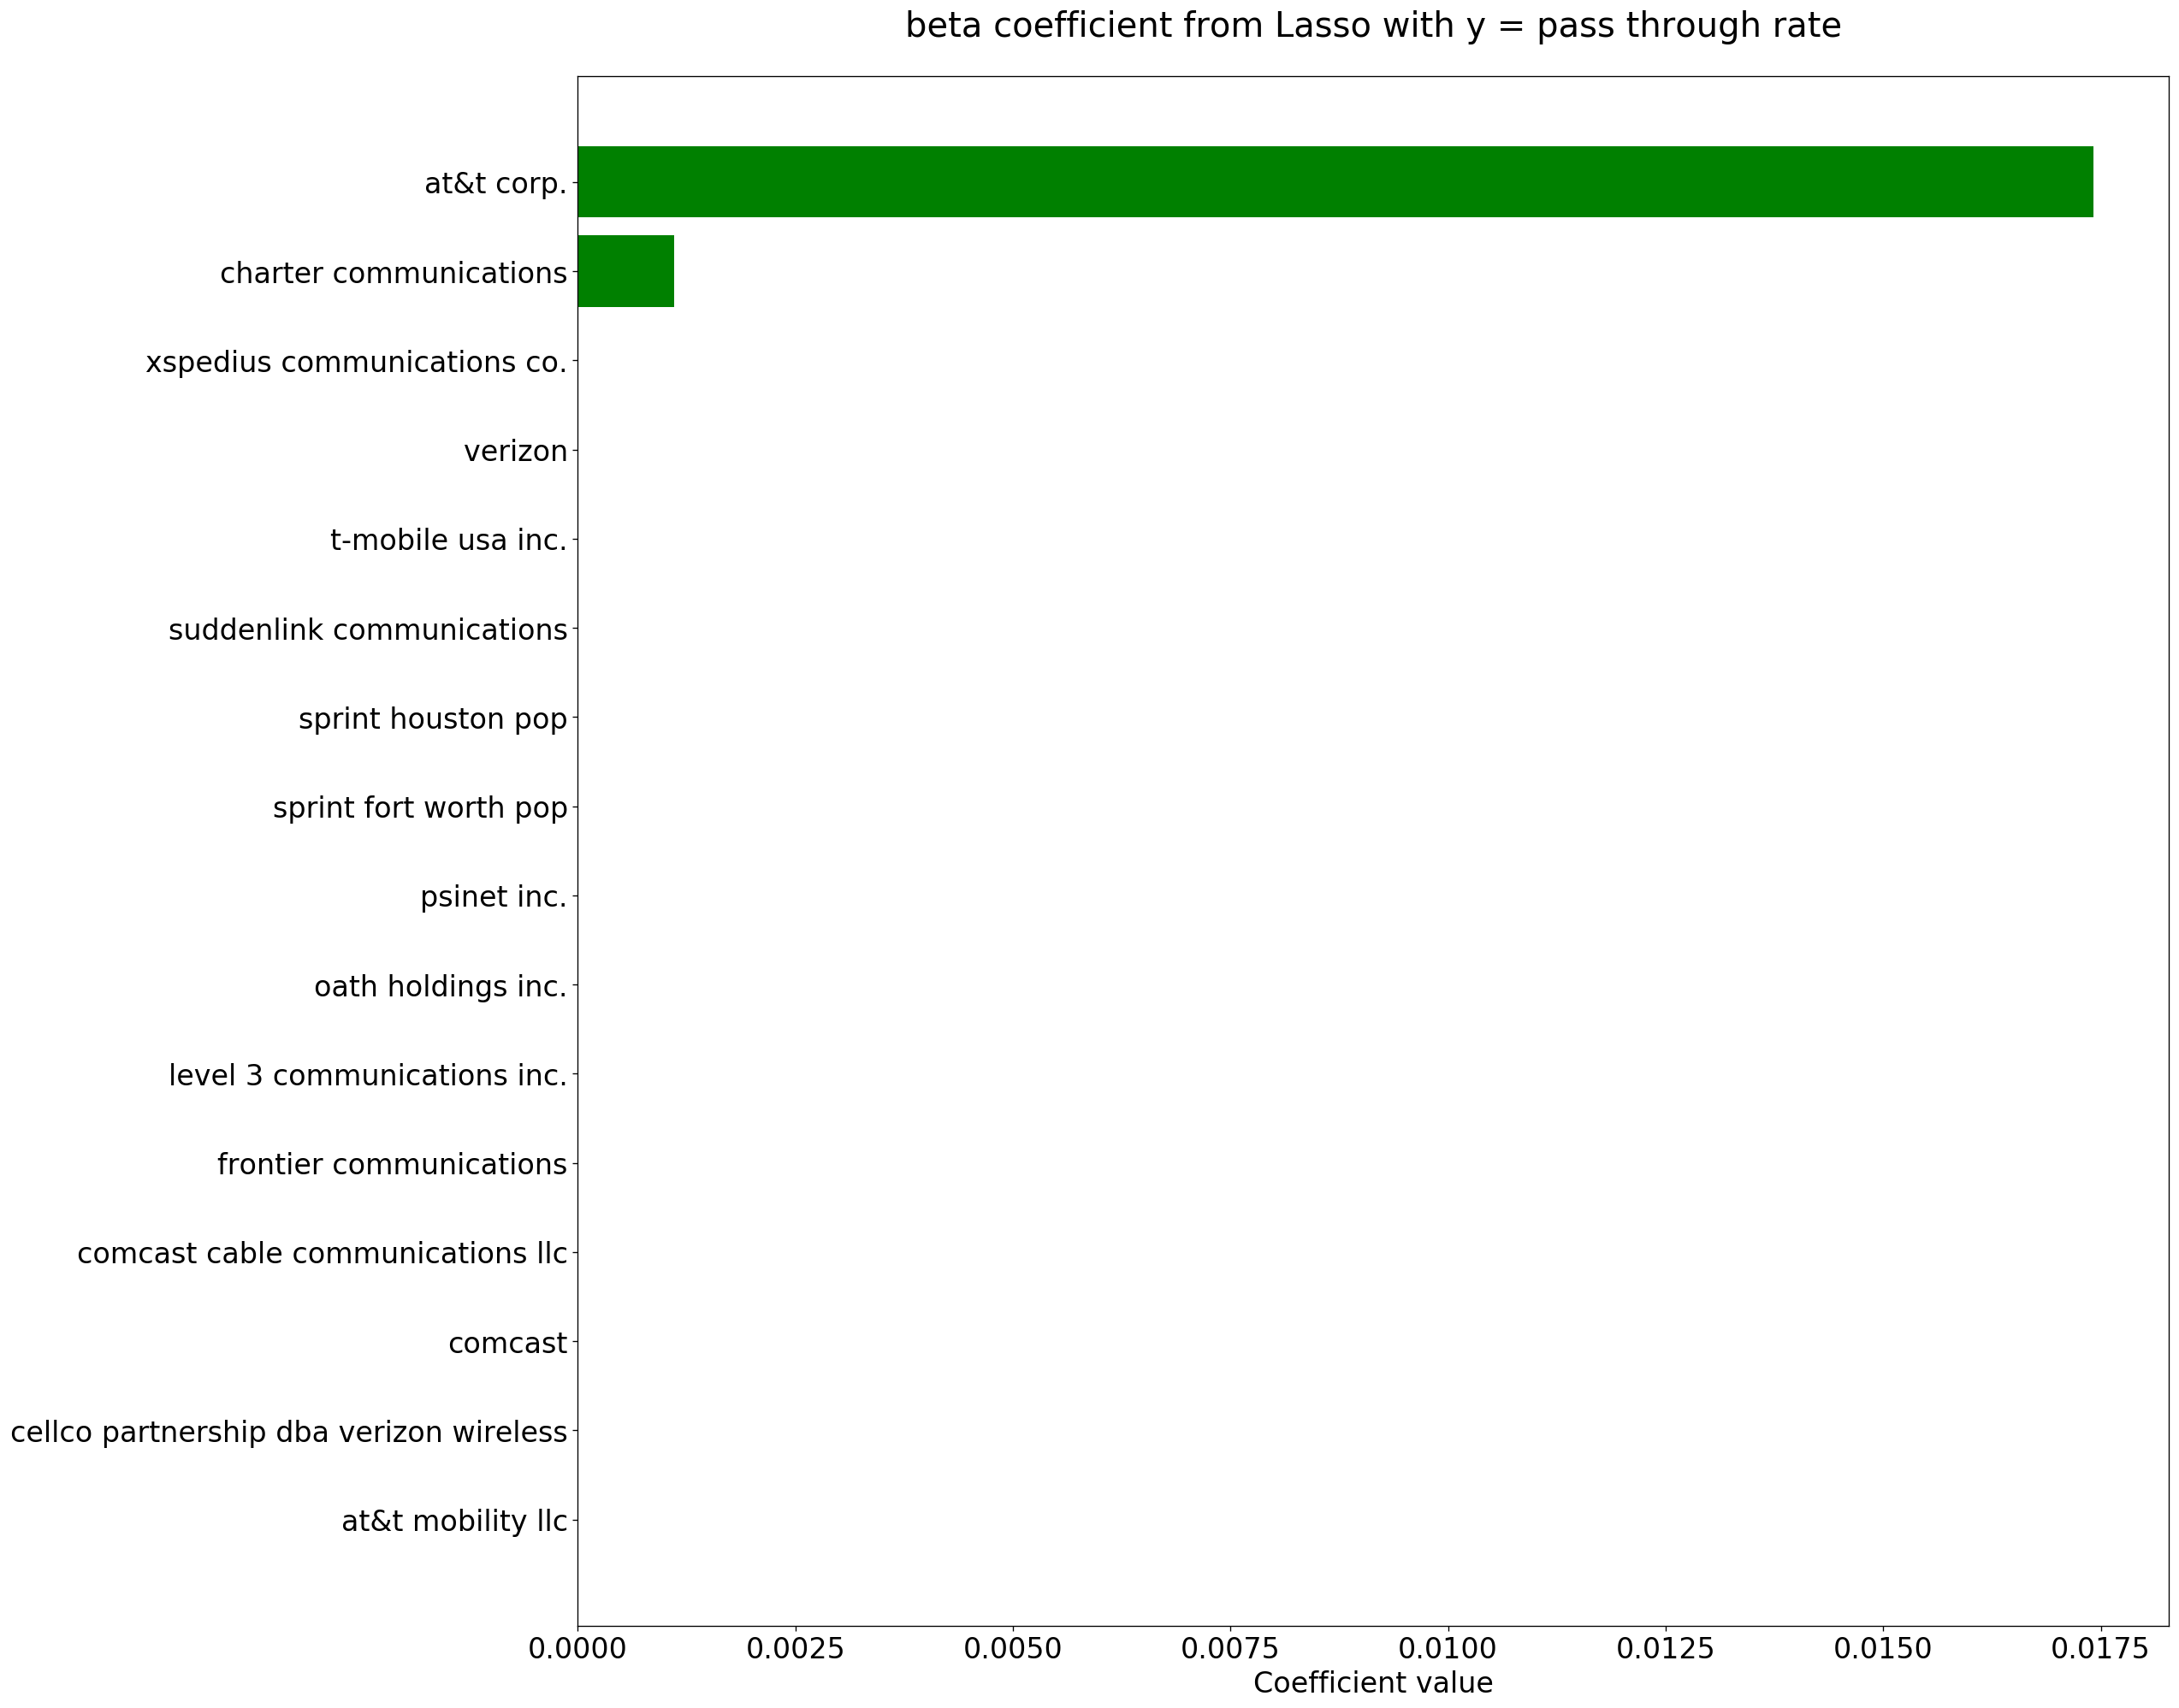

In [303]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(network_coefs_sign[mask2_coef]['network'], network_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(network_coefs_sign[mask1_coef]['network'], network_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Language

In [304]:
language_coefs_sign = positive_coef_col(language_coefs).sort_values(by = 'coefficient')

In [305]:
mask1_coef = language_coefs_sign['positive_coef'] == 1
mask2_coef = language_coefs_sign['positive_coef'] == 0

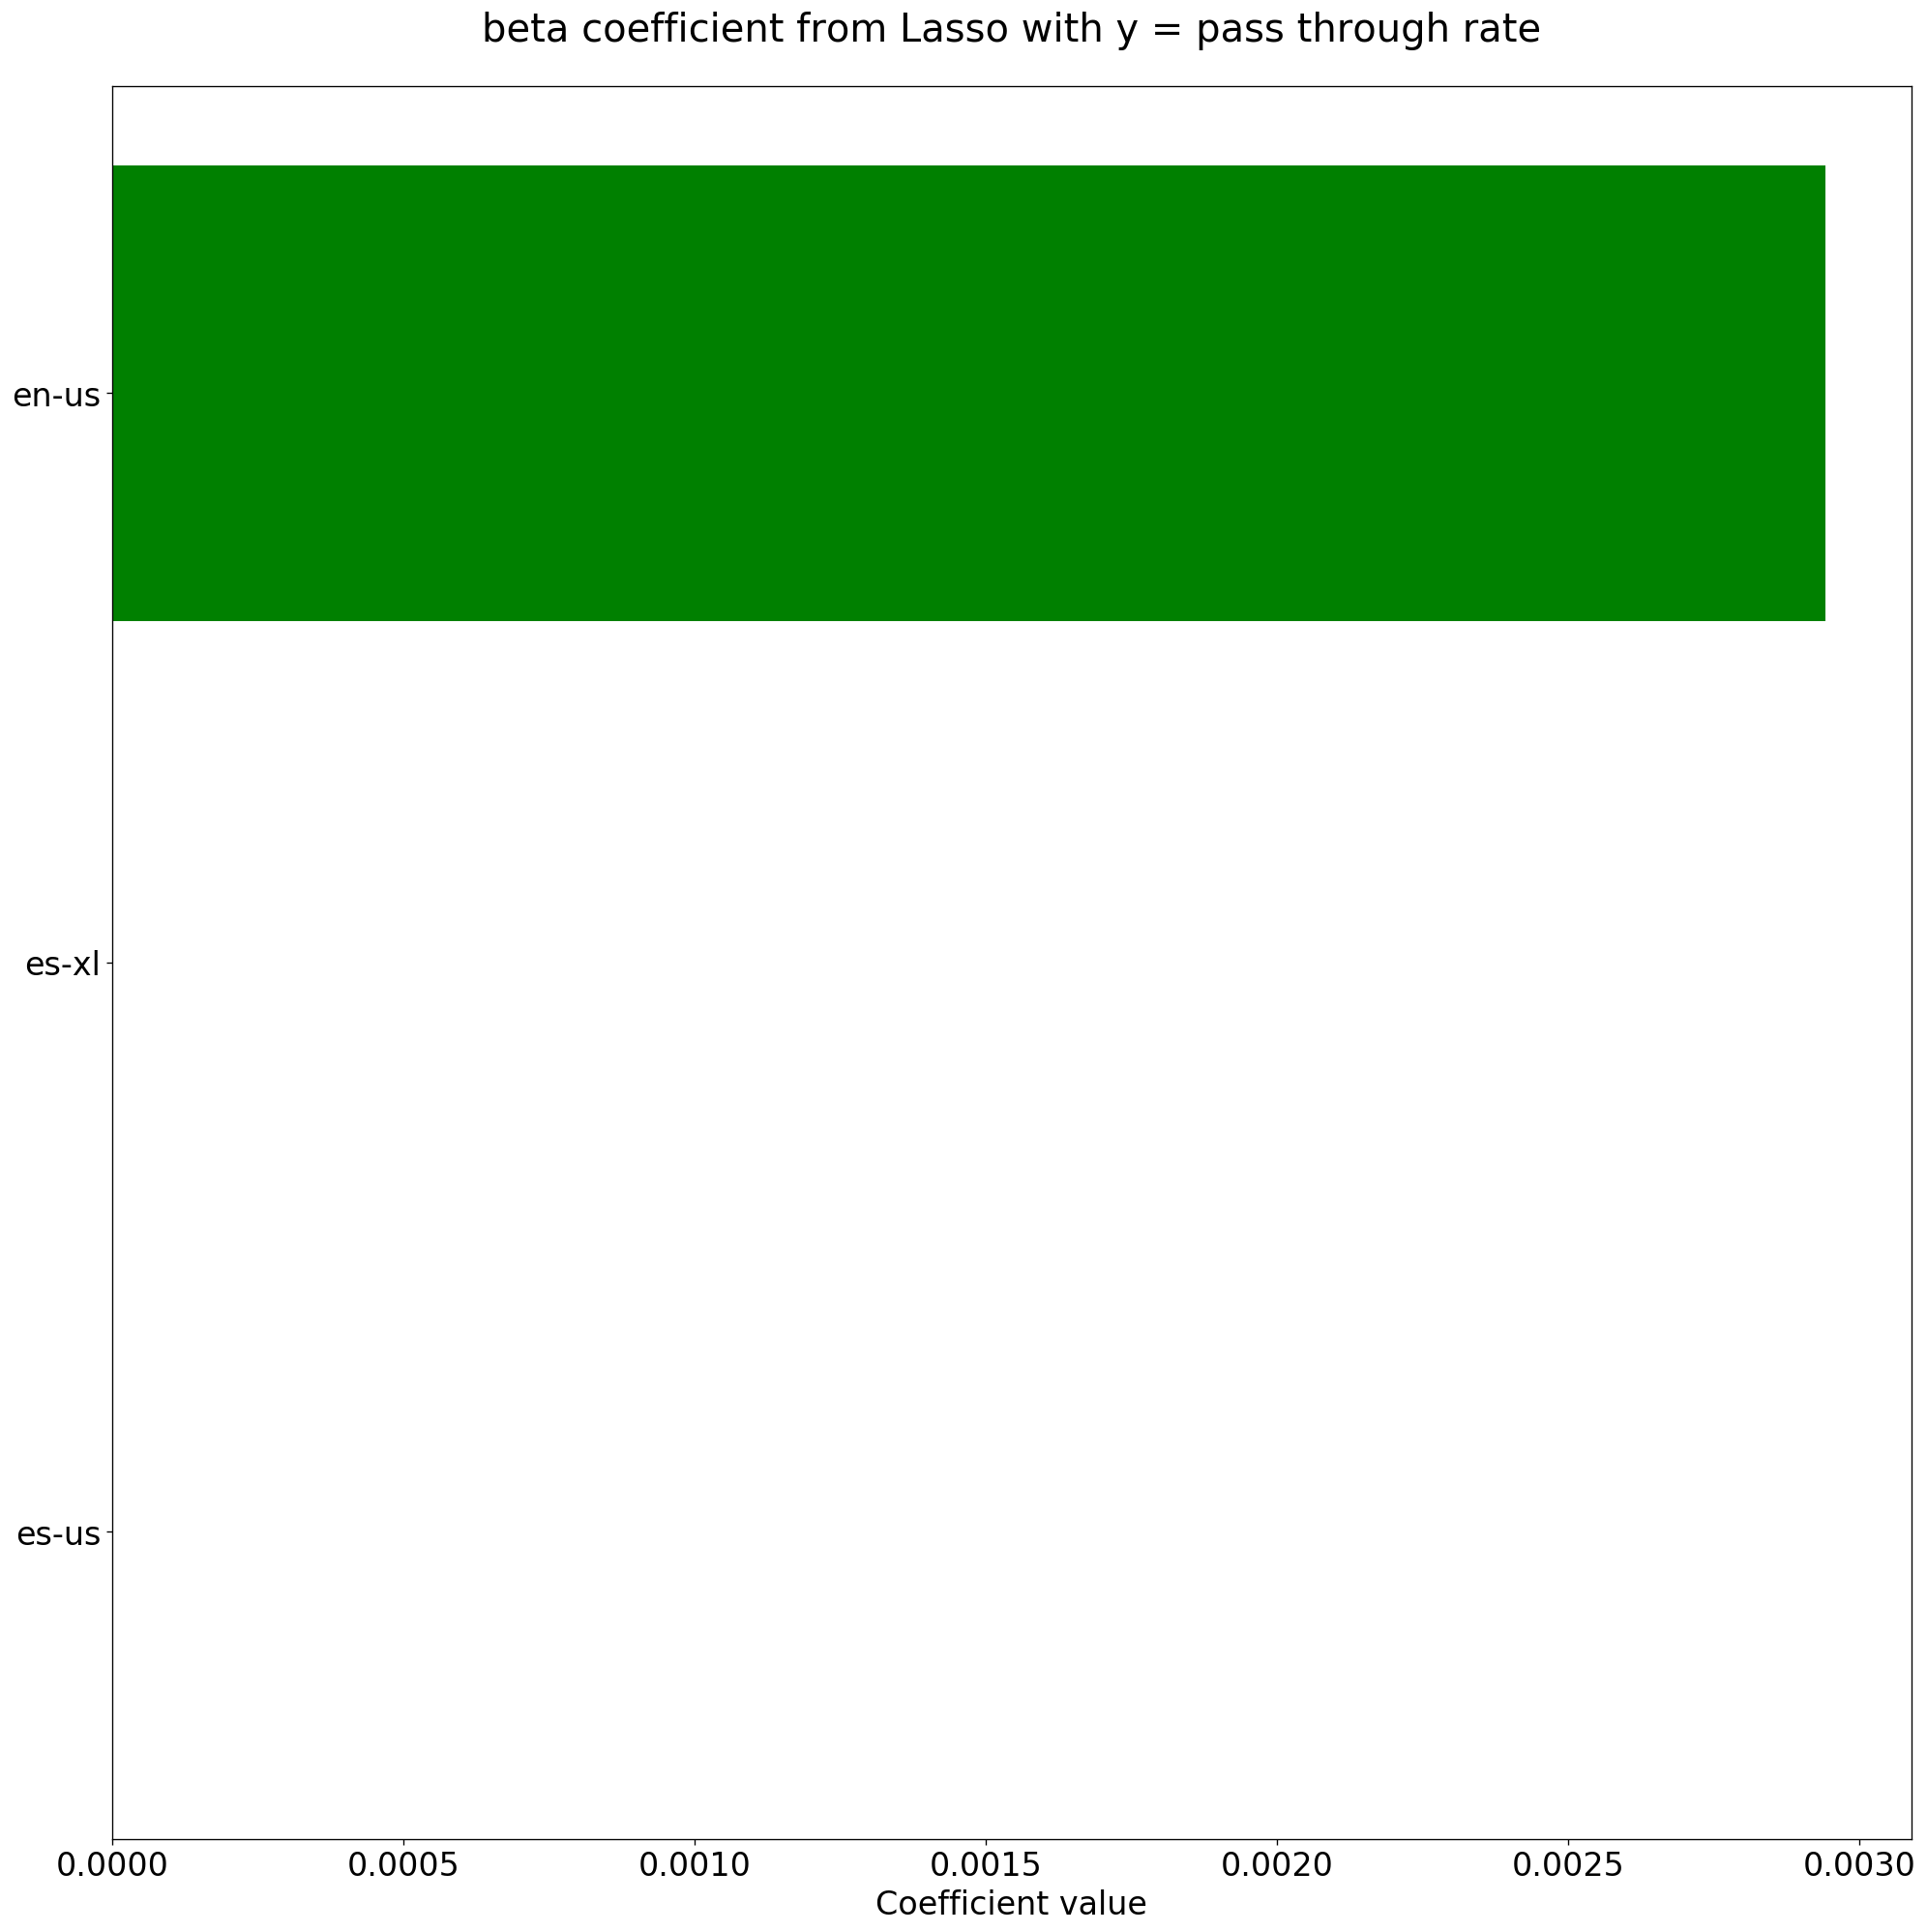

In [306]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(language_coefs_sign[mask2_coef]['language'], language_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(language_coefs_sign[mask1_coef]['language'], language_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Affinity

In [307]:
affinity_coefs_sign = positive_coef_col(affinity_coefs).sort_values(by = 'coefficient')

In [308]:
mask1_coef = affinity_coefs_sign['positive_coef'] == 1
mask2_coef = affinity_coefs_sign['positive_coef'] == 0

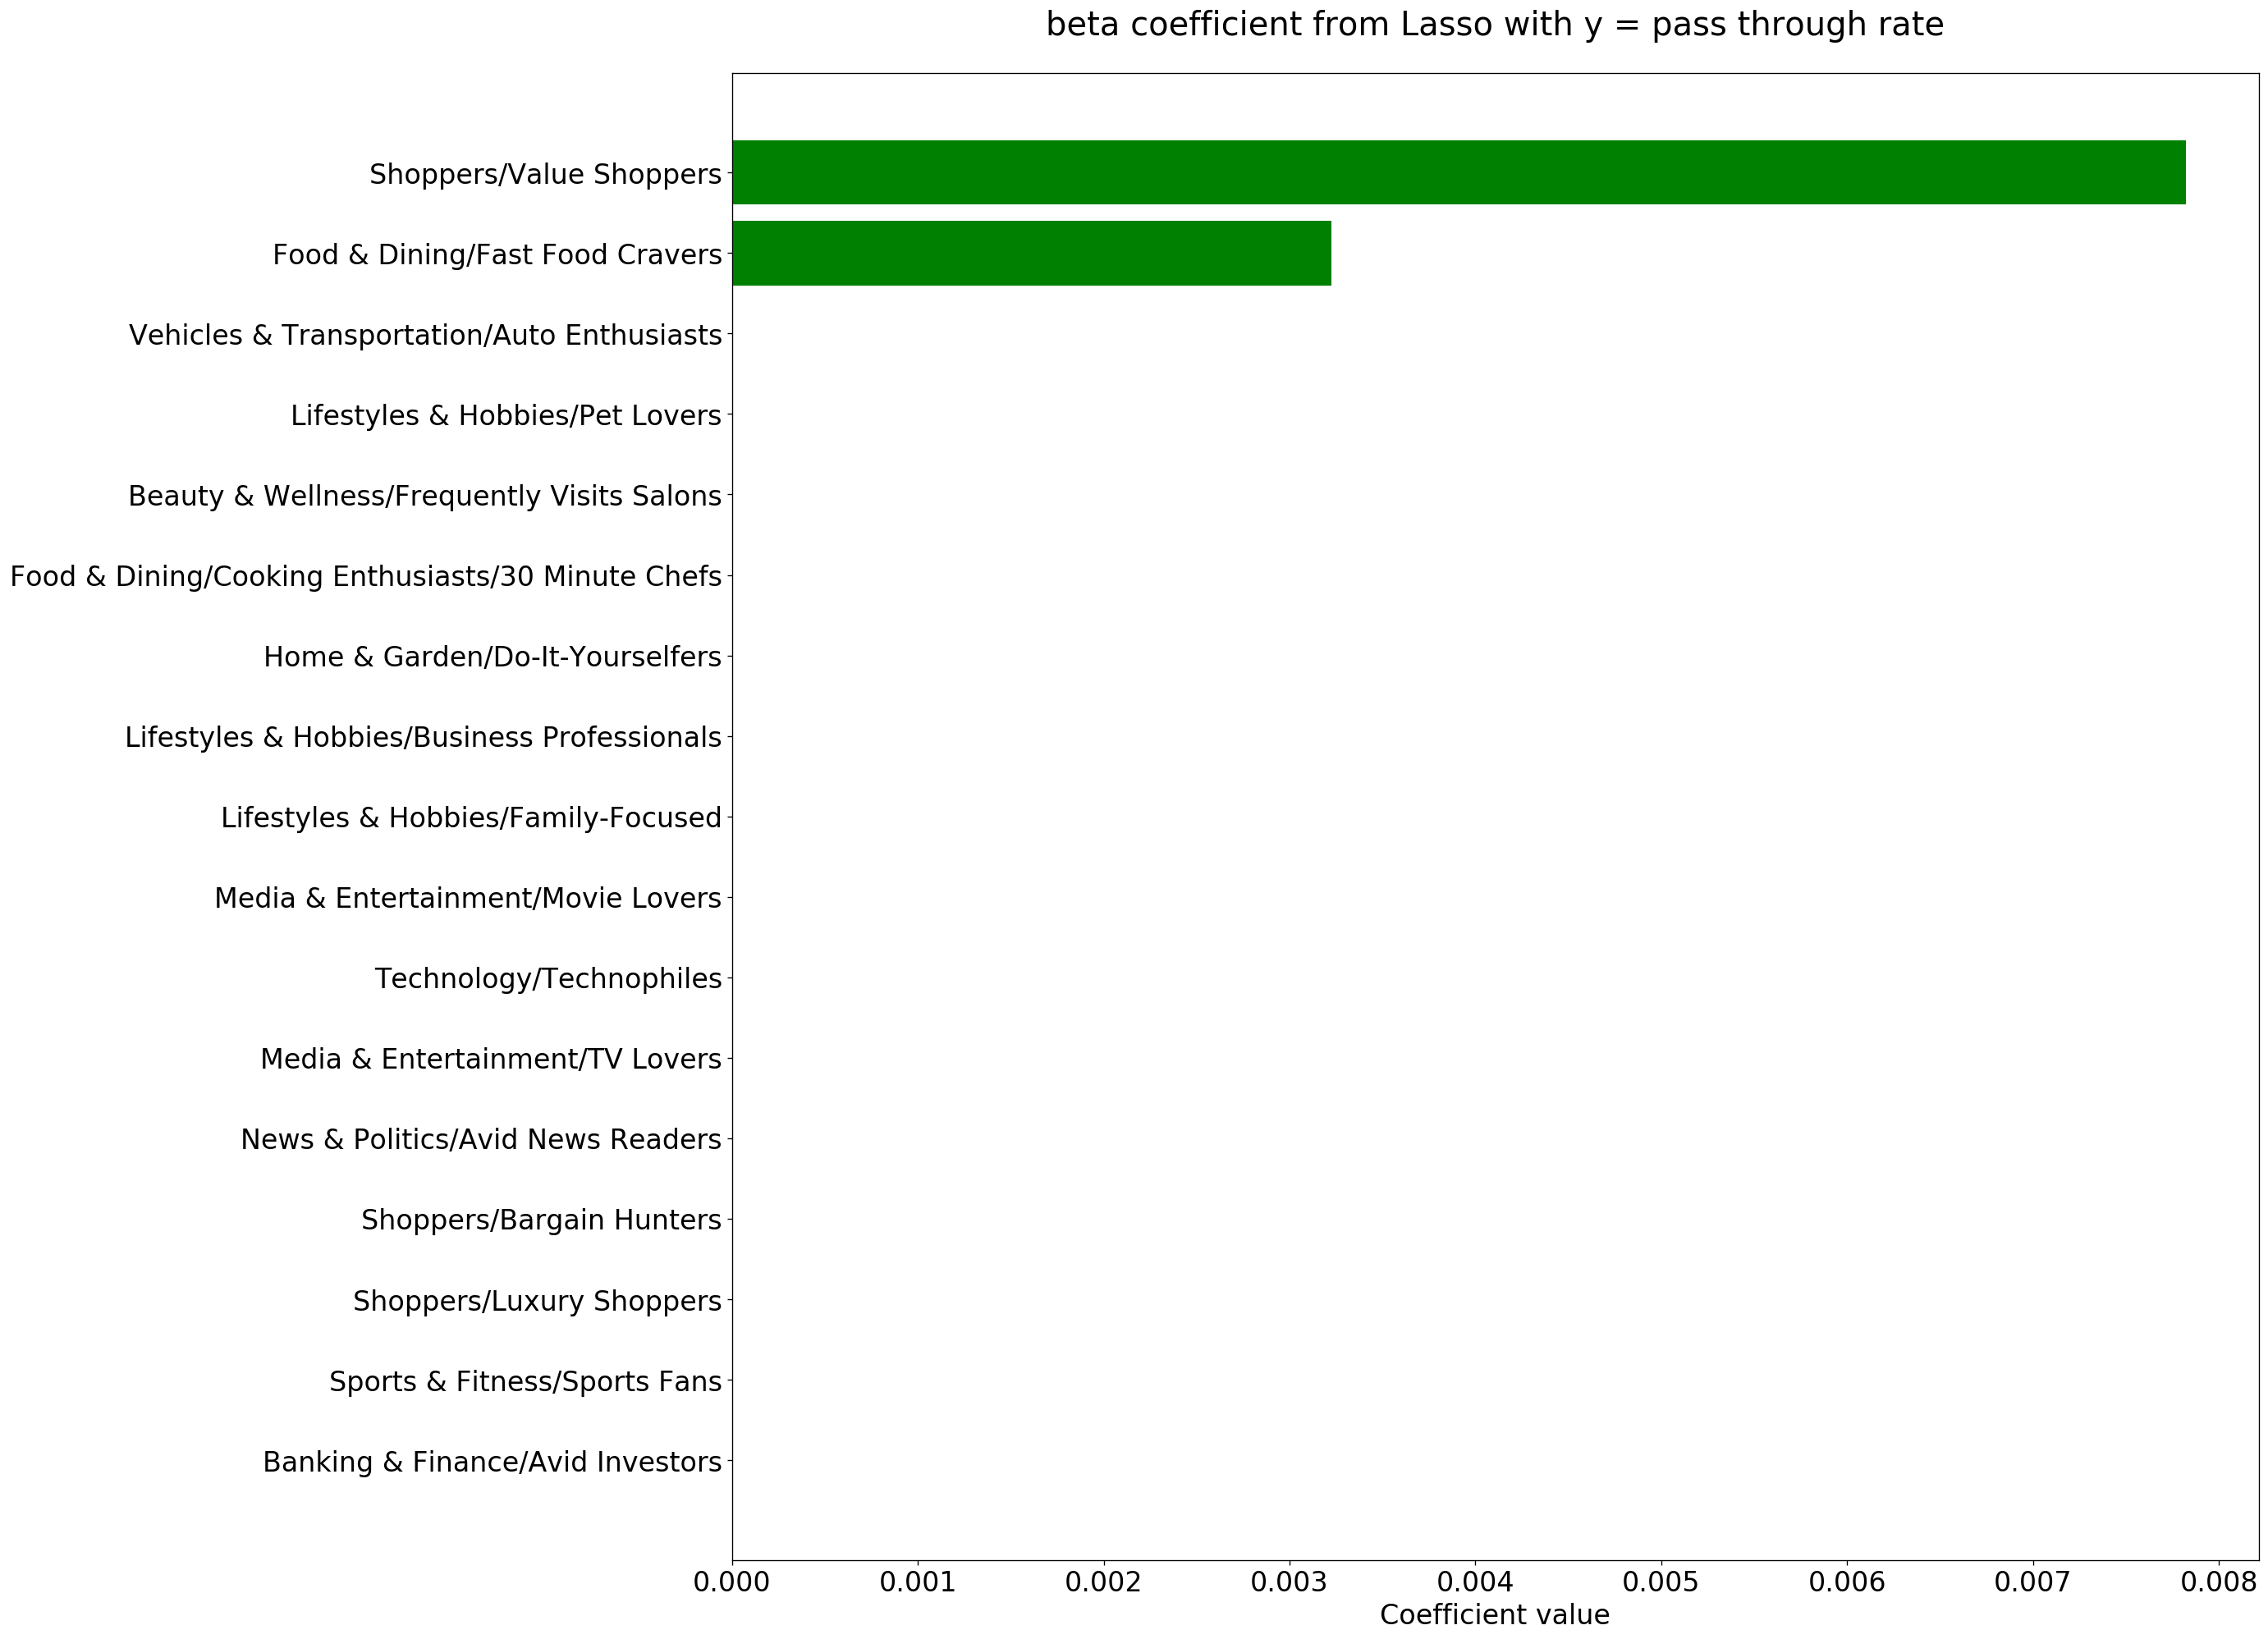

In [309]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(affinity_coefs_sign[mask2_coef]['affinity'], affinity_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(affinity_coefs_sign[mask1_coef]['affinity'], affinity_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## OS

In [310]:
os_coefs_sign = positive_coef_col(os_coefs).sort_values(by = 'coefficient')

In [311]:
mask1_coef = os_coefs_sign['positive_coef'] == 1
mask2_coef = os_coefs_sign['positive_coef'] == 0

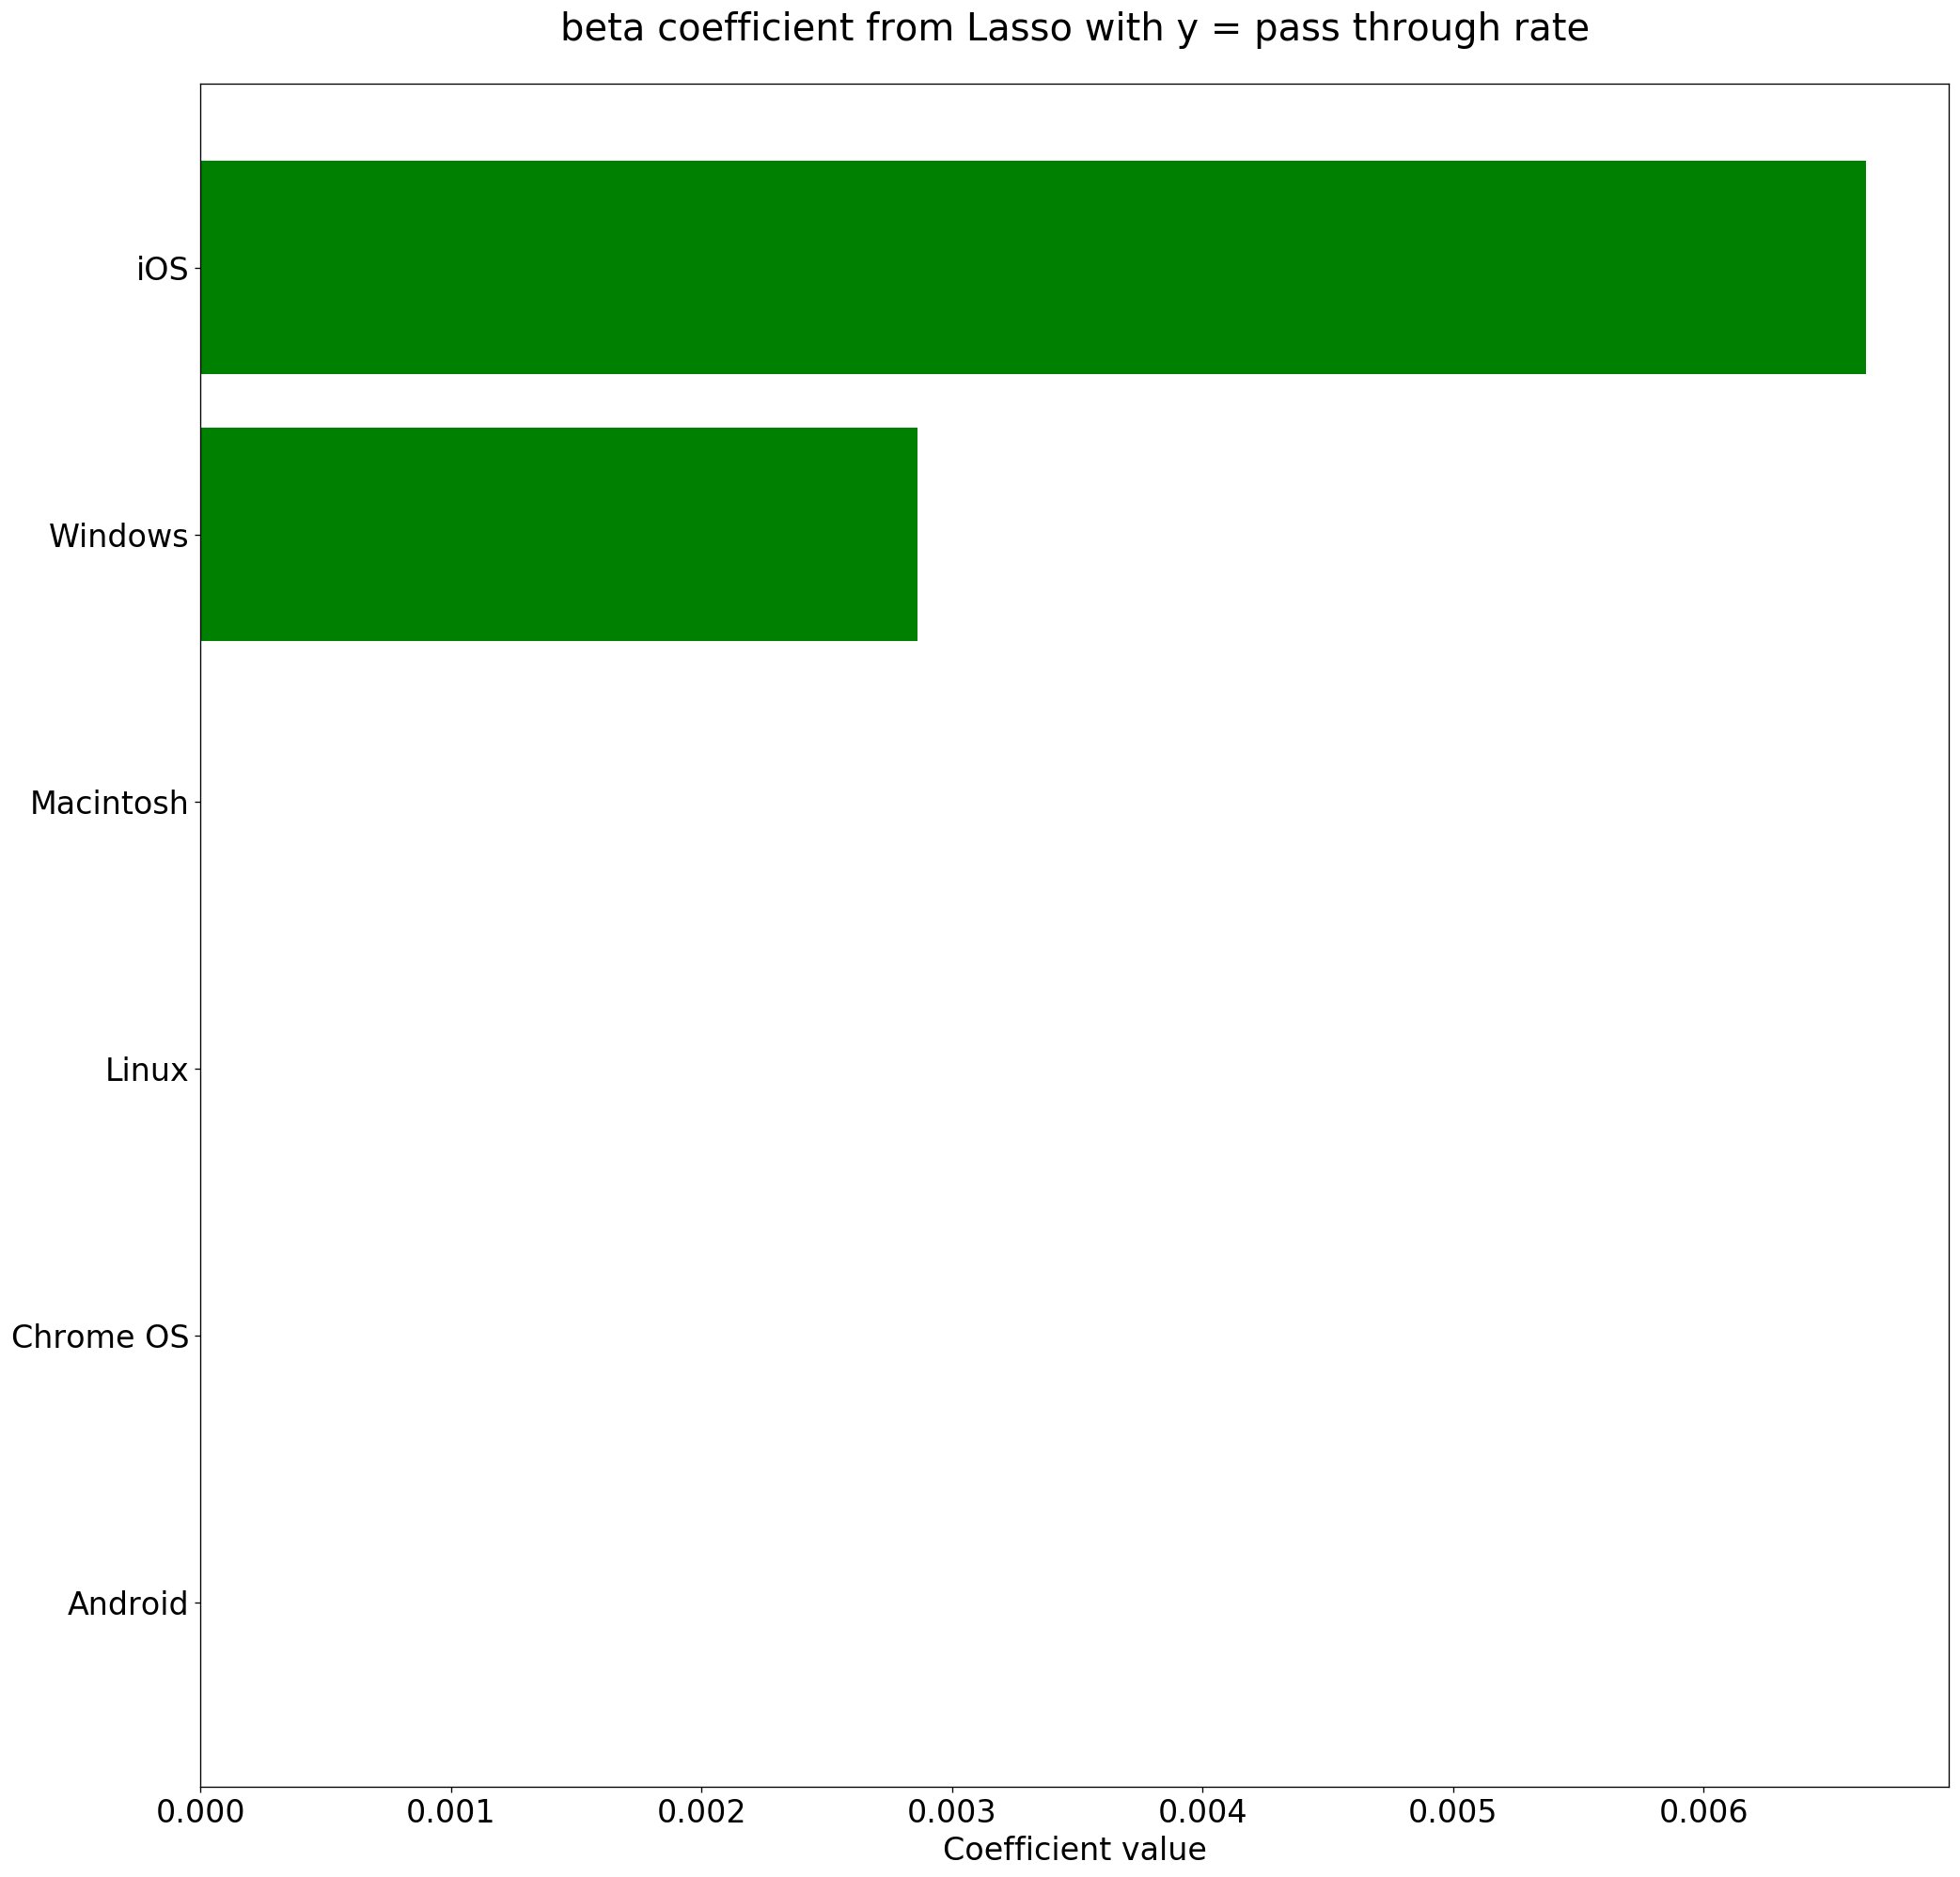

In [312]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(os_coefs_sign[mask2_coef]['os'], os_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(os_coefs_sign[mask1_coef]['os'], os_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Device Brand

In [313]:
device_brand_coefs_sign = positive_coef_col(device_brand_coefs).sort_values(by = 'coefficient')

In [314]:
mask1_coef = device_brand_coefs_sign['positive_coef'] == 1
mask2_coef = device_brand_coefs_sign['positive_coef'] == 0

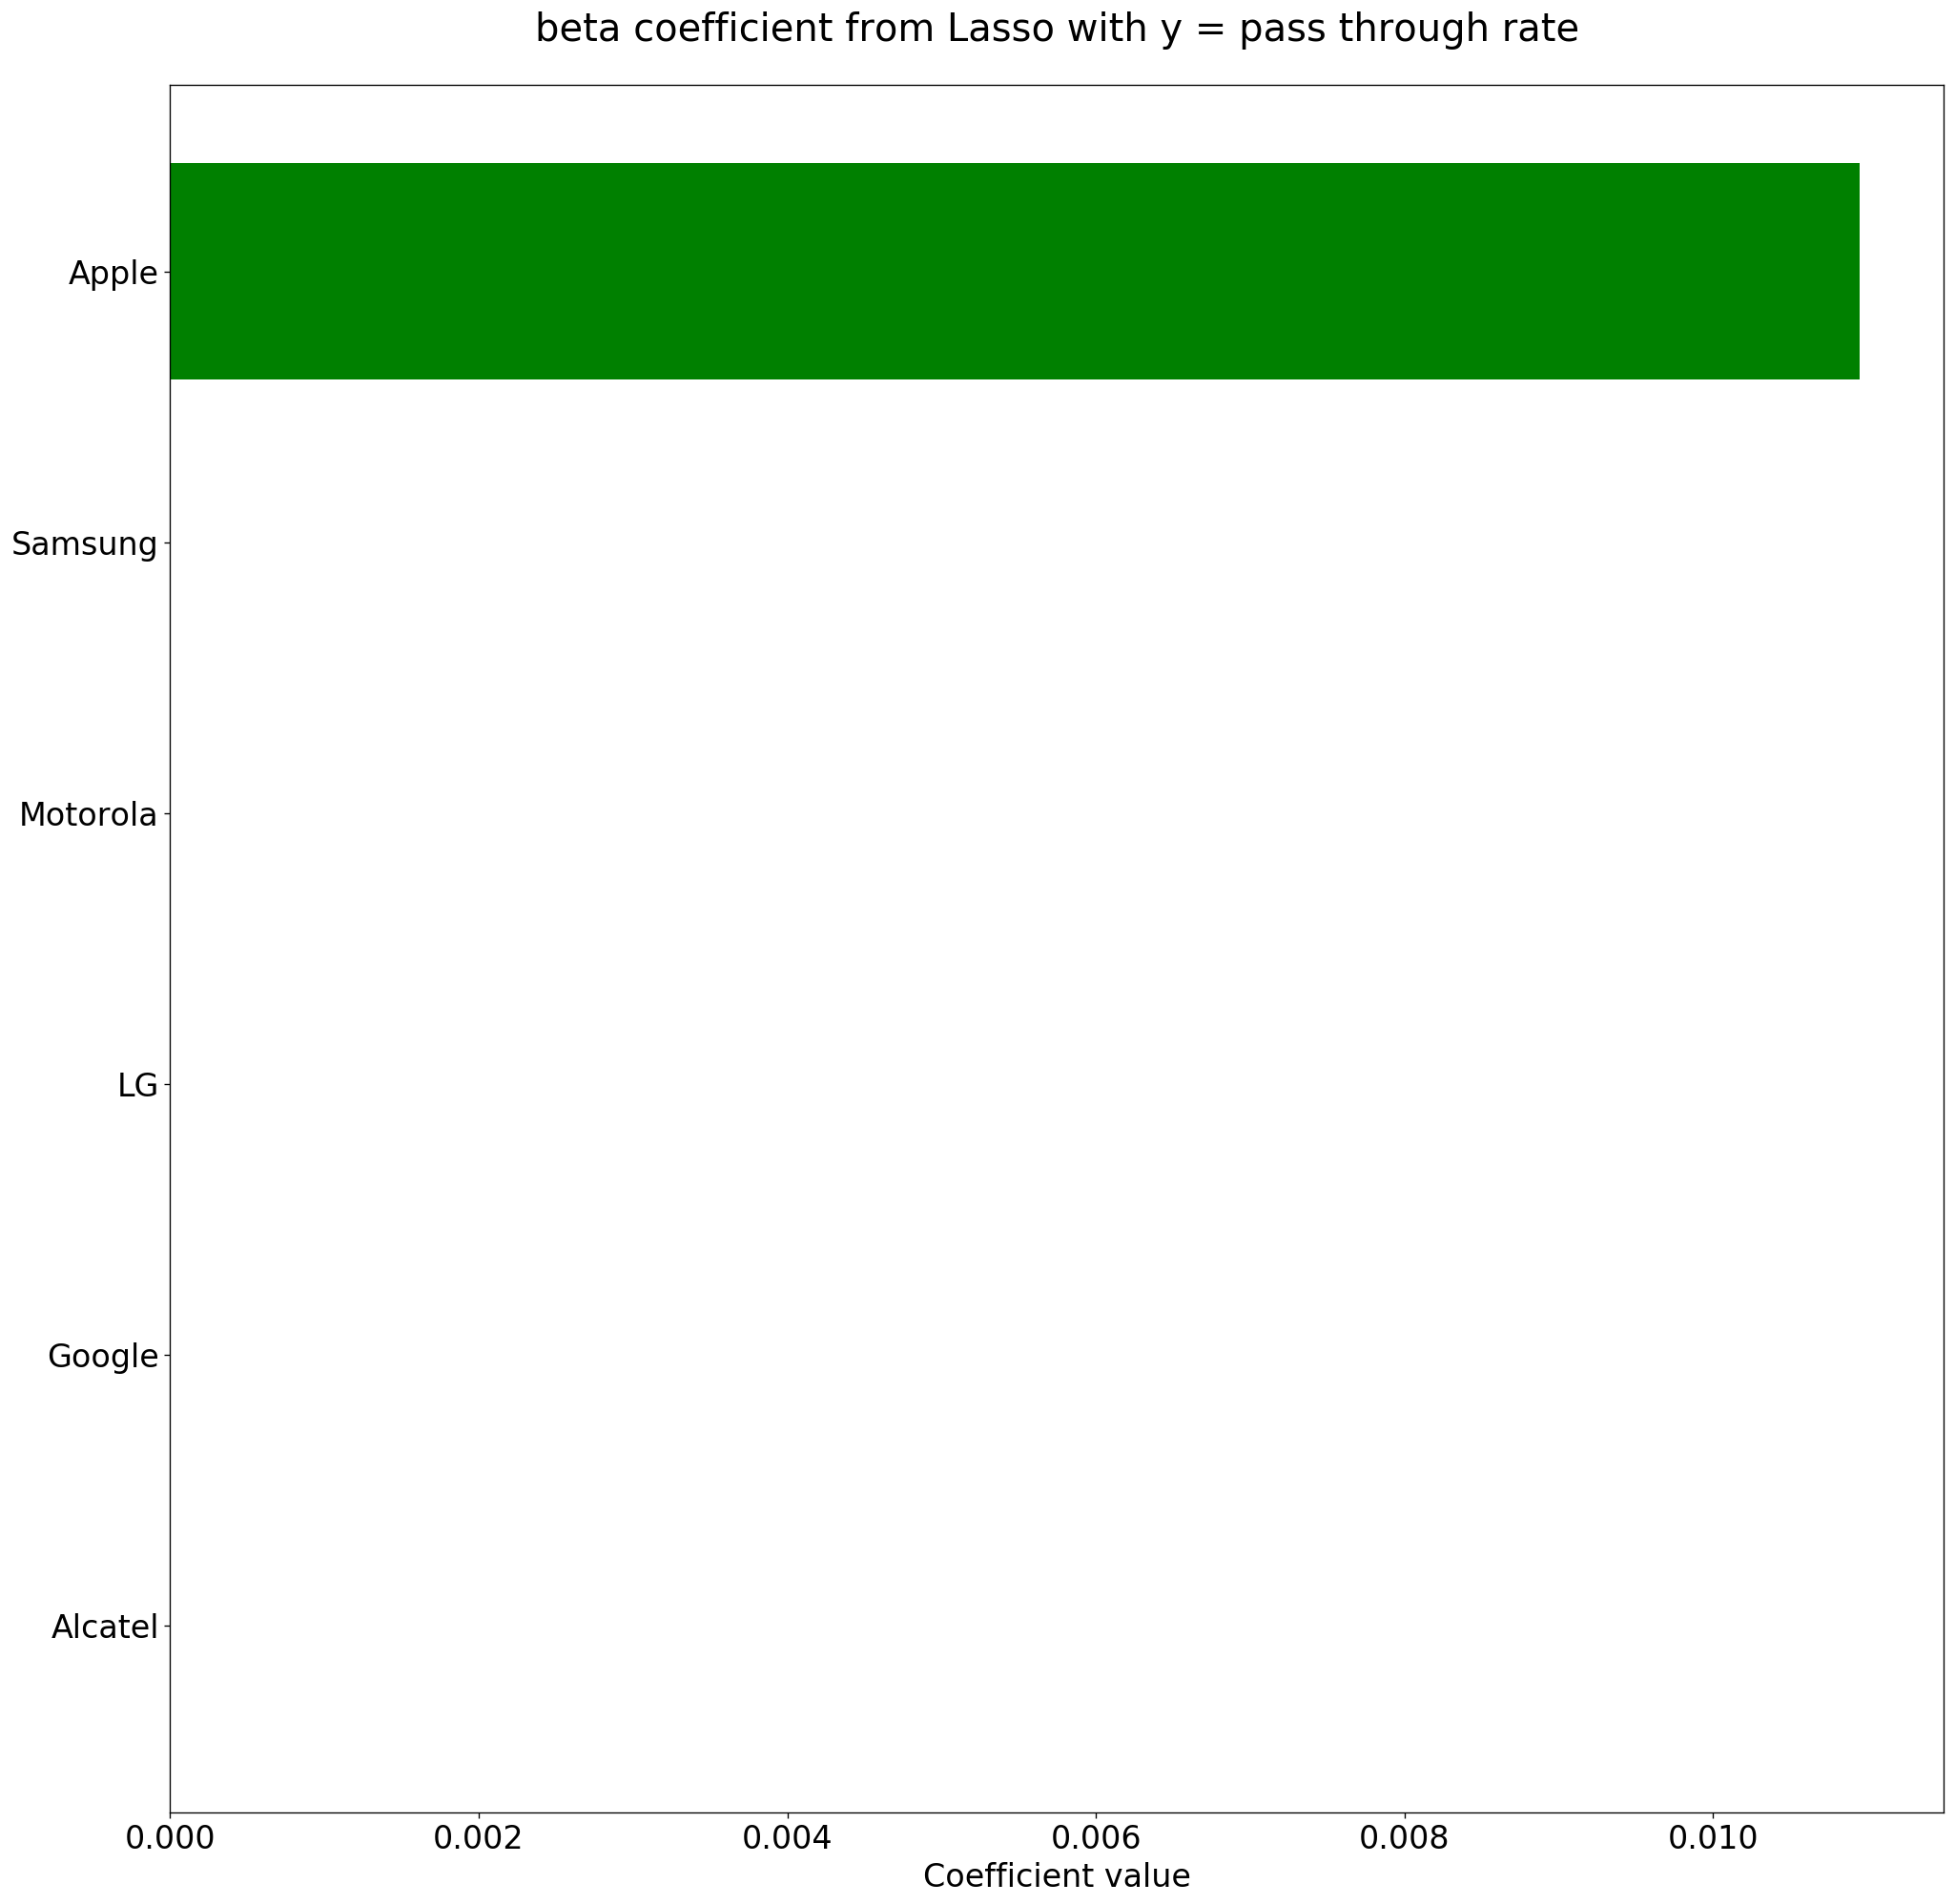

In [315]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,20), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(device_brand_coefs_sign[mask2_coef]['device_brand'], device_brand_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(device_brand_coefs_sign[mask1_coef]['device_brand'], device_brand_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()

## Lags

In [316]:
lag_coefs_sign = positive_coef_col(lag_coefs)

In [317]:
mask1_coef = lag_coefs_sign['positive_coef'] == 1
mask2_coef = lag_coefs_sign['positive_coef'] == 0

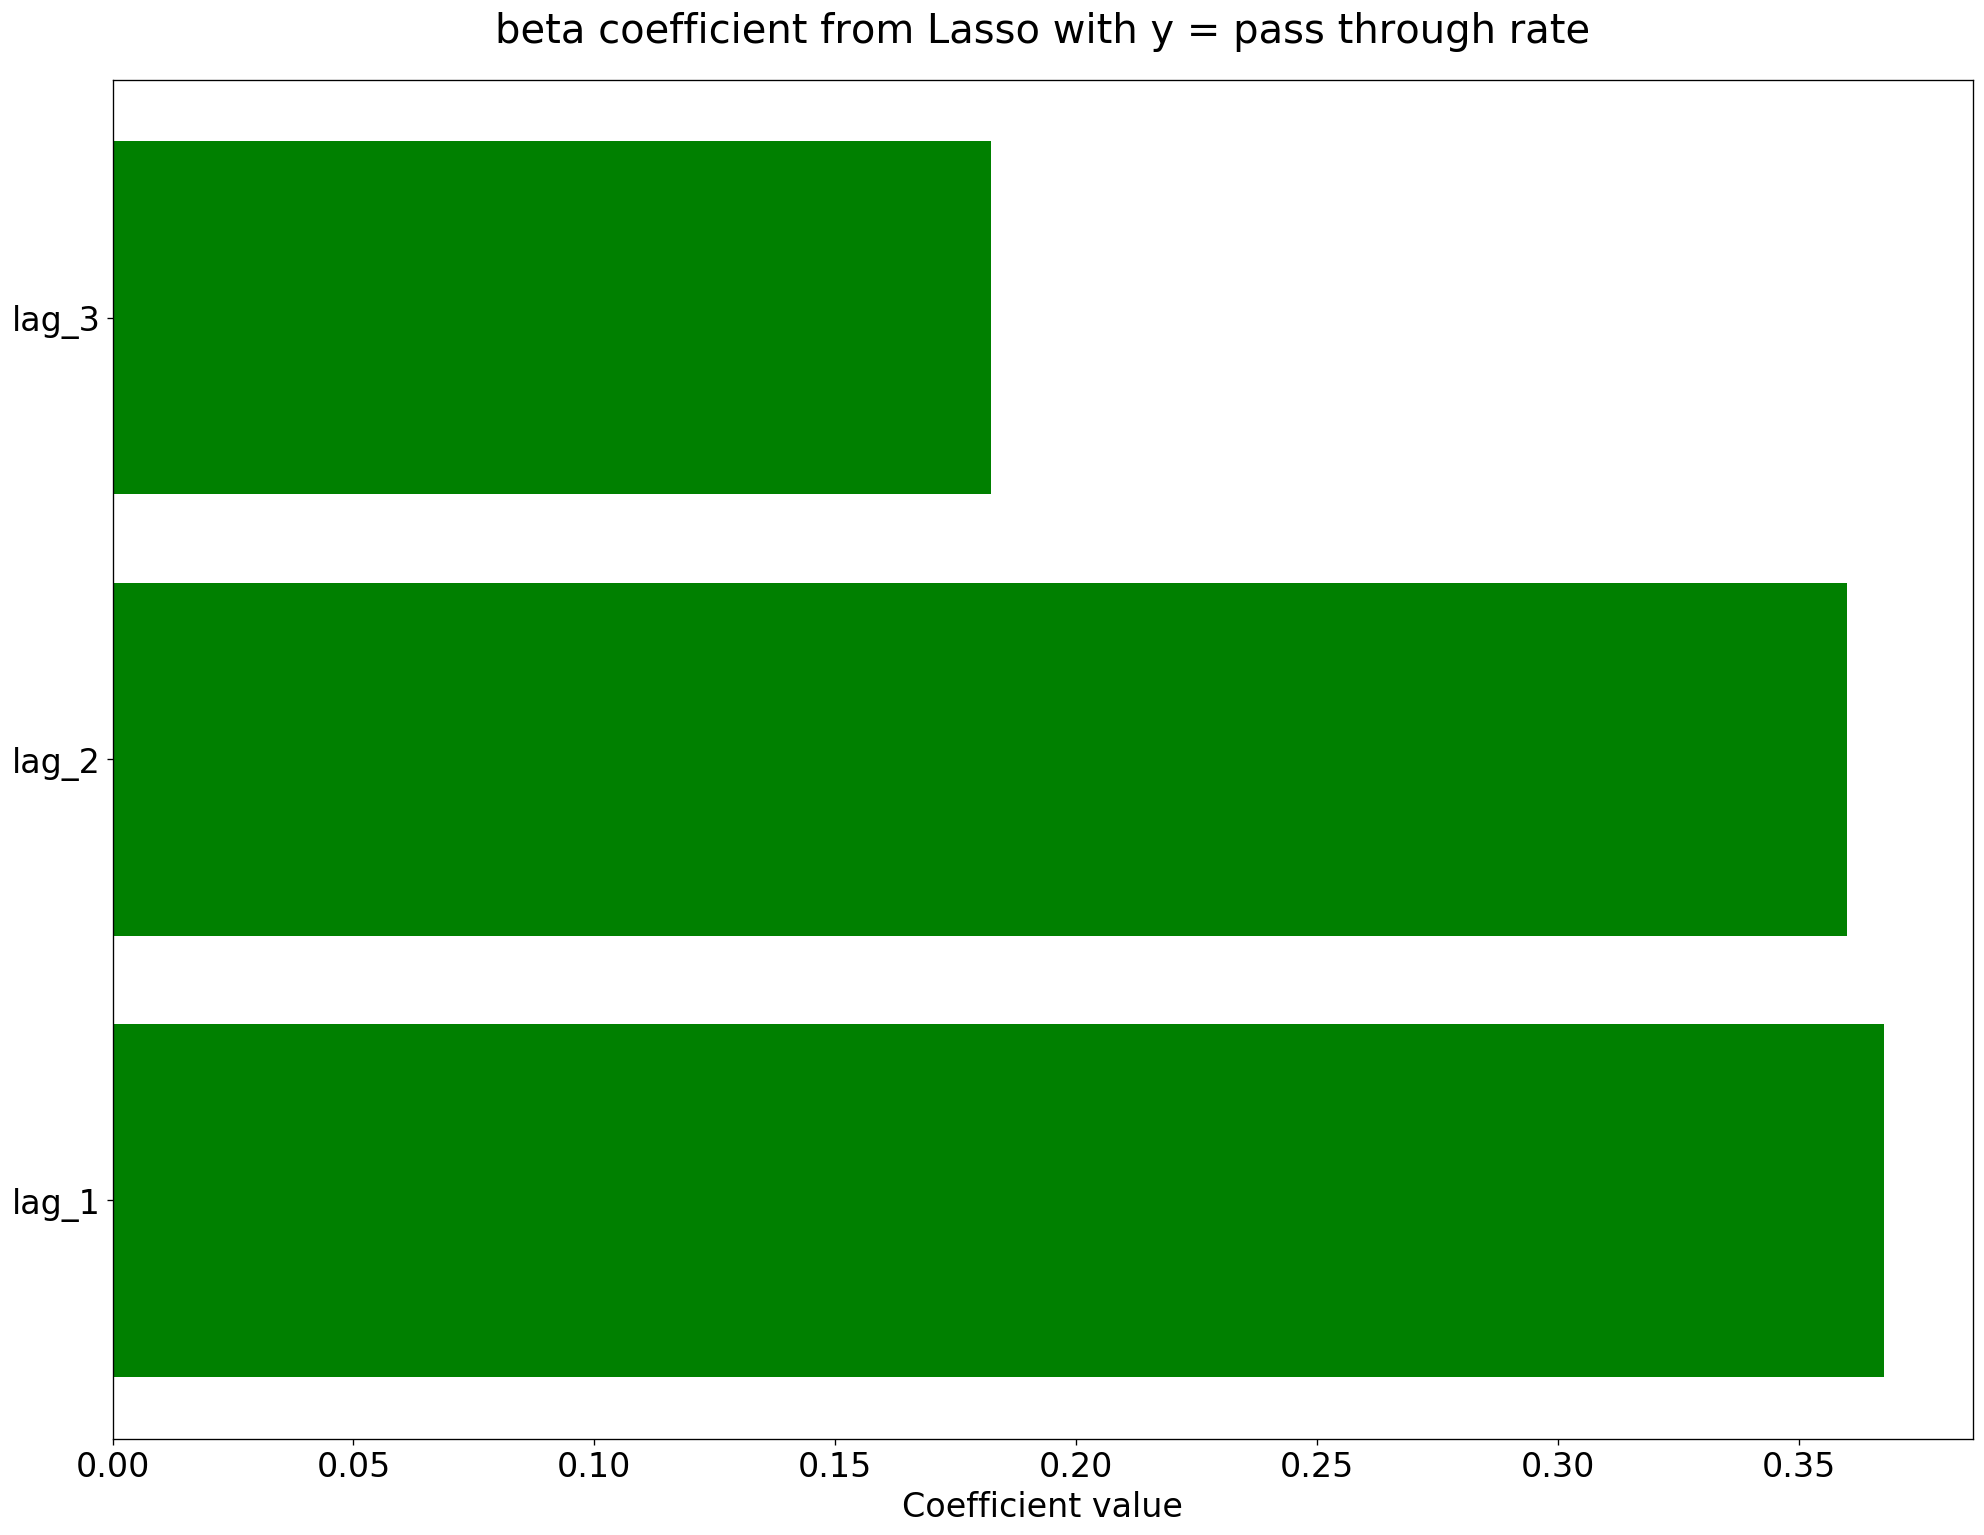

In [318]:
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':120})
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = True

plt.barh(lag_coefs_sign[mask2_coef]['lag'], lag_coefs_sign[mask2_coef]['coefficient'], color = 'red')
plt.barh(lag_coefs_sign[mask1_coef]['lag'], lag_coefs_sign[mask1_coef]['coefficient'], color = 'green')

plt.title('beta coefficient from Lasso with y = pass through rate').set_position([.5, 1.02])
plt.xlabel('Coefficient value')
#plt.ylabel('Channel name')


plt.show()